# Notebook İçeriği

1. [__Veride Kontroller ve Düzeltmeler__](#1.)


2. [__EDA - Keşifsel Veri Analizi__](#2.)

    * 2.1 [__Tek Değişkenli İnceleme - Değişkenlerin Dağılımları__](#2.1.)
    
         * [Sayısal Değişkenler](#2.1.1.)
         * [Kategorik Değişkenler](#2.1.2.)
         * [Hedef Değişkenin Dağılımı](#2.1.3.)
         * [Kutu Grafikleri](#2.1.4.)
                
    * 2.2 [__Çok Değişkenli İnceleme__](#2.2.)
         * [Sayısal Değişkenler ve Hedef Değişkeni Arasında - 3 boyutlu](#2.2.1.)
         * [Hedefe Göre Sayısal Değişkenlerin İstatistikleri](#2.2.2.)
         * [Hedefe Göre Sayısal Değişkenlerin İstatistikleri - Üretilen Sayısal Değişkenler İçin](#2.2.3.)
         * [Kategorik Değişkenlere Göre Sayısal Değişkenlerin İstatistikleri](#2.2.4.)
         * [Hedefe Göre Kategorik Değişkenlerin İstatistikleri](#2.2.5.)
    
    * 2.3 [__Detaylı Pivot Tablolar__](#2.3.)
         * [Tablo 1](#2.3.1.)
         * [Tablo 2](#2.3.2.)
         * [Tablo 3](#2.3.3.)
         * [Tablo 4](#2.3.4.)
         * [__Öbekler Hakkında (Öbekler hakkında detaylı çıkarımlara Excel dosyasında yer verilmiştir)__](#2.3.5.)
         
         
         
3. [__Kümeleme Algoritmalarını Deneme ve Görselleştirme__](#3.)
    * 3.1 [Birch](#3.1.)
    * 3.2 [Gaussian Mixture](#3.2.)
    * 3.3 [Spectral](#3.3.)
    * 3.4 [Agglomerative](#3.4.)
    * 3.5 [KMeans](#3.5.)
    

4. [__Öznitelik Çıkarımı - FE__](#4.)


5. [__Öznitelik Seçimi - FS__](#5.)
    * 5.1 [Recursive Feature Elimination - RFECV](#5.1.)
    * 5.2 [Sequential Feature Selection - SFS](#5.2.)


6. [__Model Seçimi__](#6.)


7. [__Model/Submission Değerlendirmesi ve Yeni Setlerin Oluşturulması__](#7.)


8. [__Hiç Bir Sınıflandırma ve Kümeleme Algoritması Tarafından Doğru Tahmin Edilemeyen Örneklemin Tespiti ve İncelenmesi__](#8.)

    * 8.1 [Tespit](#8.1.)
    * 8.2 [İnceleme](#8.2.)
    * 8.3 [Bu Soruna Yönelik Çözümler](#8.3.)
        * [Bu Örneklemi Eğitim Setinden Çıkartma](#8.3.1.)
        * [Bu Örneklemdeki Aykırı Değerleri Ele Alma](#8.3.2.)


9. [__Oluşturulan Yeni Veri Seti ile Hiperparametre Optimizasyonu__](#9.)
   * 9.1 [Random Forest için](#9.1.)
   * 9.2 [XGBoost için](#9.2.)
   * 9.3 [Elde Edilen Maksimum Cross-Validation Skorları](#9.3.)
   * 9.4 [Her İki Model ile Cross-Validation Stack Oluşturma ve Tahmin Yapma](#9.4.)
   
   
10. [__Son Kararlar - Final Olarak Elde Edilen Veri Setiyle CV Stack Kurma ve Tahmin Yapma__](#10.)  


#### Kullanılacak Kütüphaneler

In [1]:
!python --version

Python 3.10.6


In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

bright_palette = sns.color_palette('bright')
muted_palette = sns.color_palette('muted')
sequential_palette = sns.color_palette('light:dodgerblue_r',9)
alert_palette = sns.color_palette('Reds_r',9)
paired_palette = sns.color_palette('Paired')
#plt.rcParams.update({'figure.dpi' : 240})

import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, KMeans
from kmodes.kprototypes import KPrototypes

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import cross_val_score ,StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, RobustScaler

le = LabelEncoder()
skf10 = StratifiedKFold(n_splits=10, shuffle=True,random_state=24)
skf5 = StratifiedKFold(n_splits=5, shuffle=True,random_state=24)

from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import optuna
from scipy.stats import mode
from itertools import combinations
from tqdm.notebook import tqdm
tqdm.pandas()

# 1. Verideki Kontroller ve Düzeltmeler <a id="1."></a>

__Gerekli düzeltmeleri yapma ve sütun isimlerini alma__

In [3]:
def fix_column_names(df):
    fixed_colnames = df.columns.map(lambda col: col.replace(' ','_'))
    df.columns = fixed_colnames

def control_df(df):
    
    for col in df.columns:
        if df[col].isna().sum() <= 0:
            if df[col].nunique() > 20:
                print(f'{col} --- nunique: {df[col].nunique()}\n')
            else:
                print(f'{col} --- nunique: {df[col].nunique()} --- unique: {df[col].unique()}\n')
        else:
            if df[col].nunique() > 20:
                print(f'{col} --- nunique: {df[col].nunique()} --- nan: {df[col].isna().sum()}\n')
            else:
                print(f'{col} --- nunique: {df[col].nunique()} --- unique: {df[col].unique()} --- nan: {df[col].isna().sum()}\n')
                

train = pd.read_csv('train.csv').drop(['index'],axis=1)
test = pd.read_csv('test_x.csv').drop(['index'],axis=1)
sub = pd.DataFrame({'id' : np.arange(0,2340), 'Öbek İsmi' : np.nan})
    
fix_column_names(train)
fix_column_names(test)

target = 'Öbek_İsmi'
cat_cols = [col for col in train.columns if train[col].dtype == 'O']
cat_cols.remove(target)
num_cols = [col for col in train.columns if train[col].dtype != 'O']

train[num_cols] = train[num_cols].apply(lambda x: round(x,2))
test[num_cols] = test[num_cols].apply(lambda x: round(x,2))

In [4]:
train

Cinsiyet Yaş_Grubu Medeni_Durum         Eğitim_Düzeyi  \
0       Kadın     31-40        Bekar  Yüksek Lisans Mezunu   
1       Erkek       >60         Evli           Lise Mezunu   
2       Erkek     18-30        Bekar           Lise Mezunu   
3       Erkek     51-60         Evli           Lise Mezunu   
4       Erkek     31-40         Evli       Ortaokul Mezunu   
...       ...       ...          ...                   ...   
5455    Kadın       >60        Bekar     Üniversite Mezunu   
5456    Erkek     51-60         Evli         Doktora Ötesi   
5457    Kadın     51-60         Evli        İlkokul Mezunu   
5458    Kadın     18-30        Bekar     Yüksekokul Mezunu   
5459    Erkek     18-30        Bekar     Yüksekokul Mezunu   

                     İstihdam_Durumu  Yıllık_Ortalama_Gelir   Yaşadığı_Şehir  \
0     Düzenli ve Ücretli Bir İşi Var              748266.44      Büyük Şehir   
1                Kendi İşinin Sahibi              246298.61      Küçük Şehir   
2     Düzenli ve Ücretli Bir İşi Var              268582.73      Küçük Şehir   
3                Kendi İşinin Sahibi              327721.84           Kırsal   
4     İşsiz veya Düzenli Bir İşi Yok              397431.63      Büyük Şehir   
...                              ...                    ...              ...   
5455                          Emekli              478054.25  Köy veya Kasaba   
5456             Kendi İşinin Sahibi              481852.85  Köy veya Kasaba   
5457  Düzenli ve Ücretli Bir İşi Var              309443.69      Küçük Şehir   
5458  Düzenli ve Ücretli Bir İşi Var              266604.27      Büyük Şehir   
5459  Düzenli ve Ücretli Bir İşi Var              276155.08      Büyük Şehir   

         En_Çok_İlgilendiği_Ürün_Grubu  Yıllık_Ortalama_Satın_Alım_Miktarı  \
0     Elektronik ve Teknolojik Ürünler                            32010.90   
1                     Spor Malzemeleri                             4145.73   
2                                Giyim                             9924.38   
3                                Giyim                             6417.78   
4                                Giyim                             7886.66   
...                                ...                                 ...   
5455                          Kozmetik                            43182.30   
5456                     Ev ve Mobilya                            42108.00   
5457                     Ev ve Mobilya                             4655.39   
5458                     Ev ve Mobilya                             9016.17   
5459                  Spor Malzemeleri                             9455.66   

      Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi Eğitime_Devam_Etme_Durumu  \
0                                          37.31                   Etmiyor   
1                                          11.55                   Etmiyor   
2                                          55.35                    Ediyor   
3                                          15.42                   Etmiyor   
4                                          14.69                   Etmiyor   
...                                          ...                       ...   
5455                                       31.36                   Etmiyor   
5456                                       26.29                   Etmiyor   
5457                                        5.16                   Etmiyor   
5458                                       39.21                    Ediyor   
5459                                       50.55                    Ediyor   

     Öbek_İsmi  Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi  
0       obek_4                                    102.94  
1       obek_5                                     82.18  
2       obek_8                                    141.66  
3       obek_3                                     17.10  
4       obek_3                                     20.47  
...        ...                                       ...  
5455    obek

In [5]:
test

Cinsiyet Yaş_Grubu Medeni_Durum         Eğitim_Düzeyi  \
0       Erkek     51-60         Evli  Yüksek Lisans Mezunu   
1       Erkek     41-50        Bekar           Lise Mezunu   
2       Kadın       >60         Evli             Eğitimsiz   
3       Kadın     51-60         Evli         Doktora Ötesi   
4       Erkek     18-30         Evli  Yüksek Lisans Mezunu   
...       ...       ...          ...                   ...   
2335    Kadın     18-30        Bekar     Yüksekokul Mezunu   
2336    Kadın     31-40         Evli           Lise Mezunu   
2337    Erkek       >60         Evli  Yüksek Lisans Mezunu   
2338    Erkek     18-30         Evli         Doktora Ötesi   
2339    Erkek     51-60         Evli     Üniversite Mezunu   

                     İstihdam_Durumu  Yıllık_Ortalama_Gelir   Yaşadığı_Şehir  \
0     Düzenli ve Ücretli Bir İşi Var              365331.93  Köy veya Kasaba   
1     İşsiz veya Düzenli Bir İşi Yok              414899.24      Büyük Şehir   
2     İşsiz veya Düzenli Bir İşi Yok              152825.87      Küçük Şehir   
3     Düzenli ve Ücretli Bir İşi Var              489052.91  Köy veya Kasaba   
4                Kendi İşinin Sahibi              323635.71      Küçük Şehir   
...                              ...                    ...              ...   
2335             Kendi İşinin Sahibi              259190.08      Küçük Şehir   
2336  İşsiz veya Düzenli Bir İşi Yok              194580.56           Kırsal   
2337  Düzenli ve Ücretli Bir İşi Var              357730.52      Büyük Şehir   
2338  Düzenli ve Ücretli Bir İşi Var              213179.64      Küçük Şehir   
2339  Düzenli ve Ücretli Bir İşi Var              519013.57  Köy veya Kasaba   

         En_Çok_İlgilendiği_Ürün_Grubu  Yıllık_Ortalama_Satın_Alım_Miktarı  \
0                                Giyim                             5566.59   
1                     Spor Malzemeleri                             6756.77   
2                                Giyim                             4493.92   
3                             Kozmetik                            42670.65   
4                                Giyim                             5959.27   
...                                ...                                 ...   
2335                     Ev ve Mobilya                             9559.16   
2336                     Ev ve Mobilya                             4070.23   
2337                     Ev ve Mobilya                            22589.20   
2338                  Spor Malzemeleri                             4205.39   
2339  Elektronik ve Teknolojik Ürünler                            42675.35   

      Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi Eğitime_Devam_Etme_Durumu  \
0                                          15.44                   Etmiyor   
1                                          14.96                   Etmiyor   
2                                          10.91                   Etmiyor   
3                                          32.33                   Etmiyor   
4                                           4.52                   Etmiyor   
...                                          ...                       ...   
2335                                       41.88                    Ediyor   
2336                                       20.08                   Etmiyor   
2337                                       18.92                   Etmiyor   
2338                                       10.76                   Etmiyor   
2339                                       30.83                    Ediyor   

      Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi  
0                                        19.65  
1                                        19.68  
2                                        46.90  
3                                        48.08  
4                                        12.75  
...                                        ...  
2335                                    117.63  
2336                             

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Cinsiyet                                    5460 non-null   object 
 1   Yaş_Grubu                                   5460 non-null   object 
 2   Medeni_Durum                                5460 non-null   object 
 3   Eğitim_Düzeyi                               5460 non-null   object 
 4   İstihdam_Durumu                             5460 non-null   object 
 5   Yıllık_Ortalama_Gelir                       5460 non-null   float64
 6   Yaşadığı_Şehir                              5460 non-null   object 
 7   En_Çok_İlgilendiği_Ürün_Grubu               5460 non-null   object 
 8   Yıllık_Ortalama_Satın_Alım_Miktarı          5460 non-null   float64
 9   Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi  5460 non-null   float64
 10  Eğitime_Deva

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Cinsiyet                                    2340 non-null   object 
 1   Yaş_Grubu                                   2340 non-null   object 
 2   Medeni_Durum                                2340 non-null   object 
 3   Eğitim_Düzeyi                               2340 non-null   object 
 4   İstihdam_Durumu                             2340 non-null   object 
 5   Yıllık_Ortalama_Gelir                       2340 non-null   float64
 6   Yaşadığı_Şehir                              2340 non-null   object 
 7   En_Çok_İlgilendiği_Ürün_Grubu               2340 non-null   object 
 8   Yıllık_Ortalama_Satın_Alım_Miktarı          2340 non-null   float64
 9   Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi  2340 non-null   float64
 10  Eğitime_Deva

__Kategorik değişkenlerin incelenmesi__

In [8]:
train[cat_cols+[target]].astype('object').describe().T

count unique                             top  \
Cinsiyet                       5460      2                           Erkek   
Yaş_Grubu                      5460      5                           18-30   
Medeni_Durum                   5460      2                            Evli   
Eğitim_Düzeyi                  5460      9                     Lise Mezunu   
İstihdam_Durumu                5460      4  Düzenli ve Ücretli Bir İşi Var   
Yaşadığı_Şehir                 5460      4                     Büyük Şehir   
En_Çok_İlgilendiği_Ürün_Grubu  5460      5                           Giyim   
Eğitime_Devam_Etme_Durumu      5460      2                         Etmiyor   
Öbek_İsmi                      5460      8                          obek_4   

                               freq  
Cinsiyet                       2964  
Yaş_Grubu                      1841  
Medeni_Durum                   2834  
Eğitim_Düzeyi                  1388  
İstihdam_Durumu                2768  
Yaşadığı_Şehir                 1959  
En_Çok_İlgilendiği_Ürün_Grubu  1487  
Eğitime_Devam_Etme_Durumu      4554  
Öbek_İsmi                       720

__Sayısal Değişkenlerin İncelenmesi__

In [9]:
train[num_cols].describe().T

count      mean       std  \
Yıllık_Ortalama_Gelir                      5460.00 363571.13 219714.44   
Yıllık_Ortalama_Satın_Alım_Miktarı         5460.00  16616.61  14099.17   
Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi 5460.00     24.04     14.95   
Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi   5460.00     73.45     47.21   

                                                min       25%       50%  \
Yıllık_Ortalama_Gelir                      43922.99 215693.44 286925.43   
Yıllık_Ortalama_Satın_Alım_Miktarı          2859.25   4931.86   8426.82   
Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi     0.00     11.55     20.09   
Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi       3.98     25.01     82.48   

                                                 75%        max  
Yıllık_Ortalama_Gelir                      468188.22 1192437.15  
Yıllık_Ortalama_Satın_Alım_Miktarı          30579.24   48605.59  
Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi     35.91      64.62  
Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi      104.47     242.31

__Kategorik Değerleri ve Kardinaliteleri İnceleme__

In [10]:
control_df(train[cat_cols+[target]])

Cinsiyet --- nunique: 2 --- unique: ['Kadın' 'Erkek']

Yaş_Grubu --- nunique: 5 --- unique: ['31-40' '>60' '18-30' '51-60' '41-50']

Medeni_Durum --- nunique: 2 --- unique: ['Bekar' 'Evli']

Eğitim_Düzeyi --- nunique: 9 --- unique: ['Yüksek Lisans Mezunu' 'Lise Mezunu' 'Ortaokul Mezunu'
 'Yüksekokul Mezunu' 'Üniversite Mezunu' 'Doktora Mezunu' 'İlkokul Mezunu'
 'Doktora Ötesi' 'Eğitimsiz']

İstihdam_Durumu --- nunique: 4 --- unique: ['Düzenli ve Ücretli Bir İşi Var' 'Kendi İşinin Sahibi'
 'İşsiz veya Düzenli Bir İşi Yok' 'Emekli']

Yaşadığı_Şehir --- nunique: 4 --- unique: ['Büyük Şehir' 'Küçük Şehir' 'Kırsal' 'Köy veya Kasaba']

En_Çok_İlgilendiği_Ürün_Grubu --- nunique: 5 --- unique: ['Elektronik ve Teknolojik Ürünler' 'Spor Malzemeleri' 'Giyim'
 'Ev ve Mobilya' 'Kozmetik']

Eğitime_Devam_Etme_Durumu --- nunique: 2 --- unique: ['Etmiyor' 'Ediyor']

Öbek_İsmi --- nunique: 8 --- unique: ['obek_4' 'obek_5' 'obek_8' 'obek_3' 'obek_6' 'obek_1' 'obek_7' 'obek_2']



# 2. EDA - Keşifsel Veri Analizi <a id="2."></a>

### Görselleştirme esnasında kullanacağım fonksiyonlarım:

In [11]:
def plot_distributions(data, columns,kde=False, log_transform=False, label_angle=0, 
                       figsize = (12,5) , order_cats= False, target_pie=False, alert=False): 

    if alert == True:
        pie_palette = alert_palette
    else:
        pie_palette = sequential_palette
        
    if target_pie == True:
        ax = data[columns].value_counts().plot.pie(autopct='%1.1f%%',
                                              textprops={'fontsize':10},
                                              colors=pie_palette
                                              ).set_title(f"{target} Distribution")
        plt.ylabel('')
        plt.show()

    else:
        for col in columns:
            if log_transform == True:
                x = np.log10(data[col])
                title = f'{col} - Log Transformed'
            else:
                x = data[col]
                title = f'{col}'
            
            if order_cats == True:
                labels = data[col].value_counts(ascending=False).index
                values = data[col].value_counts(ascending=False).values
                
                plt.subplots(figsize=figsize)
                plt.tight_layout()
                plt.xticks(rotation=label_angle)
                sns.barplot(x=labels,
                            y=values,
                            palette= sequential_palette)
                        
            else:   
                plt.subplots(figsize=figsize)
                plt.tight_layout()
                plt.xticks(rotation=label_angle)
                sns.histplot(x,
                        bins=50,
                        kde=kde,
                        color=sequential_palette[0])

    
            plt.title(title)
            plt.show()
            
            
def numeric_variables_boxplot(df, num_cols, target=None, alert=False):
    
    if alert == True:
        palette = alert_palette
    else:
        palette = bright_palette
        
    if target == None:
        
        fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4, figsize=(15,6))

        for col, ax, i in zip(num_cols, [ax1,ax2,ax3,ax4], range(4)):
            sns.boxplot(df[col], 
                        color=palette[i], 
                        ax=ax
                        ).set_title(col)
            
        for ax in [ax1,ax2,ax3,ax4]:
            ax.set_xticklabels([])
    else:
        for col in num_cols:
            plt.subplots(figsize=(15,6))
            sns.boxplot(x=df[target], 
                                y=df[col],
                                hue=df[target],
                                dodge=False, 
                                fliersize=3,
                                linewidth=0.7,
                                palette=palette)
            plt.title(col)
            plt.xlabel('')
            plt.ylabel('')
            plt.xticks(rotation=45)
            plt.legend('',frameon=False)

    plt.tight_layout()
    plt.show()

def numcols_target_corr(df):
    
    
    numvar_combinations = list(combinations(num_cols, 2))
    
    for item in numvar_combinations:
        
        plt.subplots(figsize=(14,8))
        sns.scatterplot(x=df[item[0]], 
                        y=df[item[1]],
                        hue=df[target],
                        palette=bright_palette
                       ).set_title(f'{item[0]}   &   {item[1]}')
        plt.grid(True)
        plt.show()
        
        
def plot_avg_numvars_by_target(df, num_cols,agg='mean', round_ndigits=1, alert=False):
    
    if alert == True:
        palette = alert_palette
    else:
        palette = sequential_palette
        
    for col in num_cols:
        
        if agg == 'max':
            col_grouped = df.groupby('Öbek_İsmi')[col].max().reset_index().sort_values(ascending=False,by=col)
        elif agg == 'min':
            col_grouped = df.groupby('Öbek_İsmi')[col].min().reset_index().sort_values(ascending=True,by=col)
        elif agg == 'sum':
            col_grouped = df.groupby('Öbek_İsmi')[col].sum().reset_index().sort_values(ascending=False,by=col)
        elif agg == 'std':
            col_grouped = df.groupby('Öbek_İsmi')[col].std().reset_index().sort_values(ascending=False,by=col)
        else:
            col_grouped = df.groupby('Öbek_İsmi')[col].mean().reset_index().sort_values(ascending=False,by=col)
        
        plt.subplots(figsize=(14,4))
        ax = sns.barplot(x=col_grouped['Öbek_İsmi'], 
                     y=col_grouped[col], 
                     width=0.8,
                     palette=palette,
                     errorbar=None)
        ax.set_yticklabels([])  
    
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width() / 2., 
                    p.get_height(), 
                    round(p.get_height(),ndigits=round_ndigits), 
                    fontsize=10, color='black', ha='center', va='top')
            
        plt.xlabel('')  
        #plt.ylabel('')
        plt.xticks(rotation=45)
        plt.title(f'{agg} {col} - {target}')
        plt.show()    

        
def plot_avg_numvars_by_catvars(df, agg='mean',num_col='Yıllık_Ortalama_Gelir'):
    
    for col in cat_cols:
        
        if agg == 'max':
            col_grouped = df.groupby(col)[num_col].max().reset_index().sort_values(ascending=False,by=num_col)
        elif agg == 'min':
            col_grouped = df.groupby(col)[num_col].min().reset_index().sort_values(ascending=True,by=num_col)
        elif agg == 'sum':
            col_grouped = df.groupby(col)[num_col].sum().reset_index().sort_values(ascending=False,by=num_col)
        elif agg == 'std':
            col_grouped = df.groupby(col)[num_col].std().reset_index().sort_values(ascending=False,by=num_col)
        else:
            col_grouped = df.groupby(col)[num_col].mean().reset_index().sort_values(ascending=False,by=num_col)
        
        plt.subplots(figsize=(14,4))
        ax = sns.barplot(x=col_grouped[col], 
                     y=col_grouped[num_col], 
                     width=0.8,
                     palette=sequential_palette,
                     errorbar=None)
        ax.set_yticklabels([])  
    
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width() / 2., 
                    p.get_height(), 
                    round(p.get_height(),ndigits=1), 
                    fontsize=10, color='black', ha='center', va='top')
            
        plt.xlabel('')  
        #plt.ylabel('')
        plt.xticks(rotation=45)
        plt.title(f'{agg} {num_col} - {col}')
        plt.show()

        
def plot_freq_catvars_by_target(df, first_n= None):
    
    for col in cat_cols:
        
        if first_n != None:
            n = first_n
        else:
            n = df[col].nunique()
            
        col_grouped = df.groupby([target,col]
                           ).size().reset_index(name='count').sort_values(by=[col,'count'],ascending=[True,False]
                                                                         ).groupby(target).apply(lambda x:
                                                                                                 x.nlargest(n, 'count')
                                                                                                ).reset_index(drop=True)
        
        '''sorted_indexes = df.groupby(target)[col].apply(lambda x: x.value_counts().index.to_list()).reset_index()
        sorted_order = dict(zip(df[target], df[col]))
        cluster_order = sorted(df[target].unique())
        hue_order = [sorted_order[cluster] for cluster in cluster_order]
        hue_order = [a for b in hue_order for a in b]'''
       
        plt.subplots(figsize=(14,4))
        ax = sns.barplot(x=col_grouped[target], 
                     y='count',
                    data= col_grouped,
                    hue = col,
                    width=0.8,
                    palette=paired_palette,
                    errorbar=None)
        #ax.set_yticklabels([])  
    
        '''for p in ax.patches:
            ax.text(p.get_x() + p.get_width() / 2., 
                    p.get_height(), 
                    round(p.get_height(),ndigits=1), 
                    fontsize=10, color='black', ha='center', va='top')'''
            
        plt.xlabel('')  
        #plt.ylabel('')
        plt.xticks(rotation=45)
        plt.title(f'Top {n} frequent in {col} - {target}')
        plt.show()
                


## 2.1. Tek Değişkenli İnceleme - Değişkenlerin Dağılımları <a id="2.1."></a>

### 2.1.1. Sayısal Değişkenler <a id="2.1.1."></a>



* __Yıllık gelir dağılımı dengesiz olduğu için logaritma dönüşümü uygulayarak görselleştirdim__

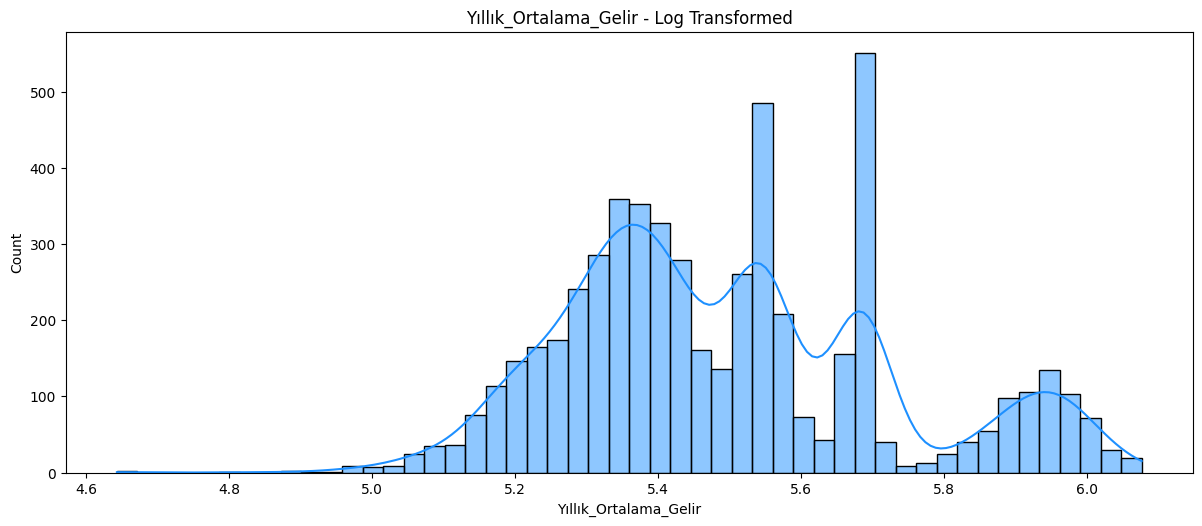

In [12]:
plot_distributions(train, num_cols[:1], kde=True, log_transform=True)

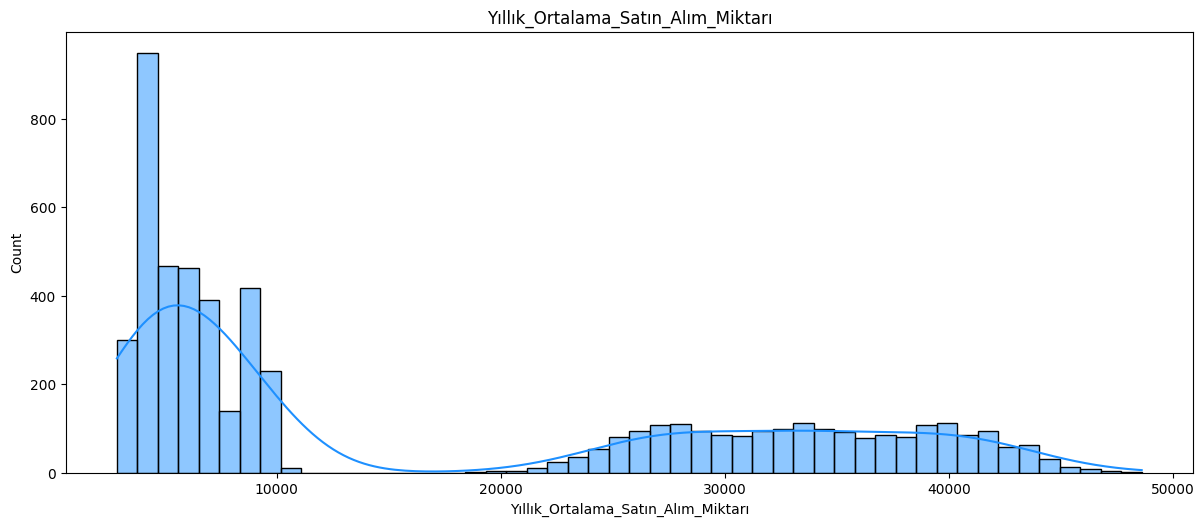

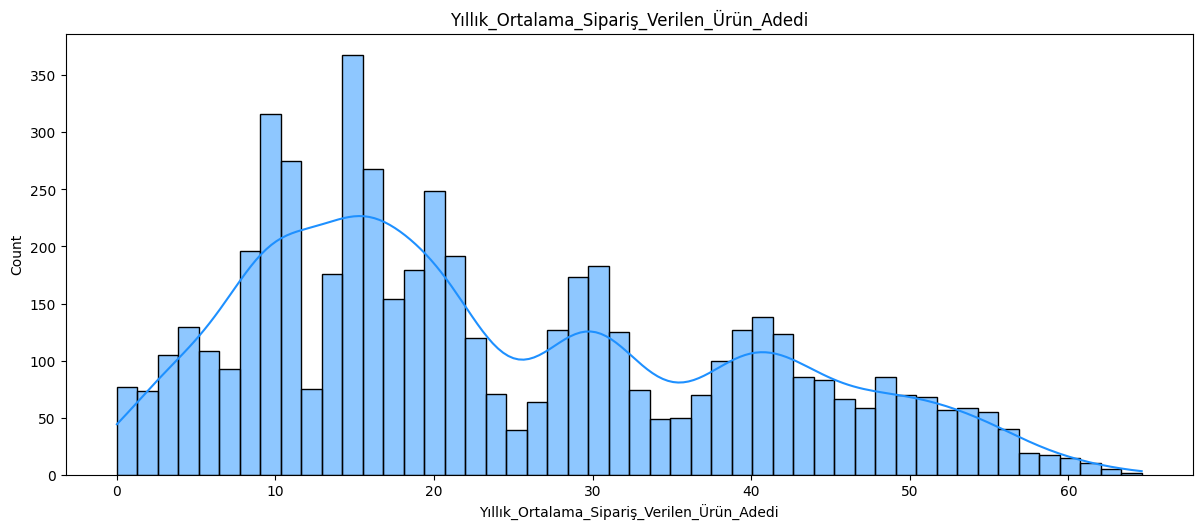

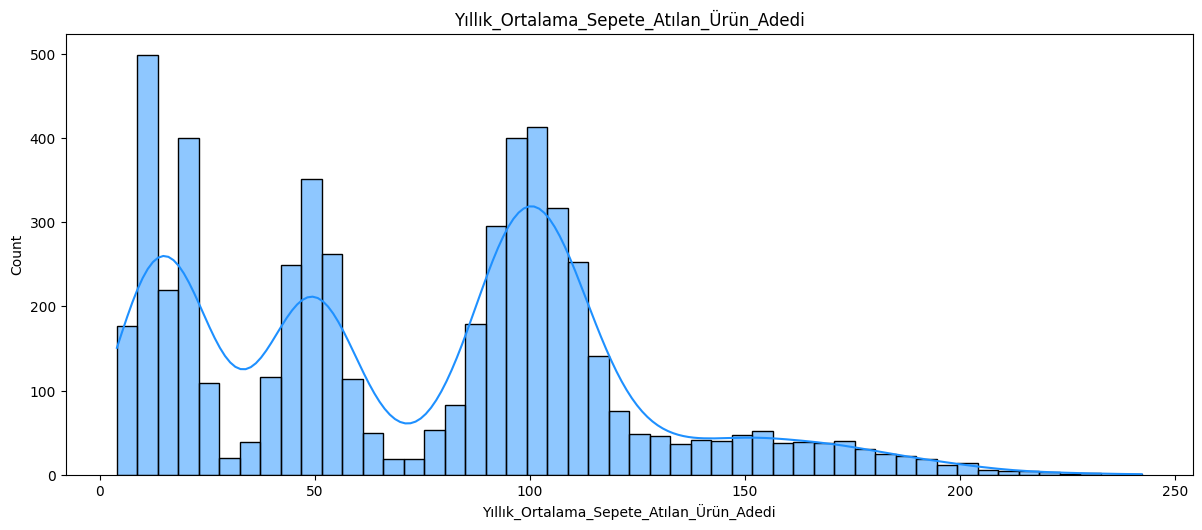

In [13]:
plot_distributions(train, num_cols[1:], kde=True, log_transform=False)

### 2.1.2. Kategorik Değişkenler <a id="2.1.2."></a>

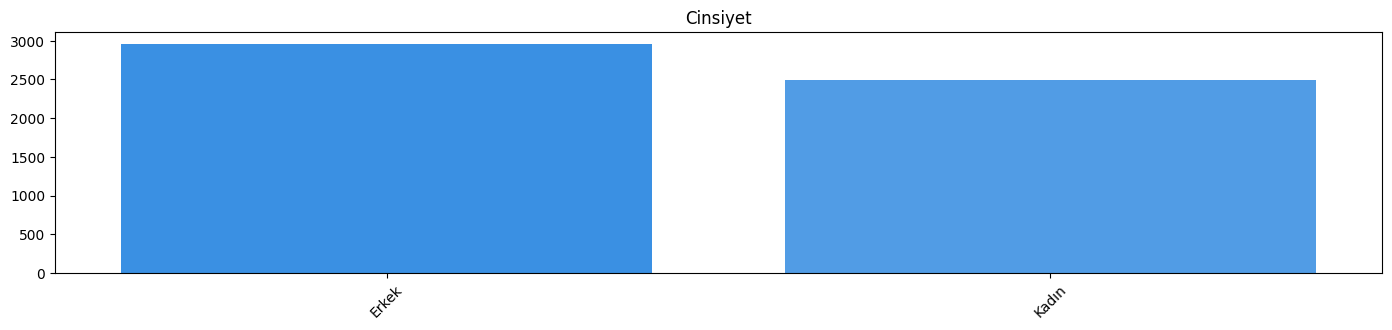

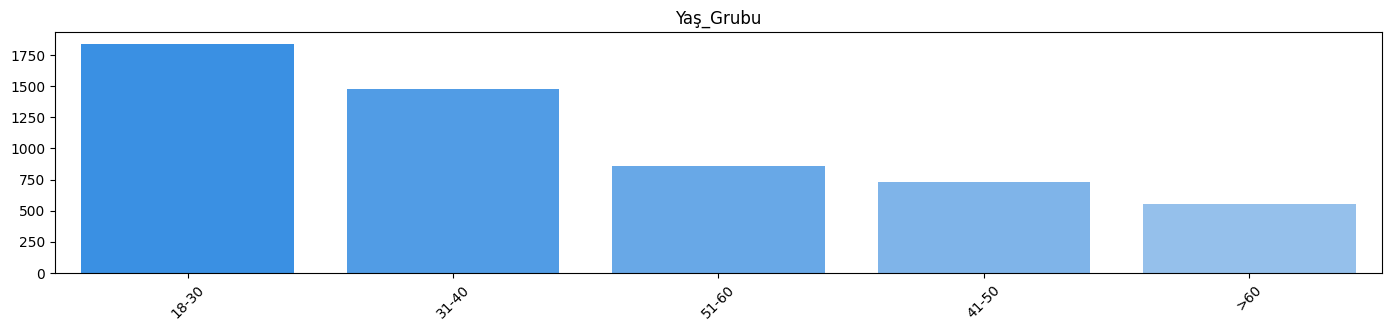

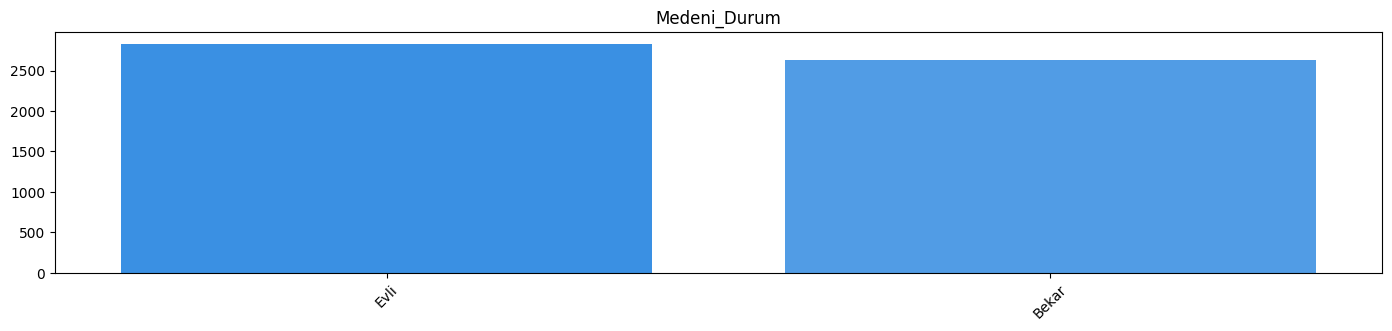

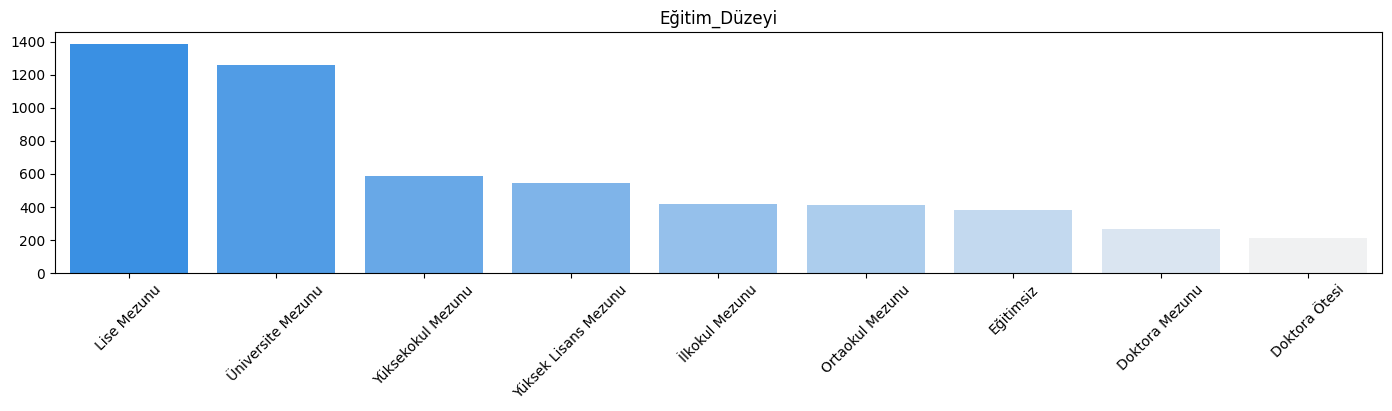

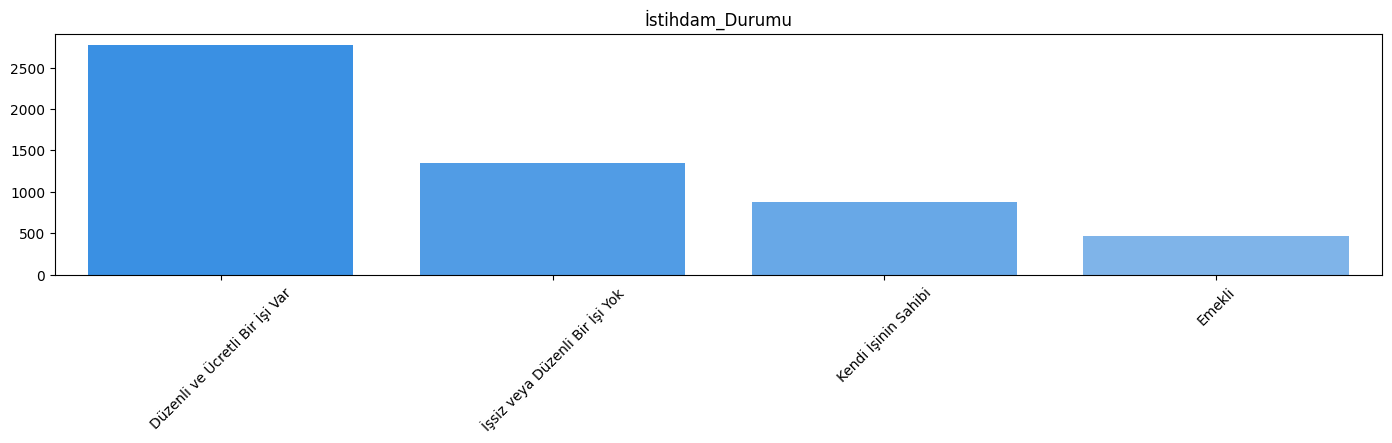

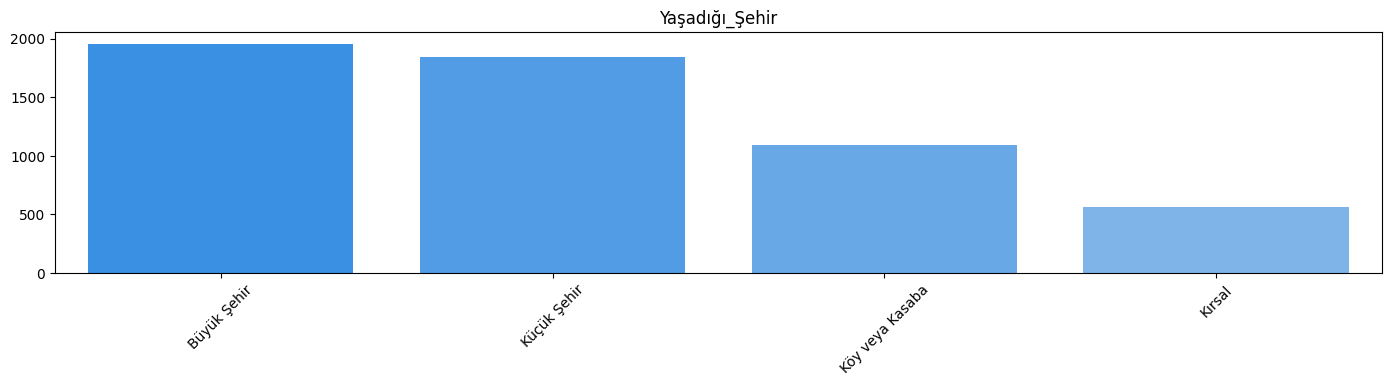

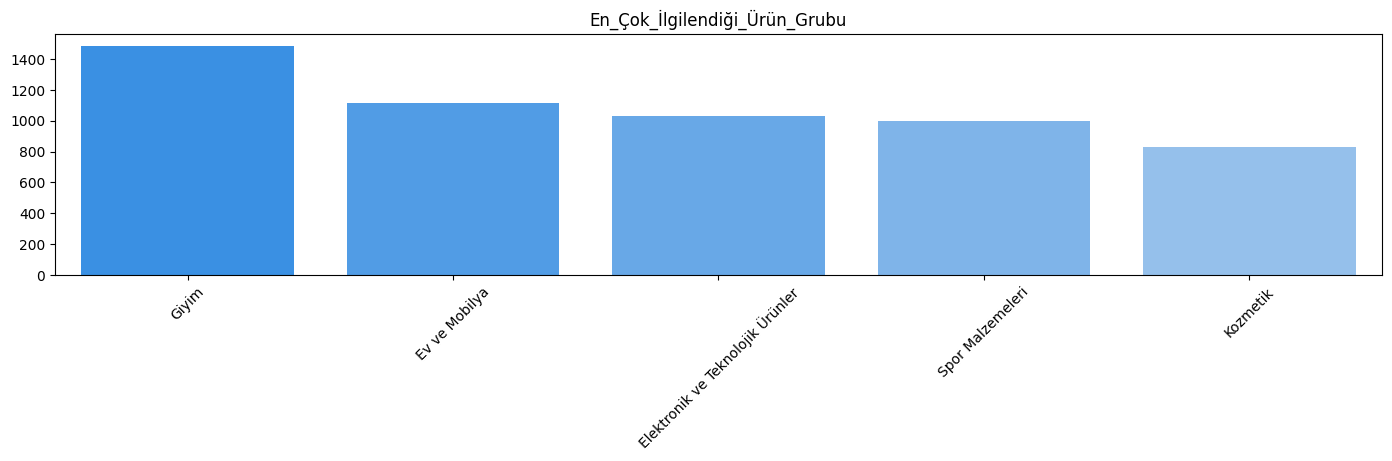

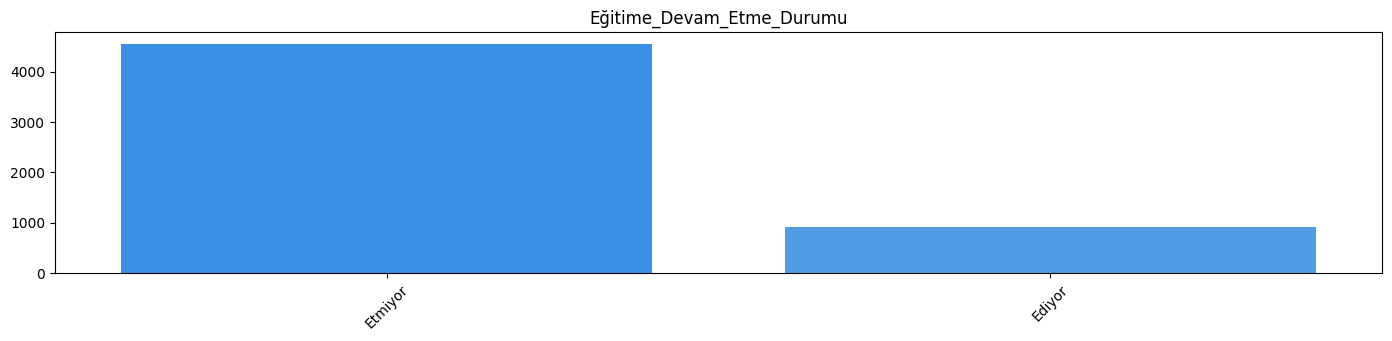

In [14]:
plot_distributions(train, cat_cols,label_angle=45, figsize=(14,3),order_cats=True)

### 2.1.3. Hedef Değişkenin Dağılımı <a id="2.1.3."></a>

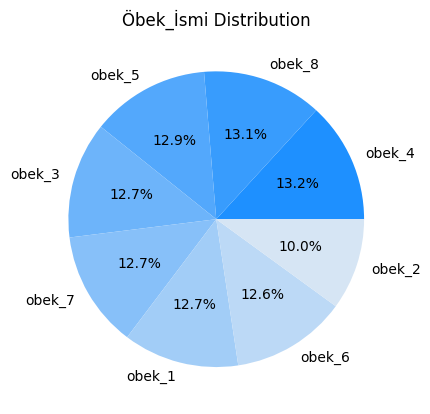

In [15]:
plot_distributions(train, target, target_pie=True)

### 2.1.4. Kutu Grafikleri <a id="2.1.4."></a>

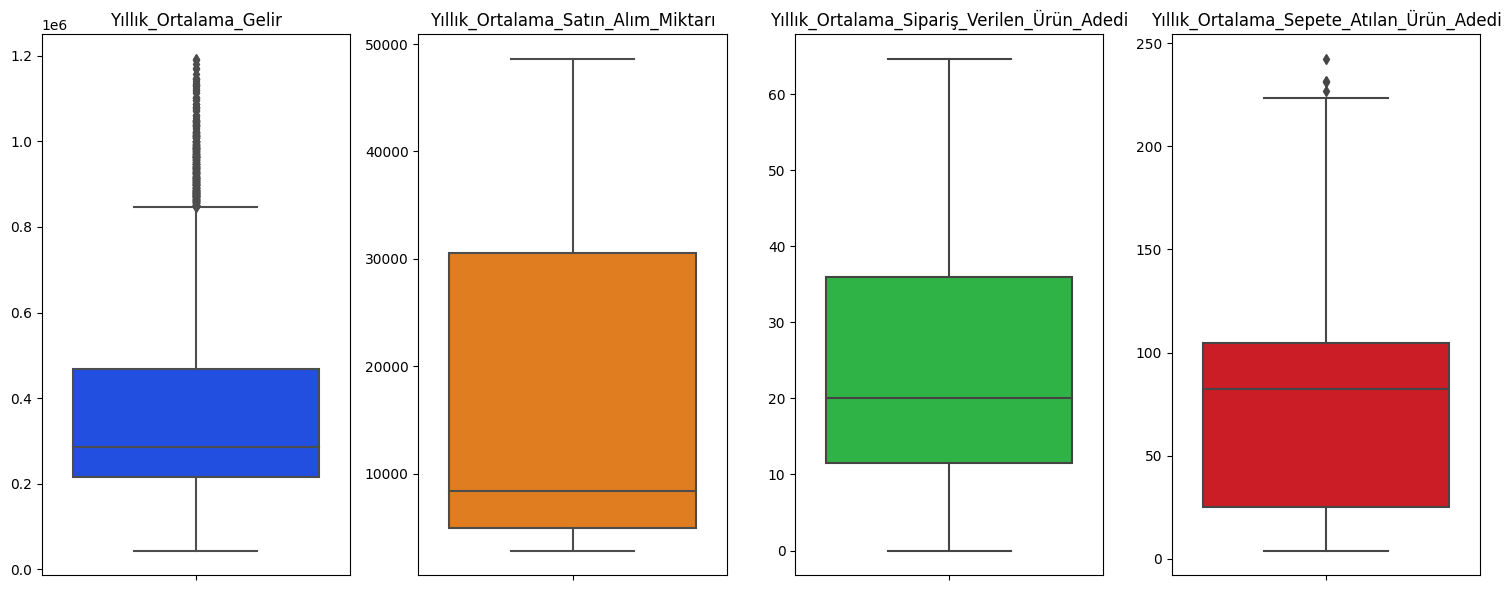

In [16]:
numeric_variables_boxplot(train, num_cols)

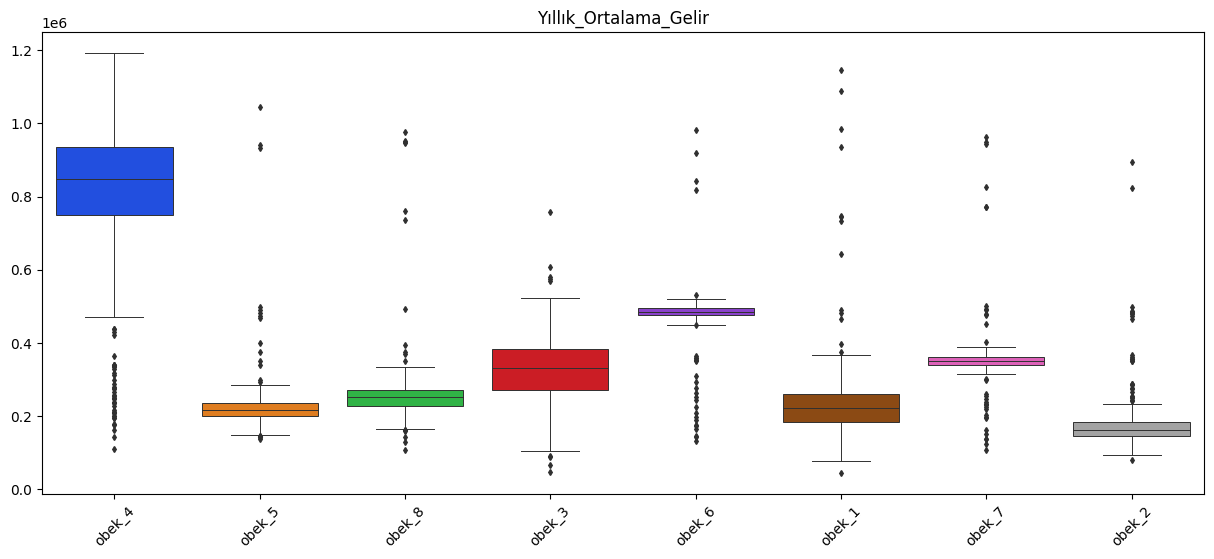

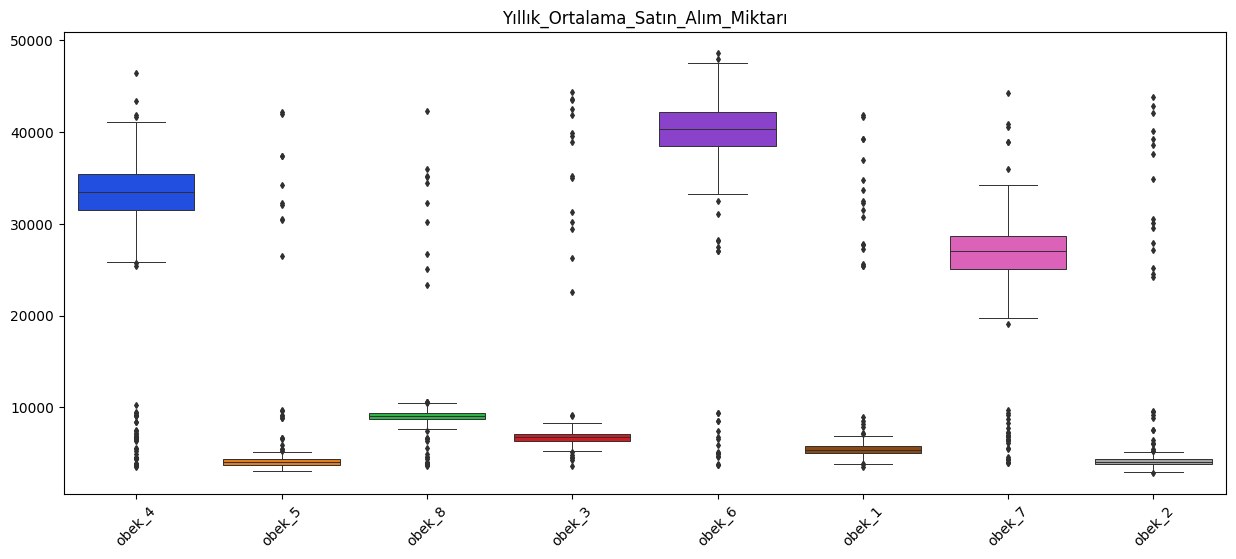

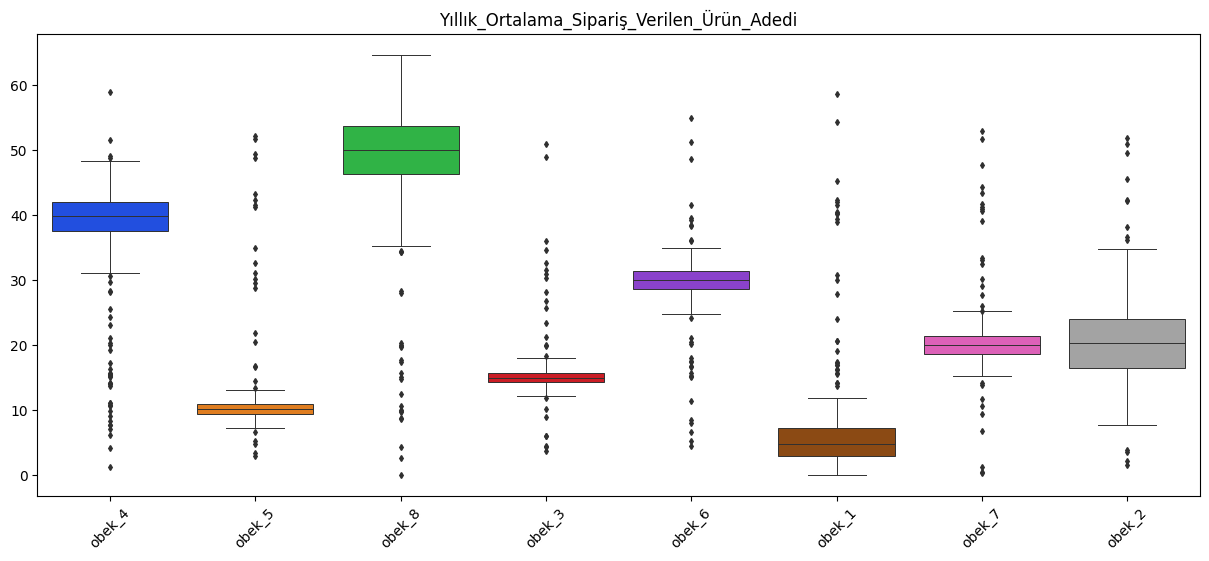

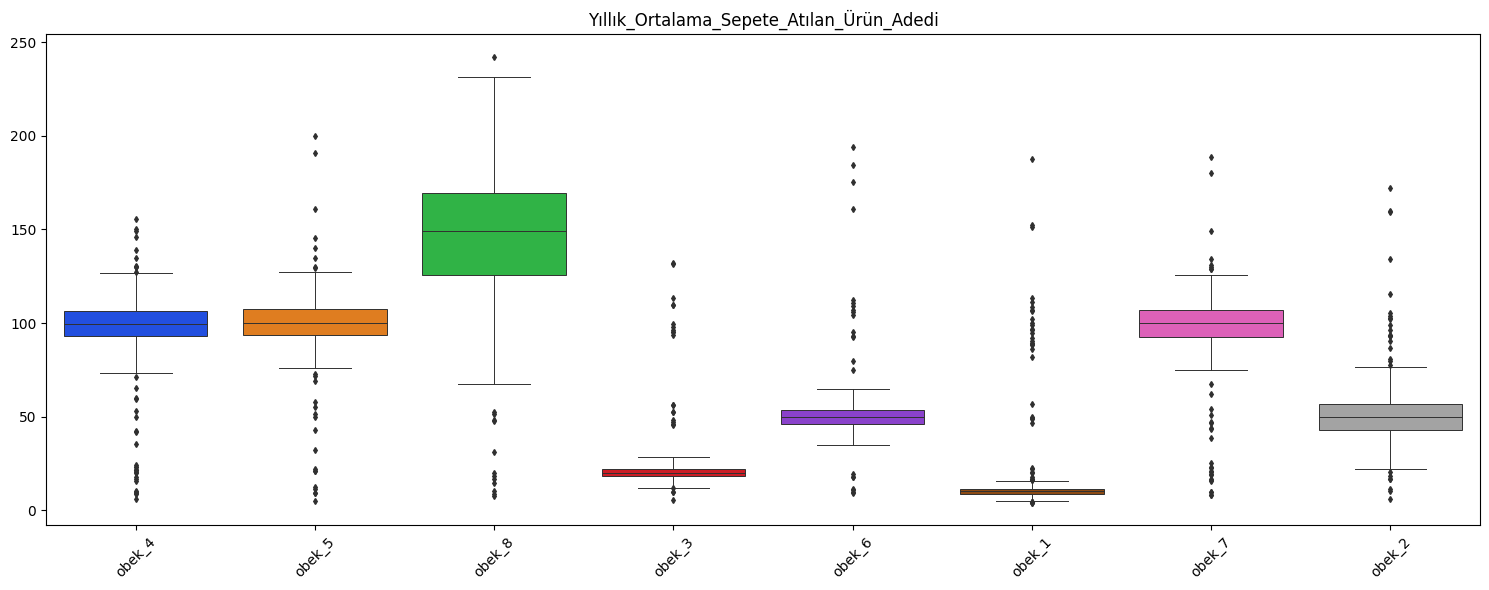

In [17]:
numeric_variables_boxplot(train, num_cols, target=target)

* __Kutu grafiklerinde aykırı değerler görünse de bilgi kaybetmemek adına şimdilik dokunmayacağım, ileride kullanılacak kompleks modeller zaten yüksek oranda baş edebiliyor aykırı değerler ile.__

## 2.2. Çok Değişkenli İnceleme <a id="2.2."></a>


### 2.2.1. Sayısal Değişkenler ve Hedef Değişkeni Arasında - 3 boyutlu <a id="2.2.1."></a>

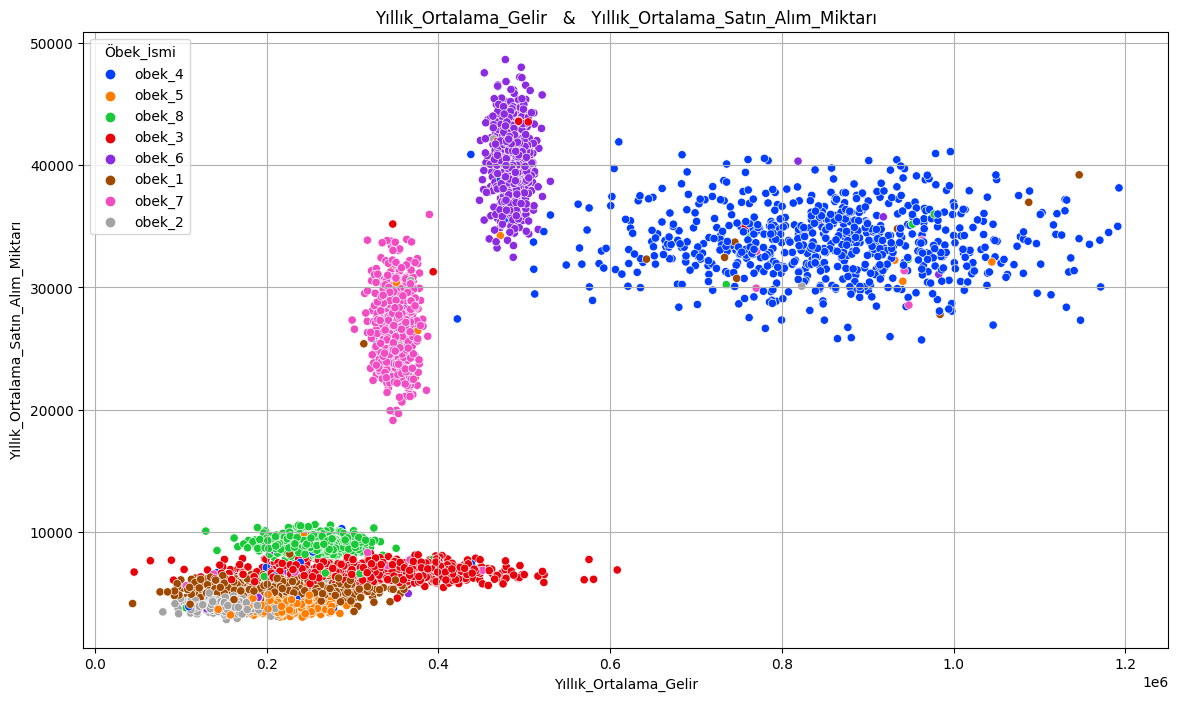

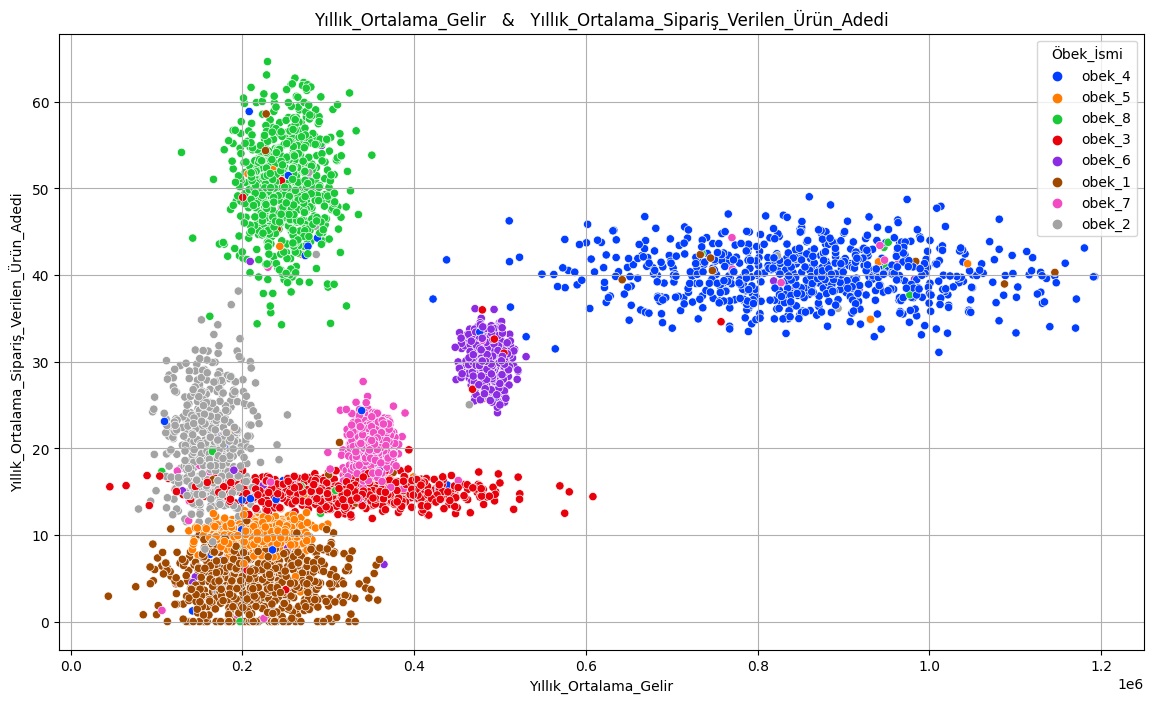

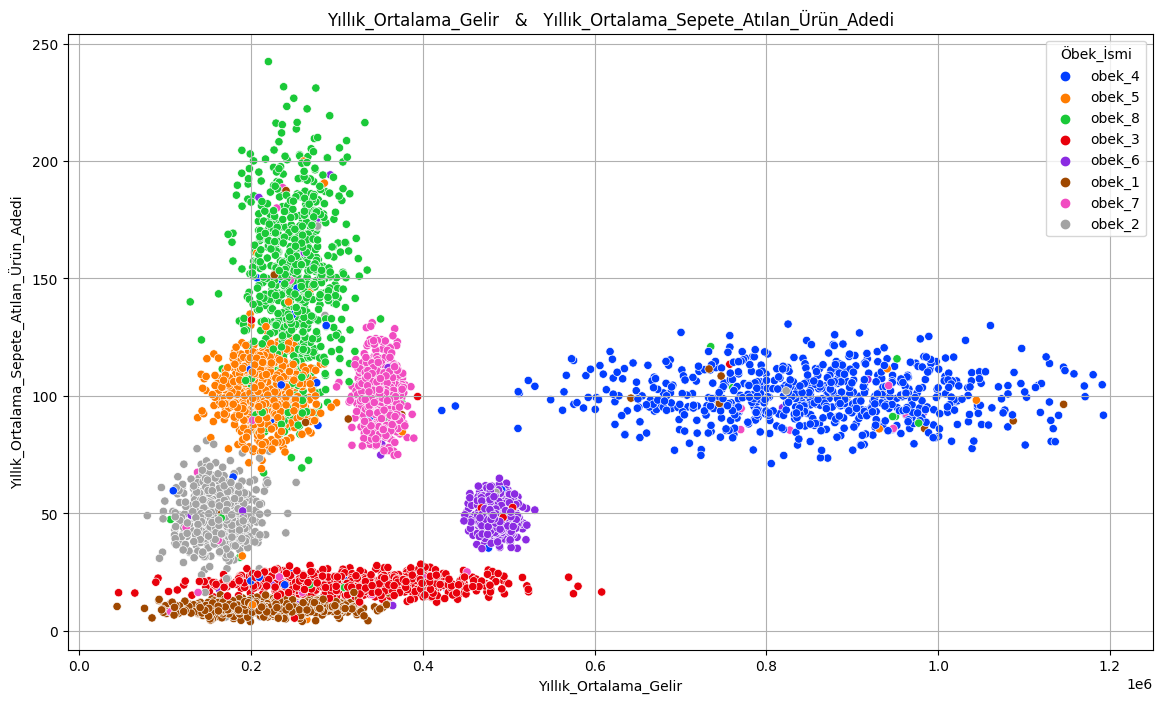

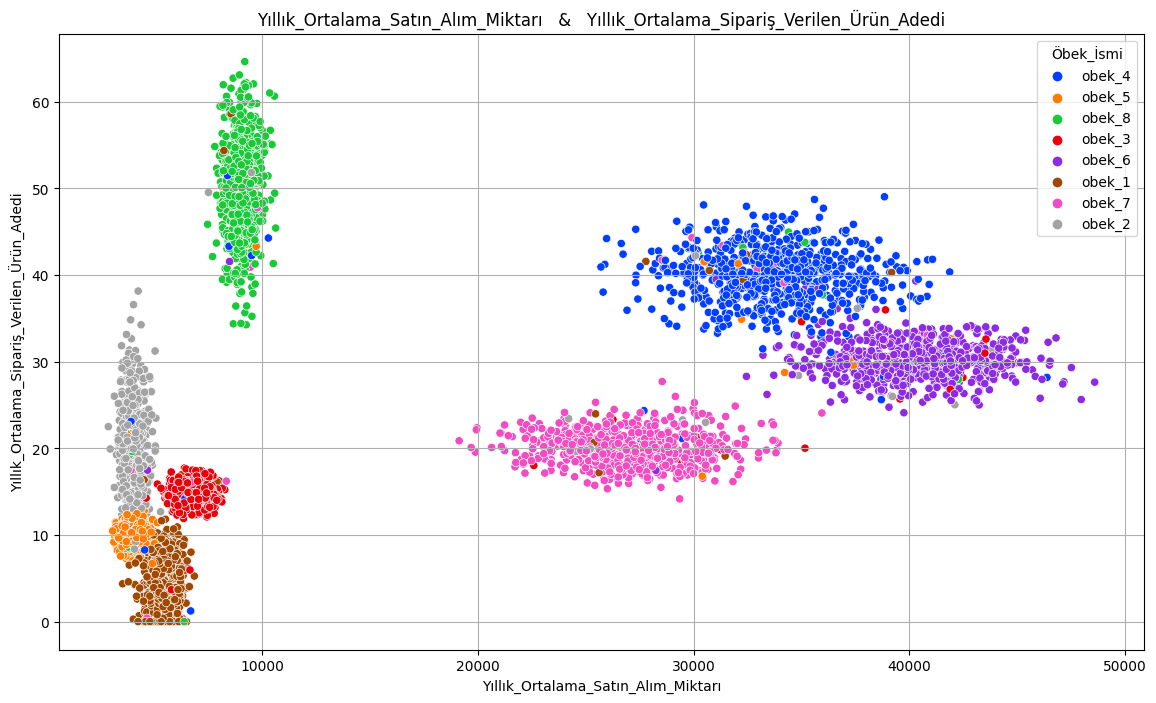

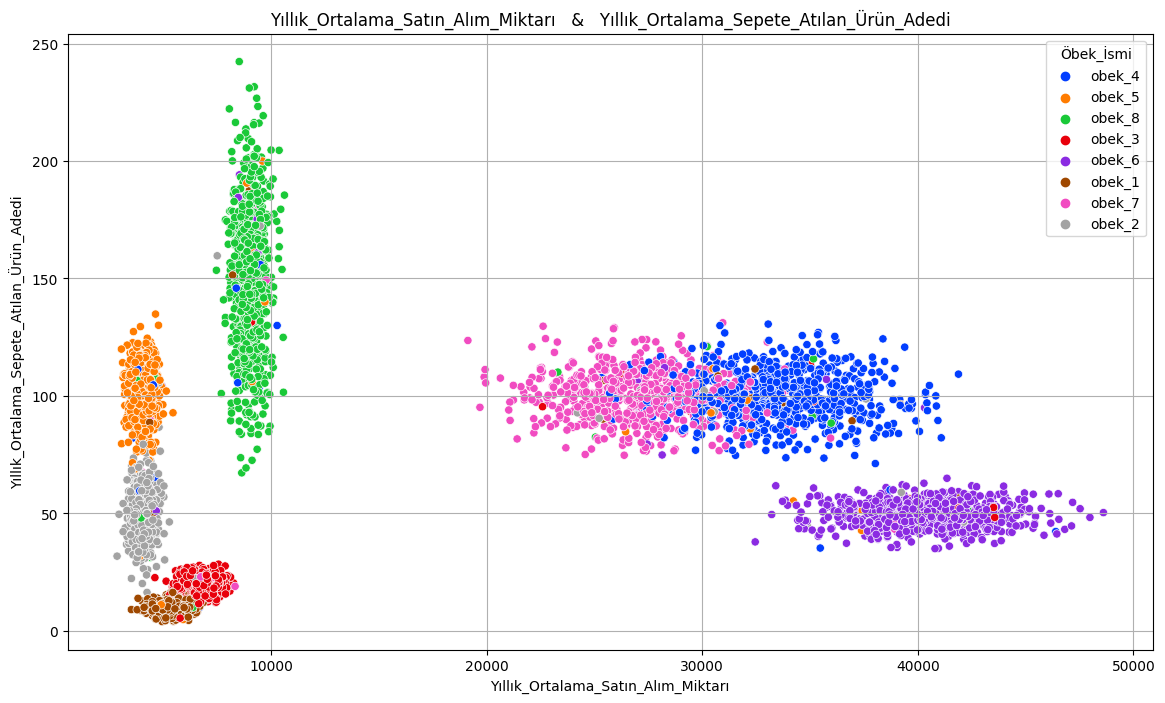

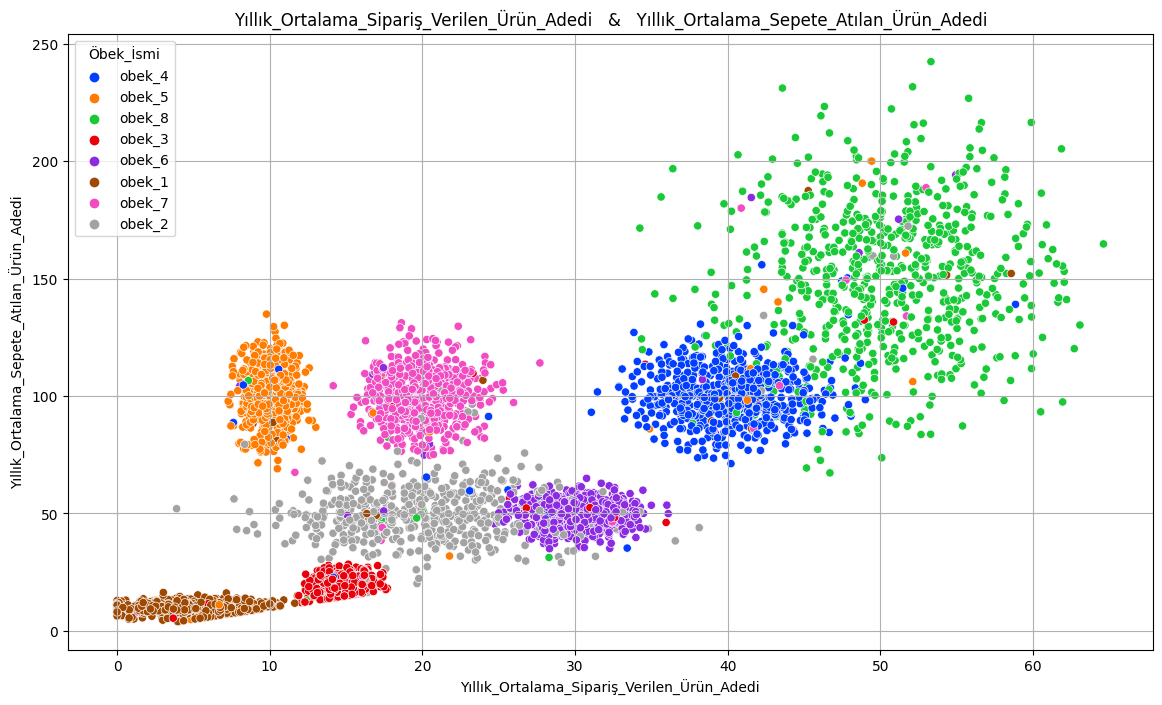

In [18]:
numcols_target_corr(train)

### 2.2.2. Hedefe Göre Sayısal Değişkenlerin İstatistikleri <a id="2.2.2."></a>

__Ortalama__

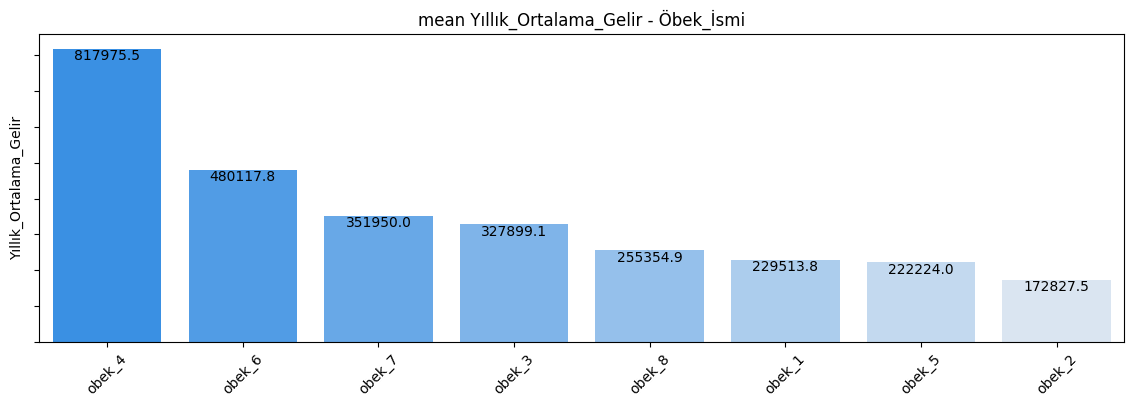

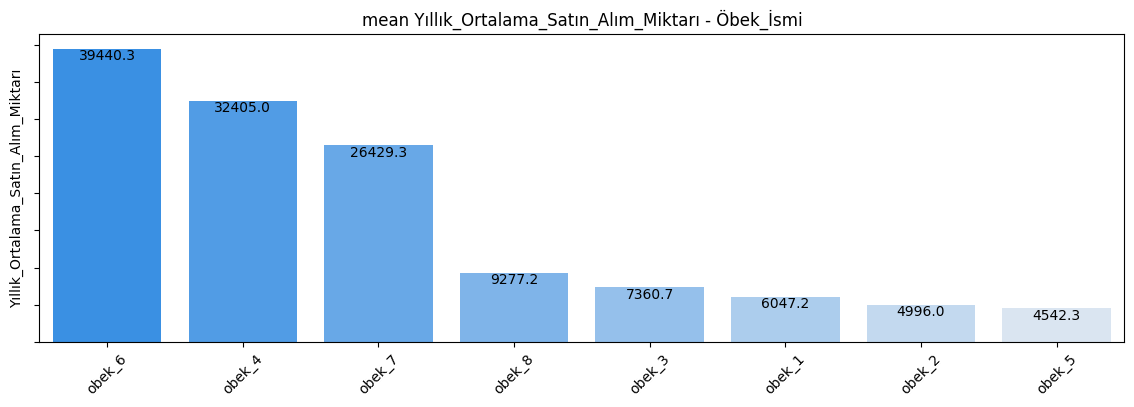

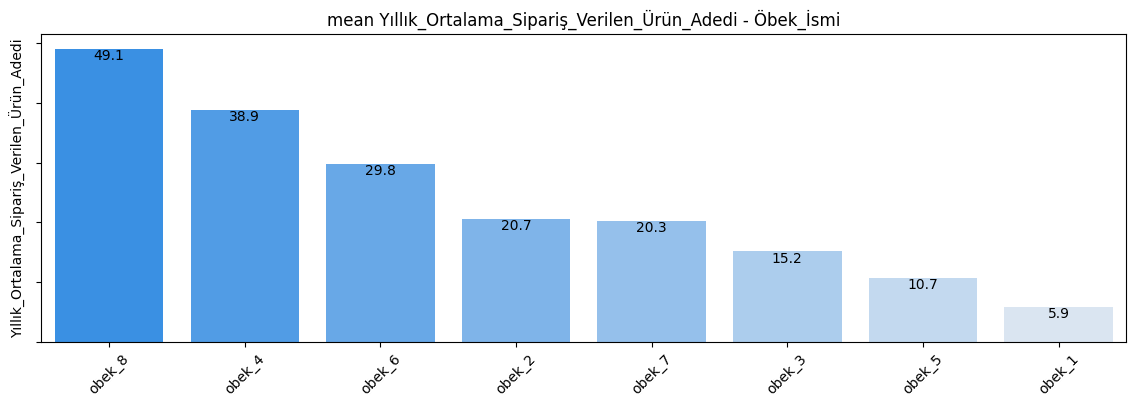

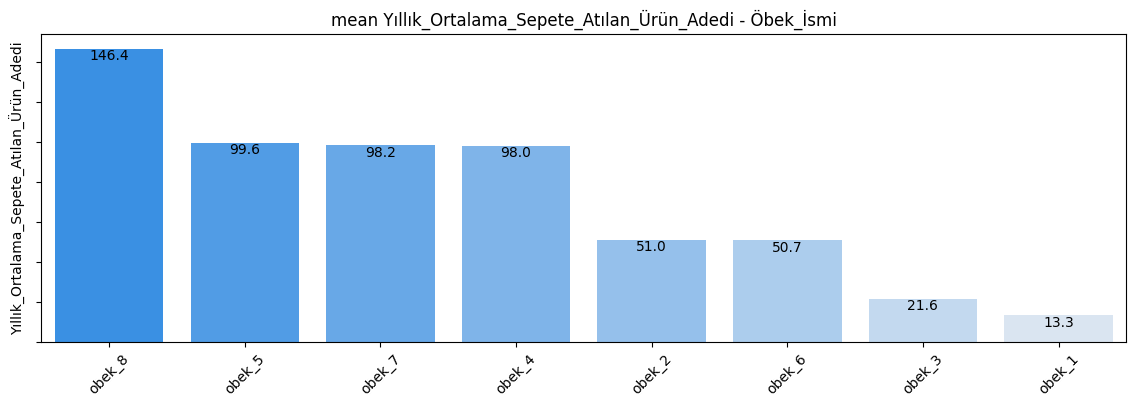

In [19]:
plot_avg_numvars_by_target(train, num_cols)

__Minimum__

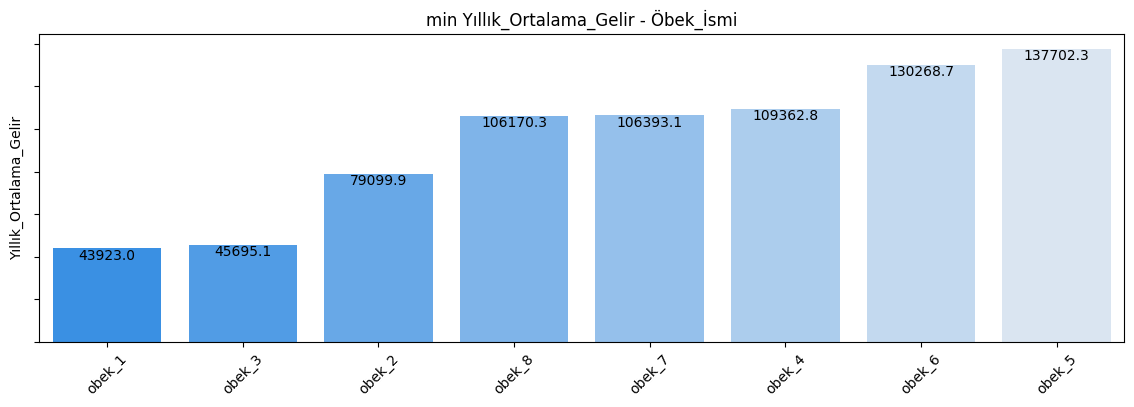

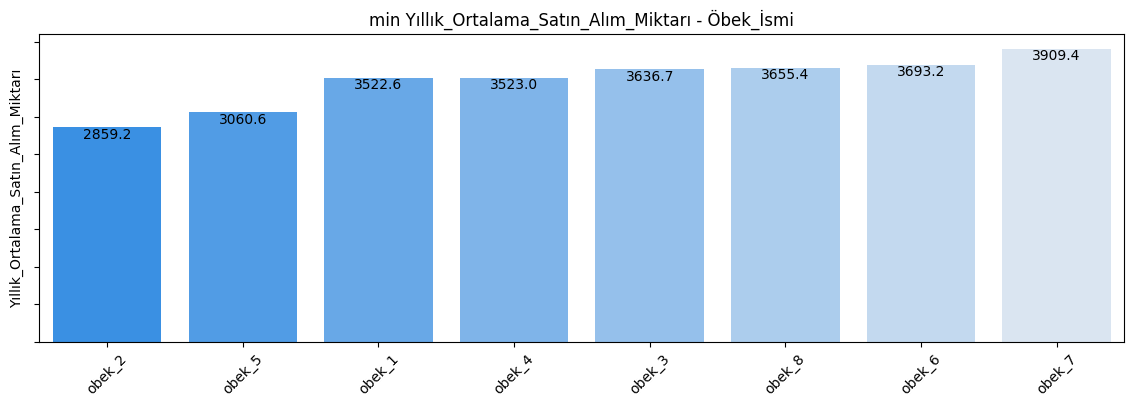

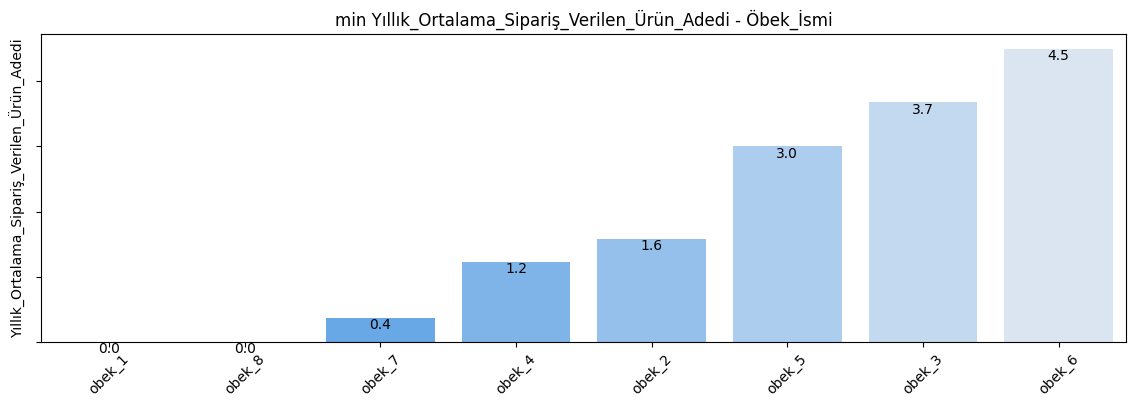

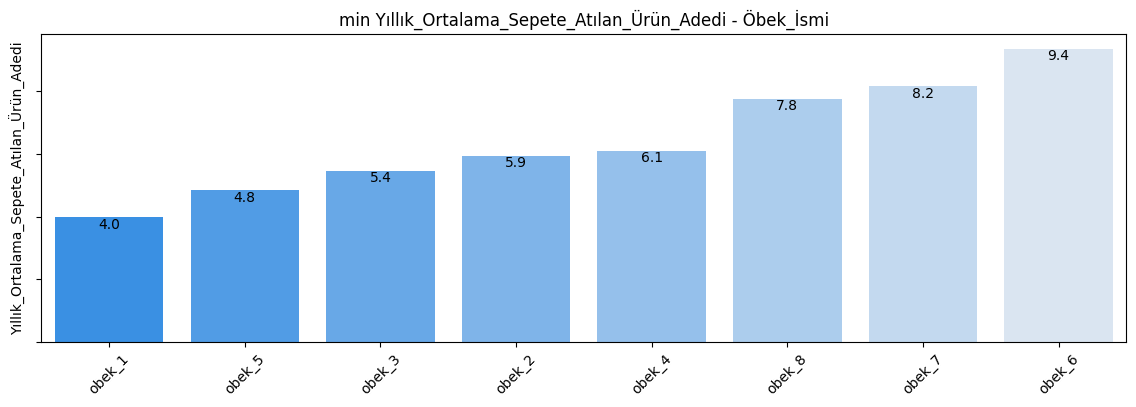

In [20]:
plot_avg_numvars_by_target(train,num_cols,'min')

__Maksimum__

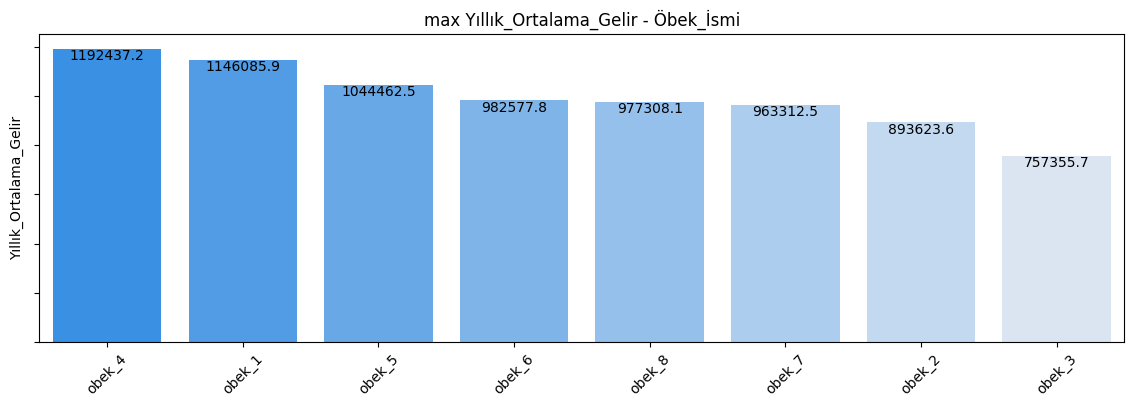

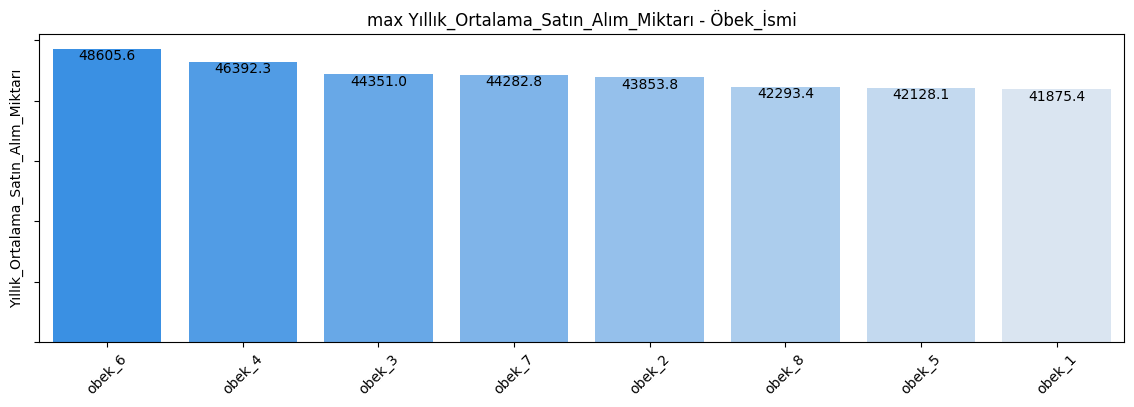

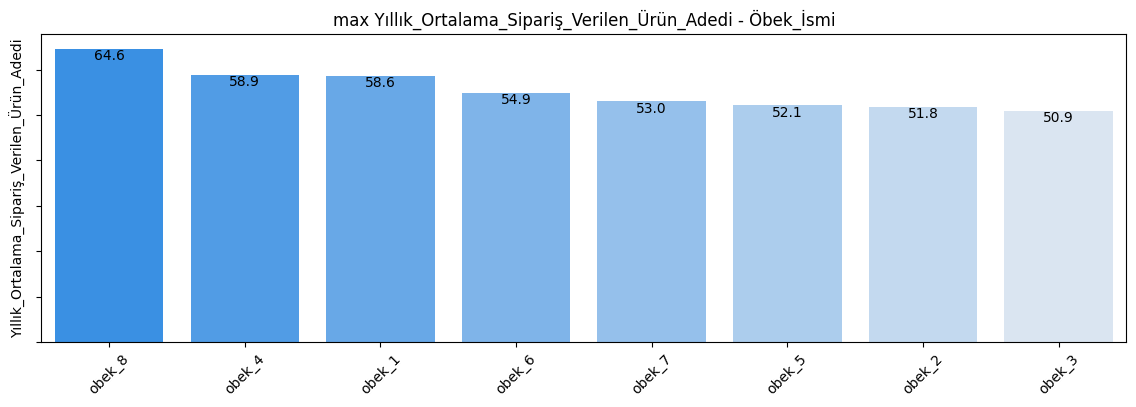

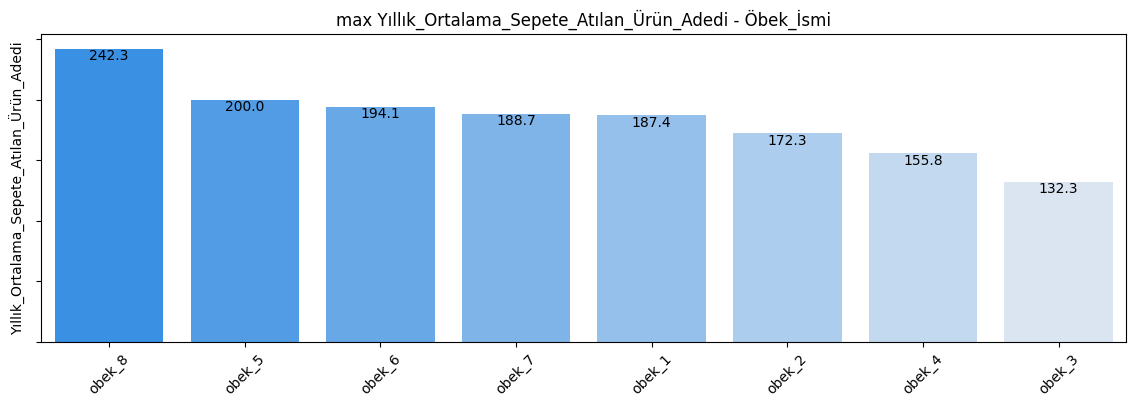

In [21]:
plot_avg_numvars_by_target(train,num_cols,'max')

__Toplam__

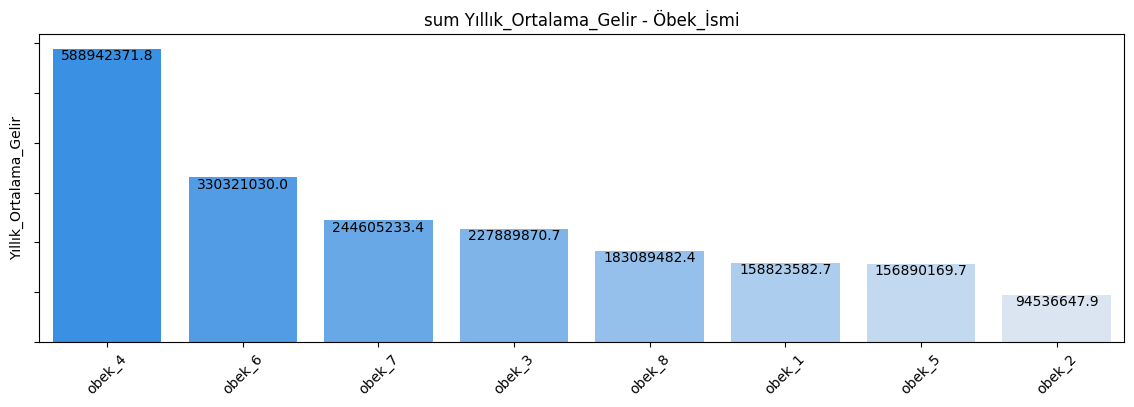

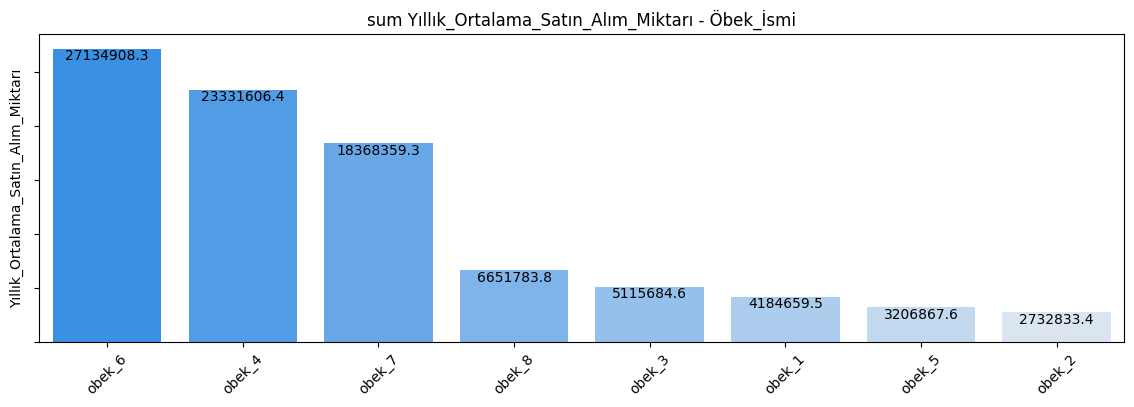

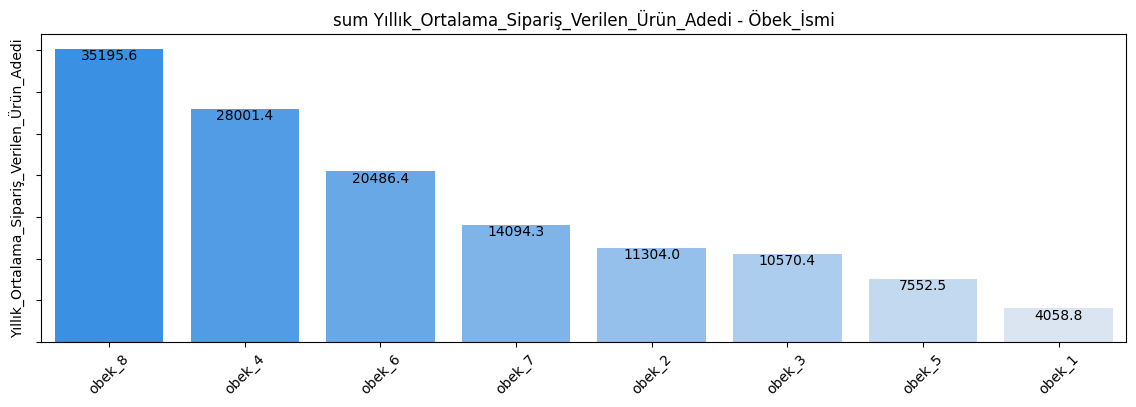

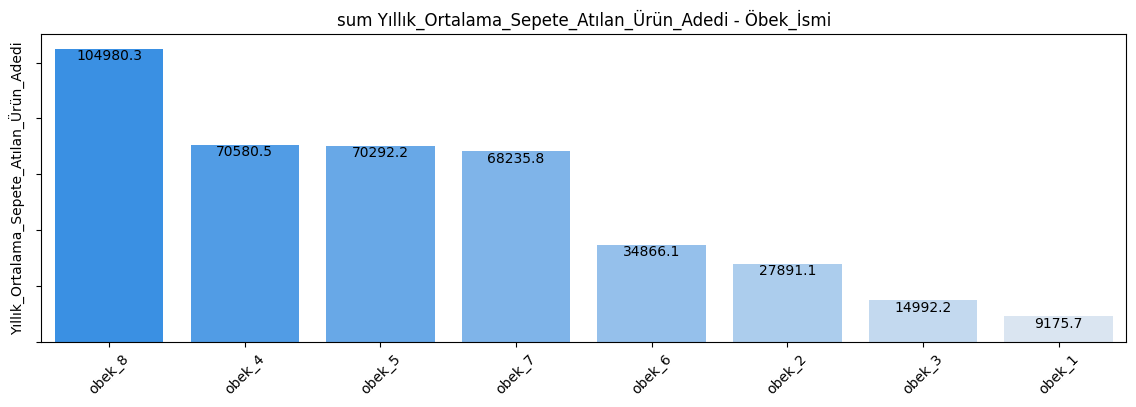

In [22]:
plot_avg_numvars_by_target(train,num_cols,'sum')

### 2.2.3. Hedefe Göre Sayısal Değişkenlerin İstatistikleri - Üretilen Sayısal Değişkenler İçin <a id="2.2.3."></a>




__Sayısal değişkenlerin kendi arasındaki ilişkilerden ve öbekleri ayırt ediciliğinden yola çıkarak, oluşacak yeni sayısal değişkenler:__

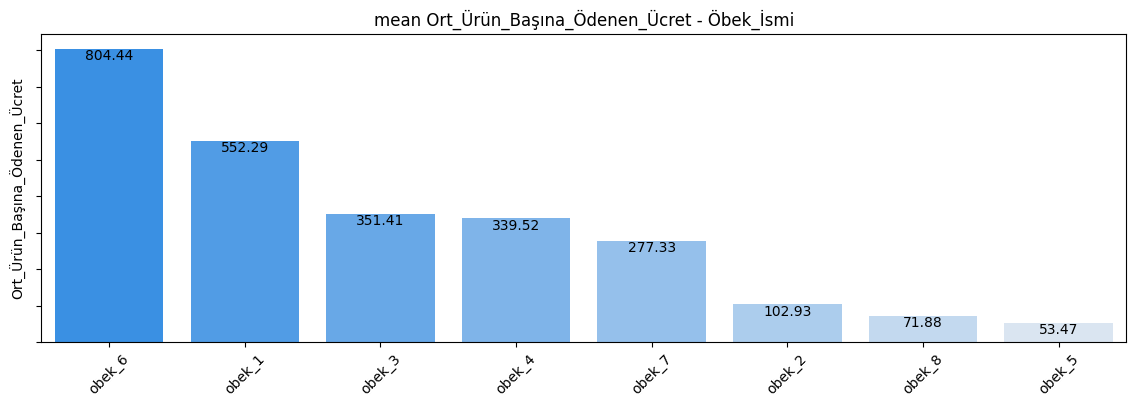

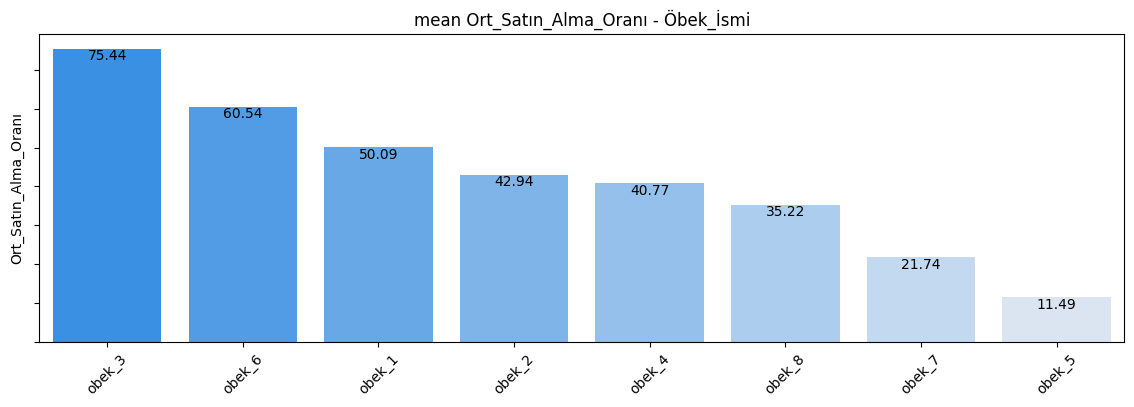

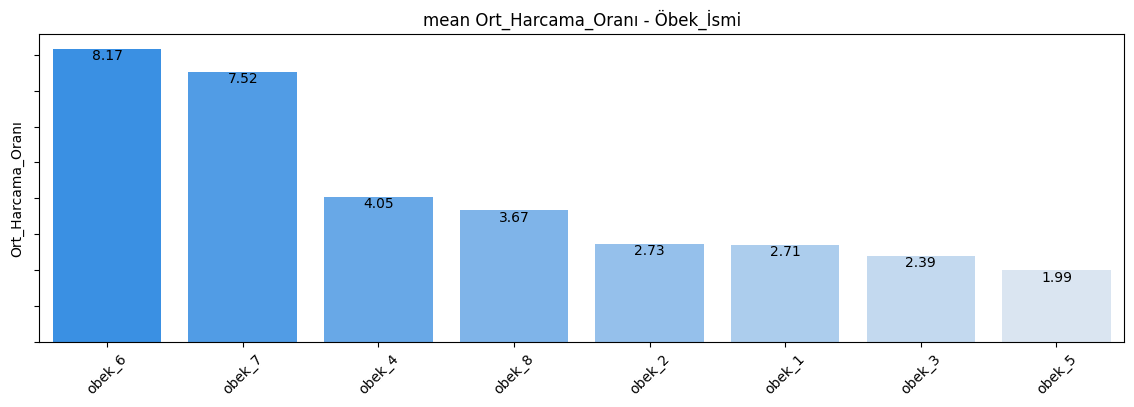

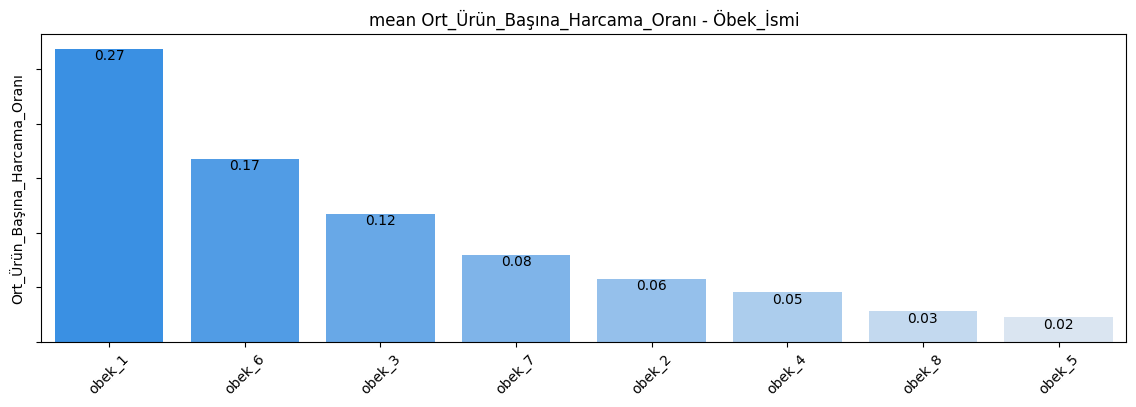

In [115]:
def get_num_features(df):
    
    df['Ort_Ürün_Başına_Ödenen_Ücret'] = df.Yıllık_Ortalama_Satın_Alım_Miktarı/df.Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi
    df['Ort_Satın_Alma_Oranı'] = (df.Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi/df.Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi)*100
    df['Ort_Harcama_Oranı'] = (df.Yıllık_Ortalama_Satın_Alım_Miktarı/df.Yıllık_Ortalama_Gelir)*100
    df['Ort_Ürün_Başına_Harcama_Oranı'] = (df.Ort_Ürün_Başına_Ödenen_Ücret/df.Yıllık_Ortalama_Gelir)*100


train_num = train[num_cols+[target]]
get_num_features(train_num)
new_num_feats = train_num.columns[5:]

plot_avg_numvars_by_target(train_num,new_num_feats ,'mean', round_ndigits=2)

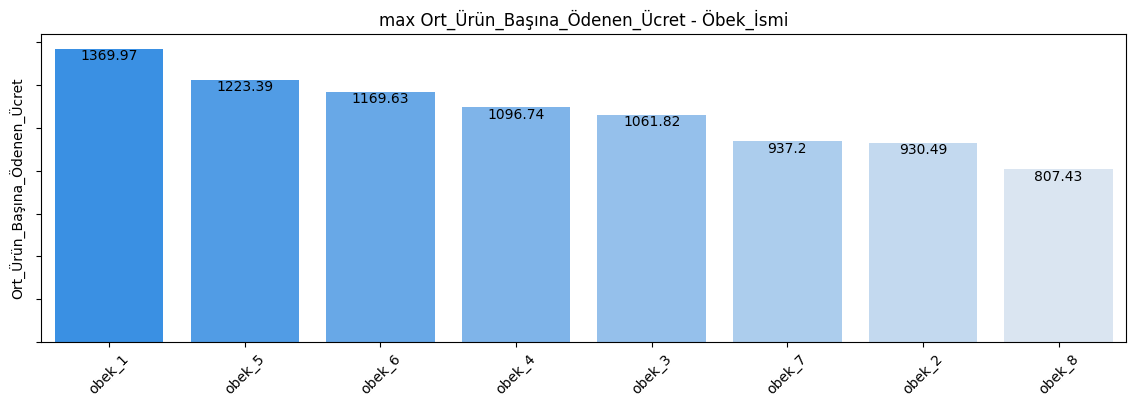

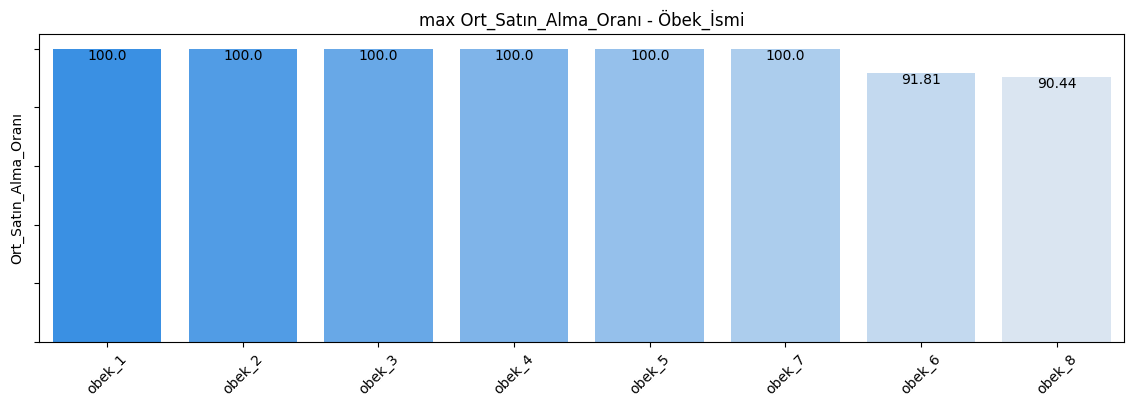

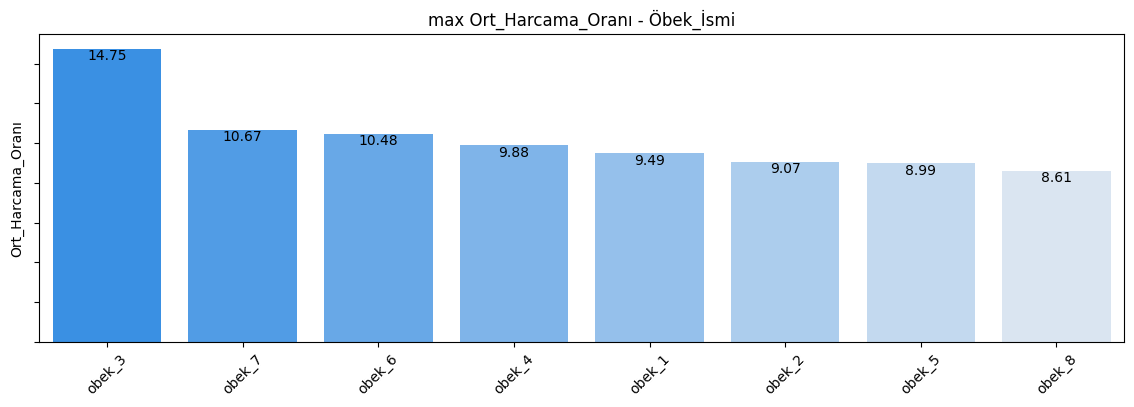

In [24]:
plot_avg_numvars_by_target(train_num,new_num_feats ,'max', round_ndigits=2)

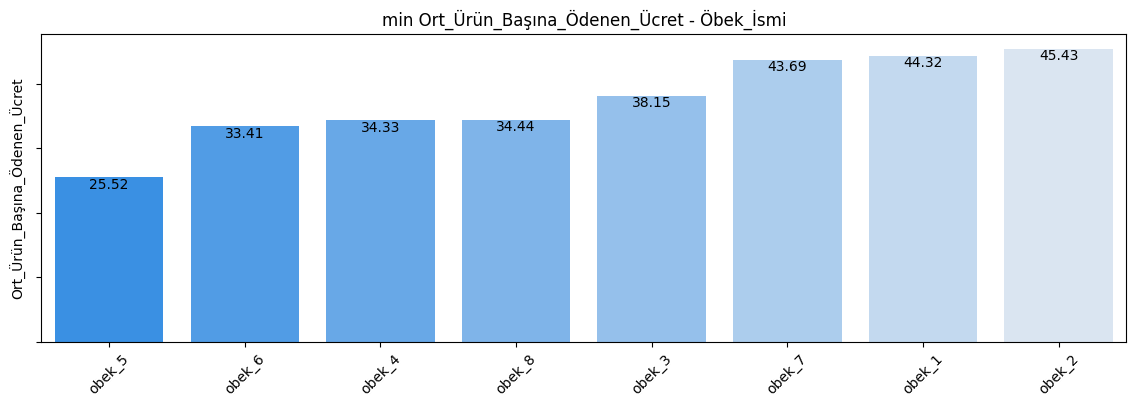

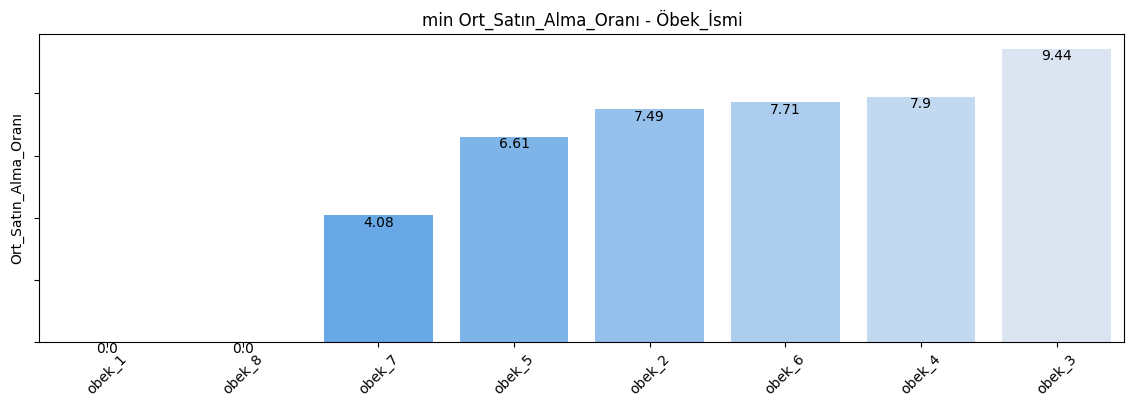

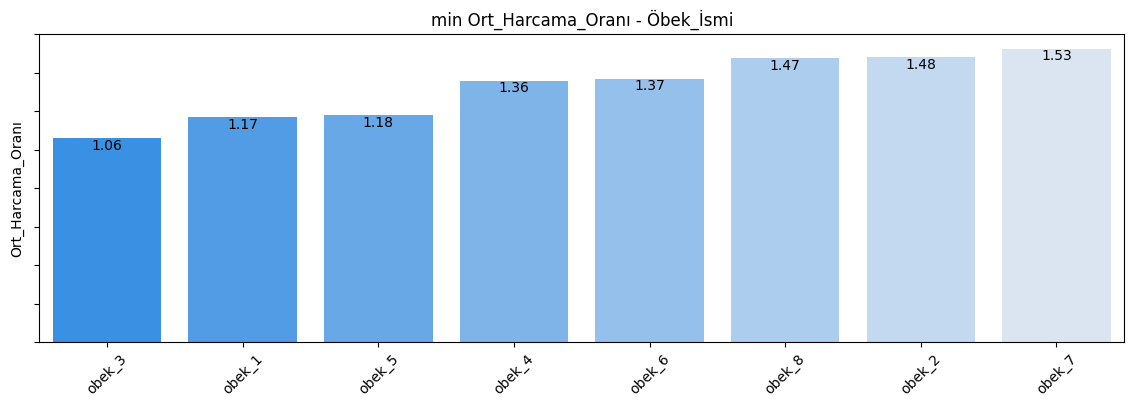

In [25]:
plot_avg_numvars_by_target(train_num,new_num_feats ,'min', round_ndigits=2)

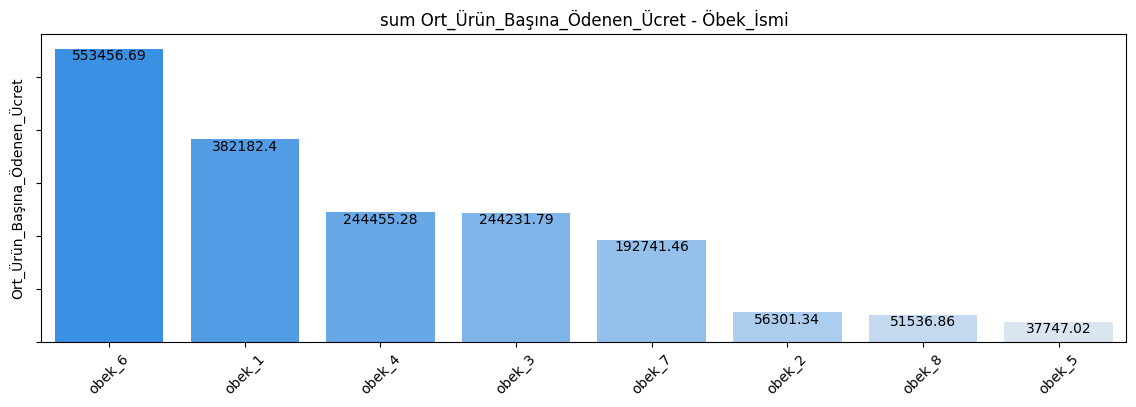

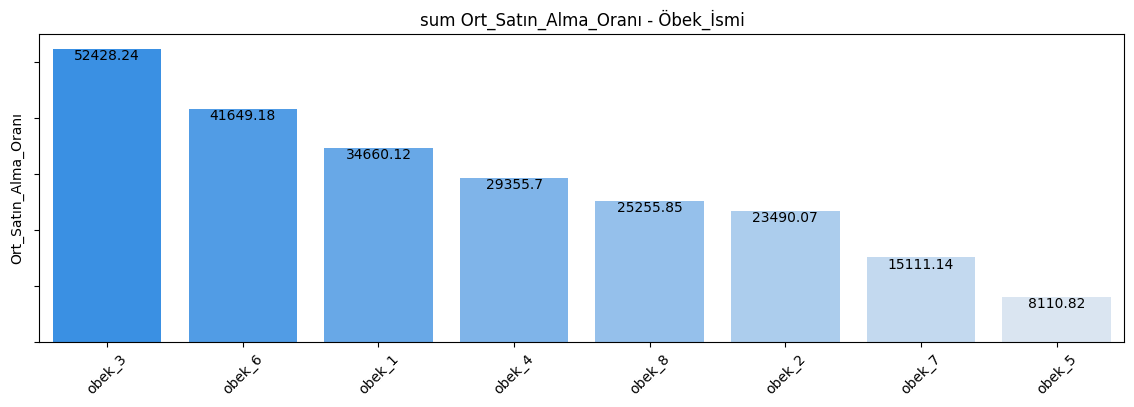

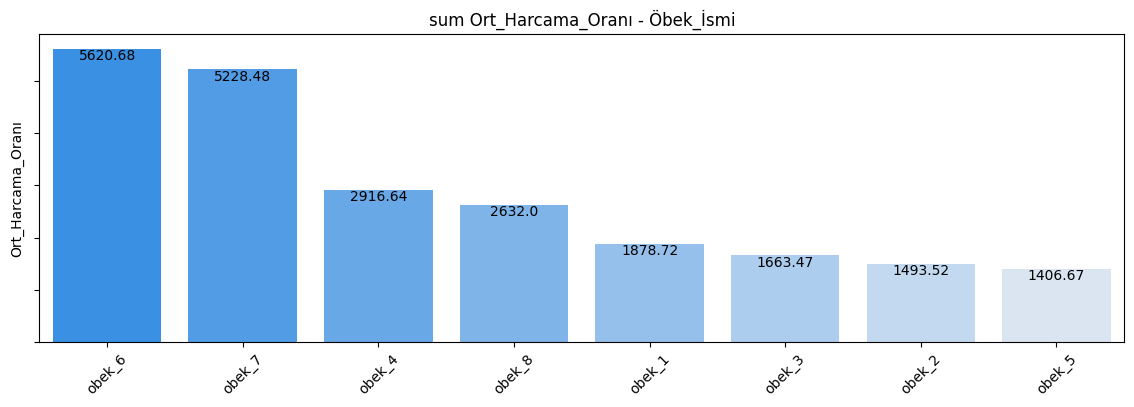

In [26]:
plot_avg_numvars_by_target(train_num,new_num_feats,'sum', round_ndigits=2)

### 2.2.4. Kategorik Değişkenlere Göre Sayısal Değişkenlerin İstatistikleri <a id="2.2.4."></a>

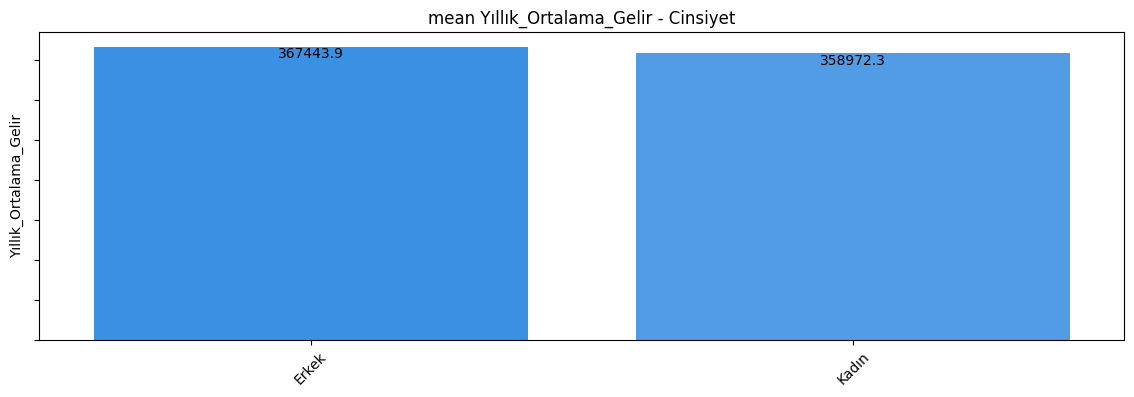

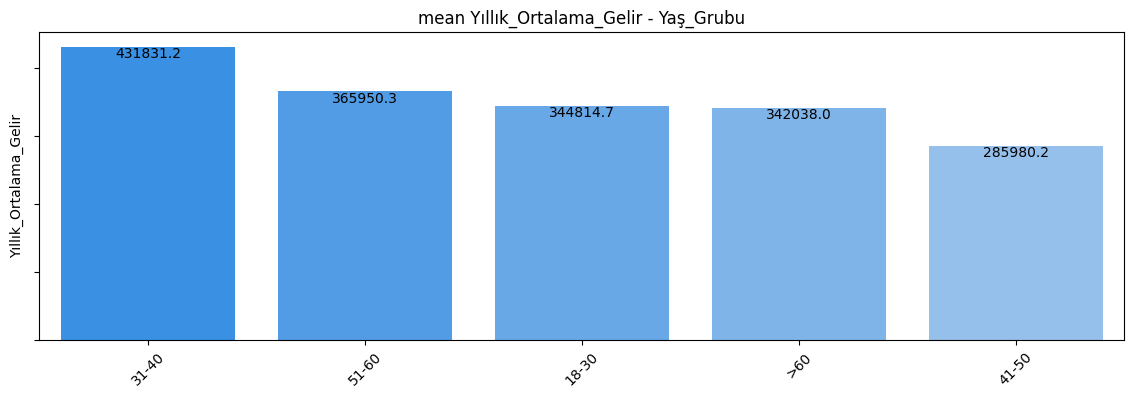

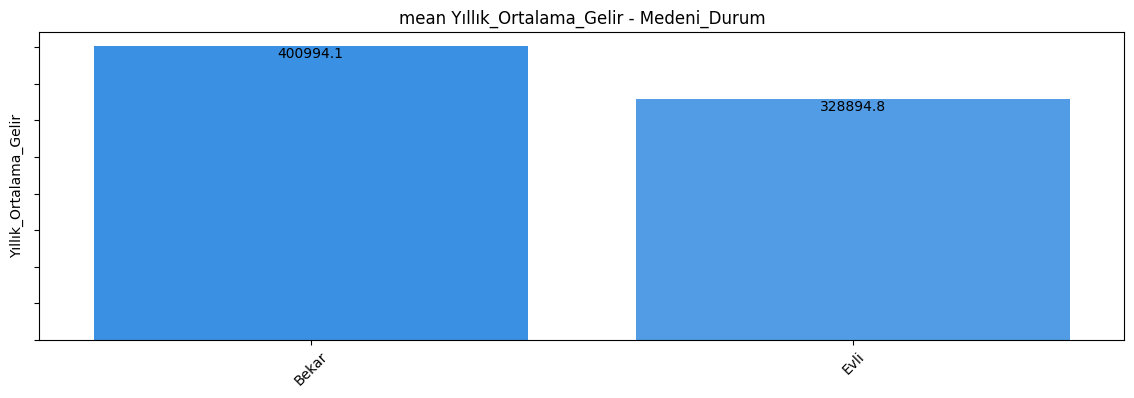

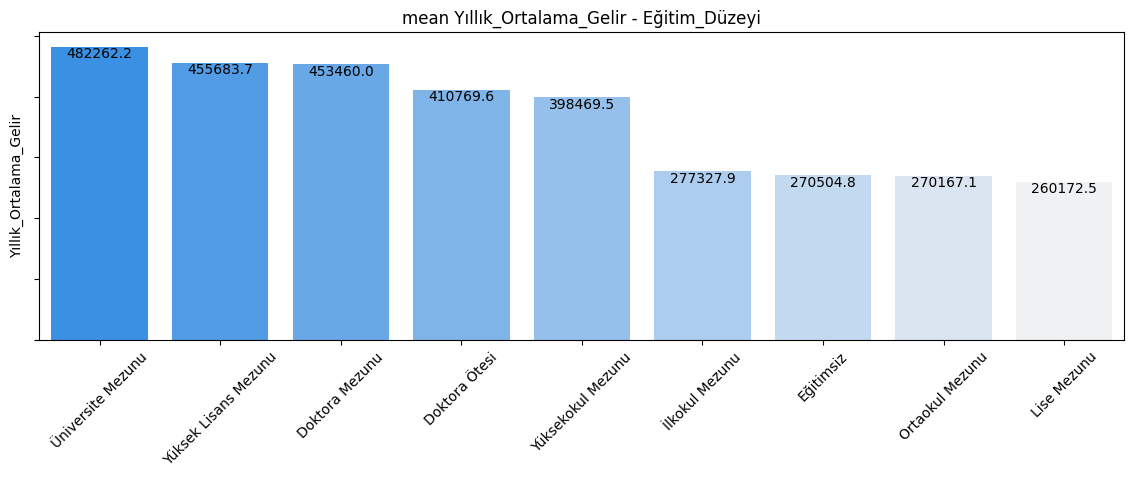

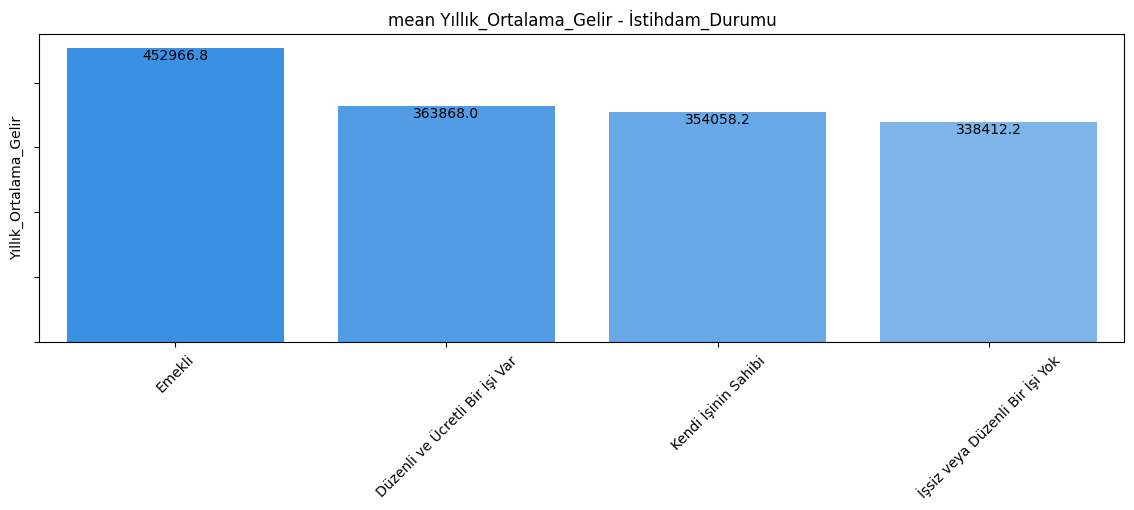

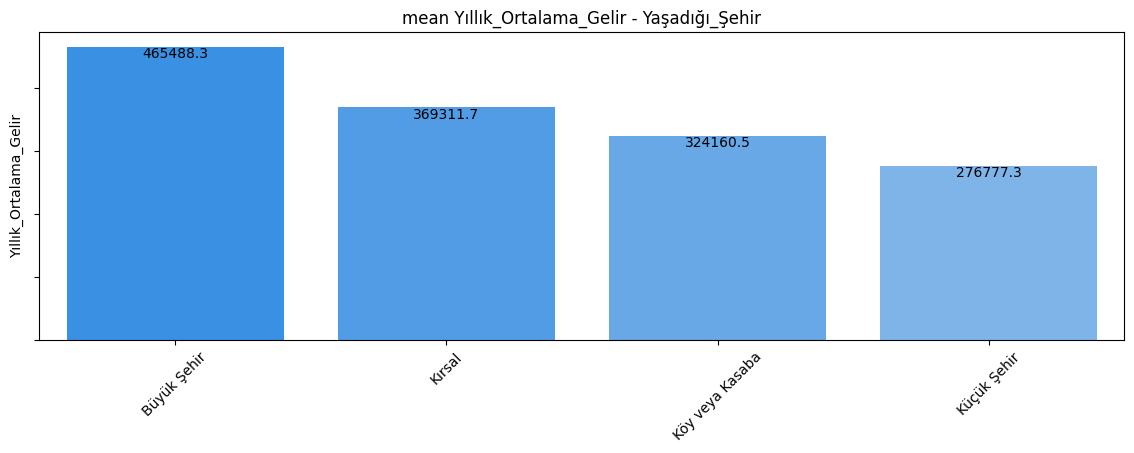

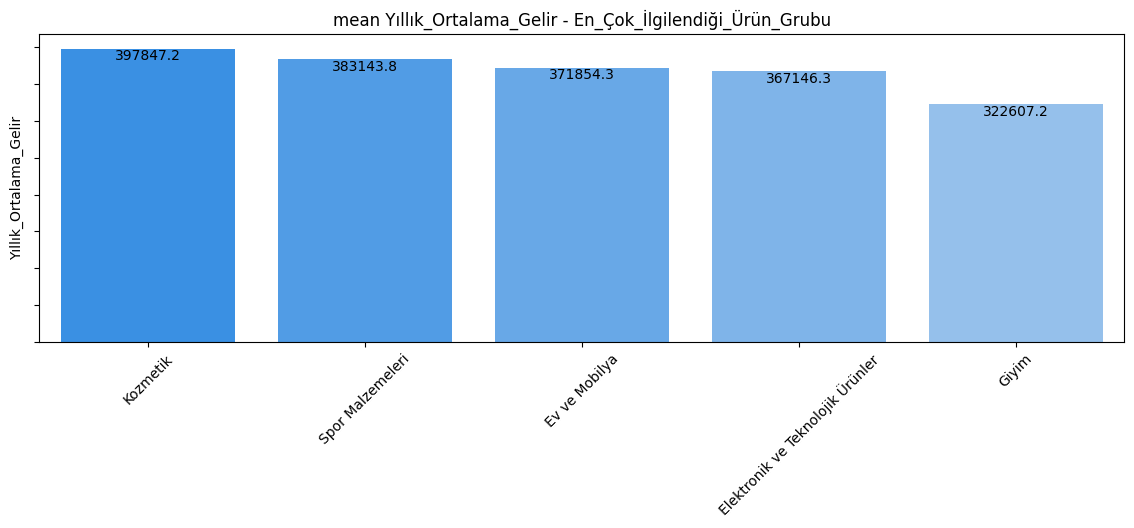

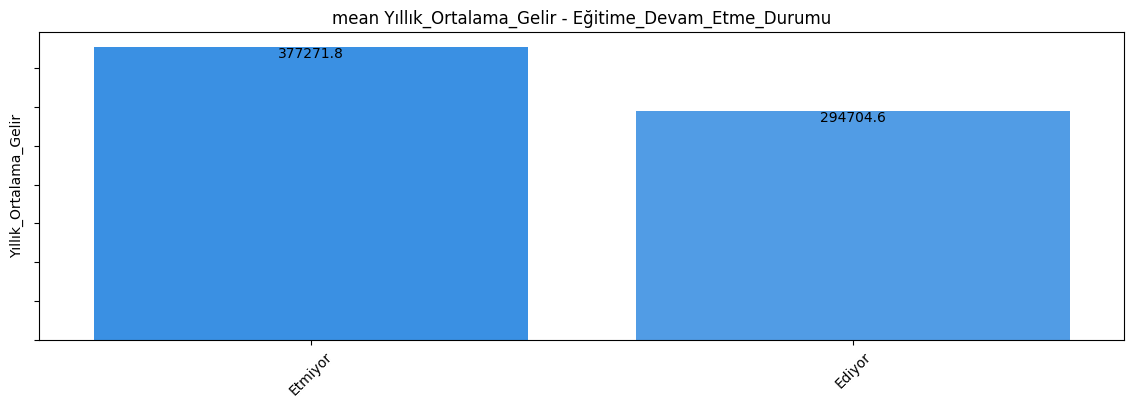

In [27]:
plot_avg_numvars_by_catvars(train,agg='mean', num_col='Yıllık_Ortalama_Gelir')

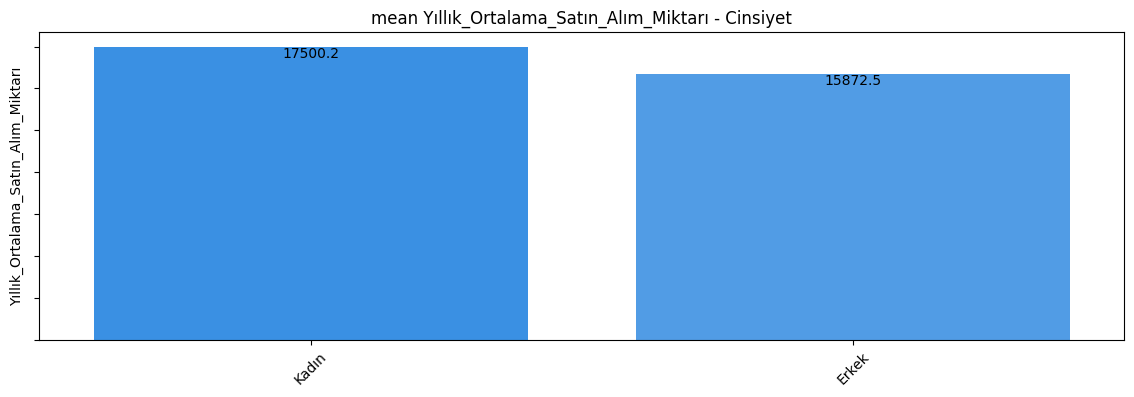

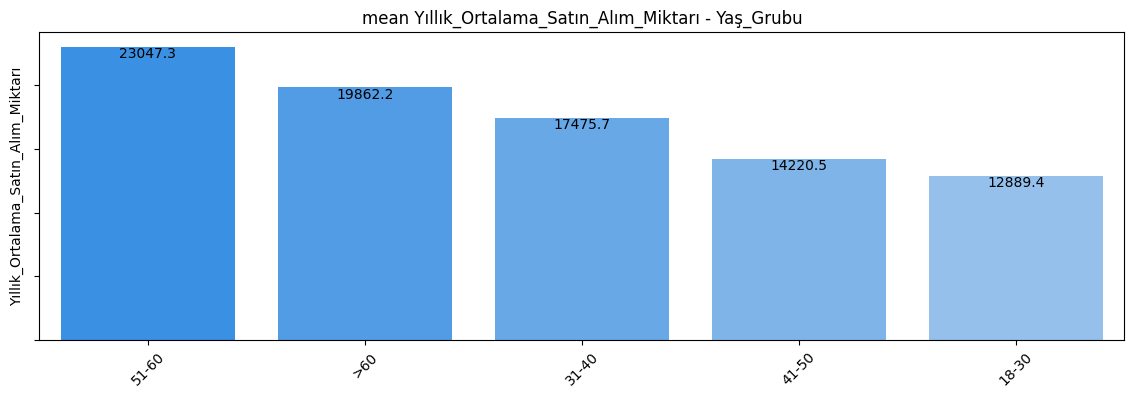

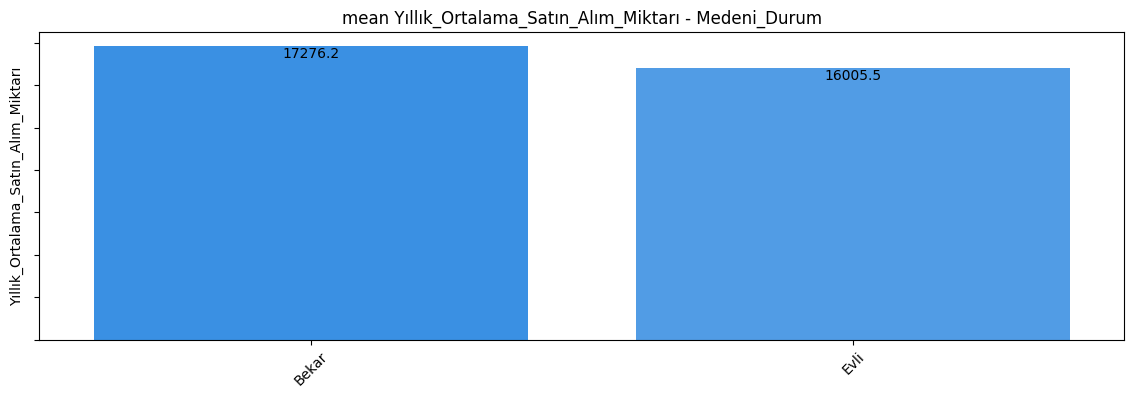

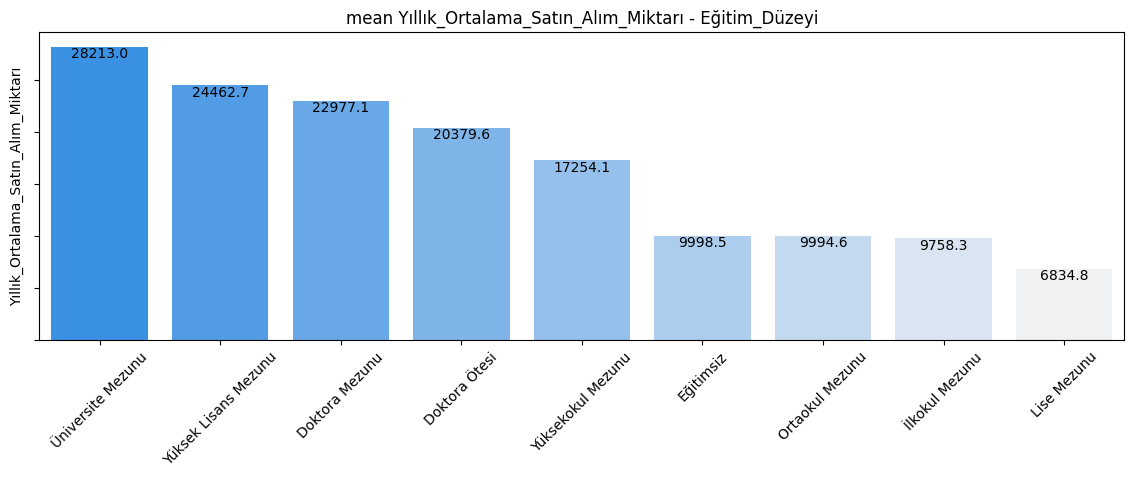

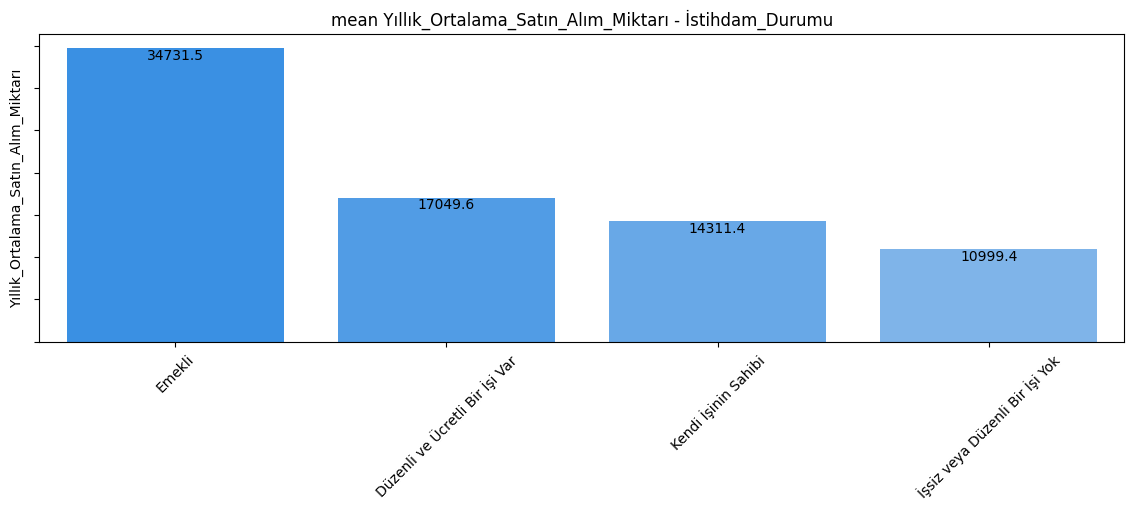

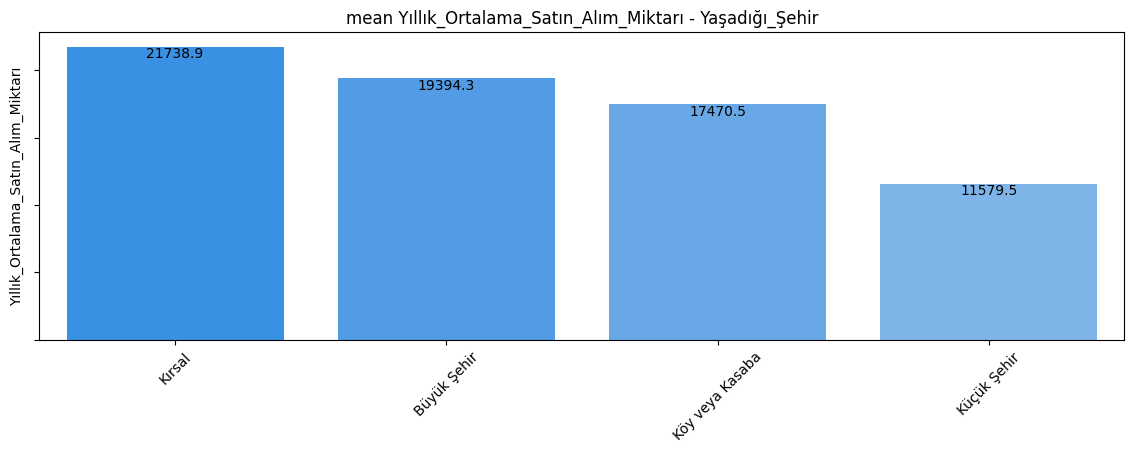

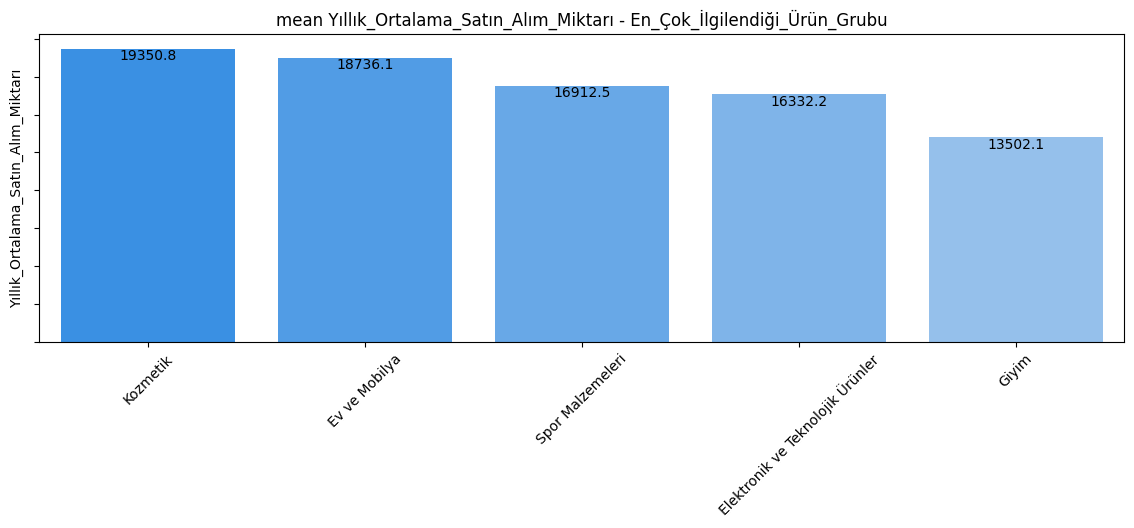

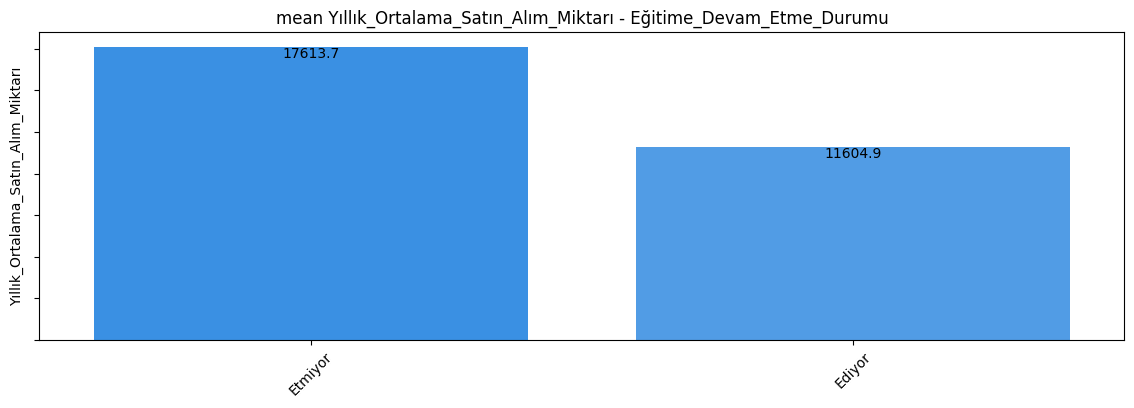

In [28]:
plot_avg_numvars_by_catvars(train,agg='mean', num_col='Yıllık_Ortalama_Satın_Alım_Miktarı')

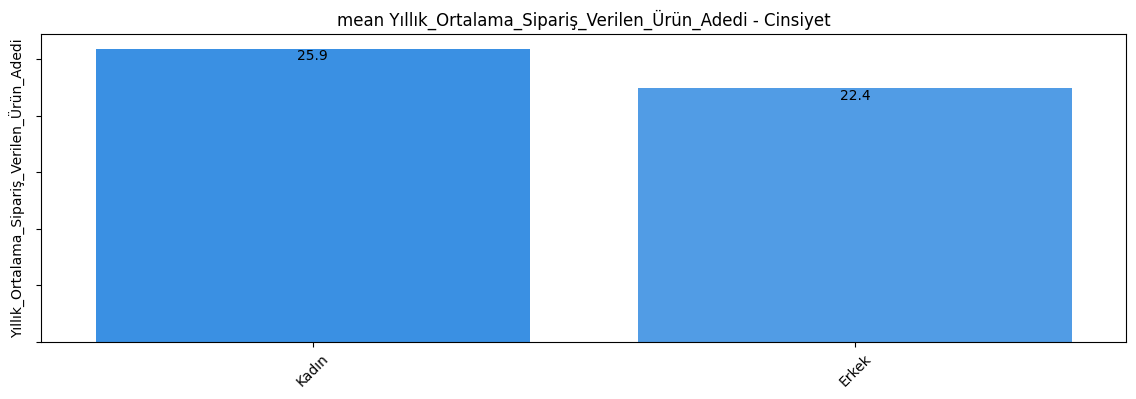

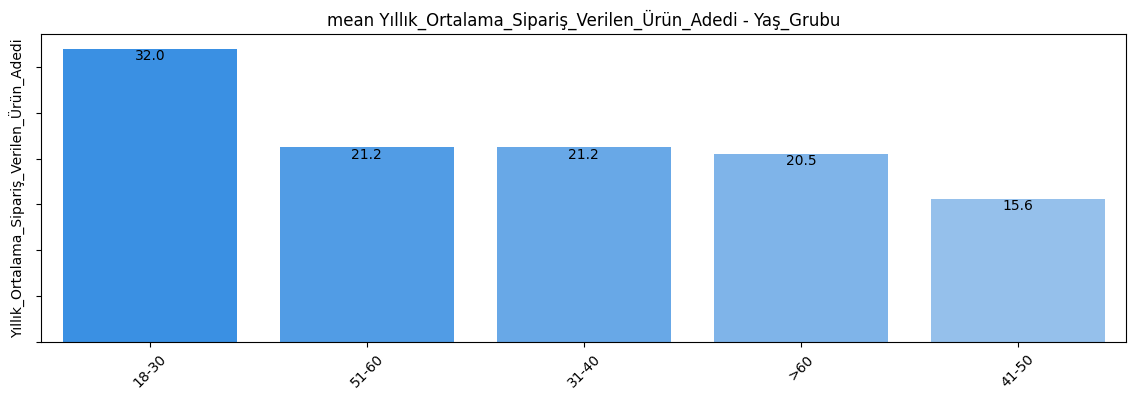

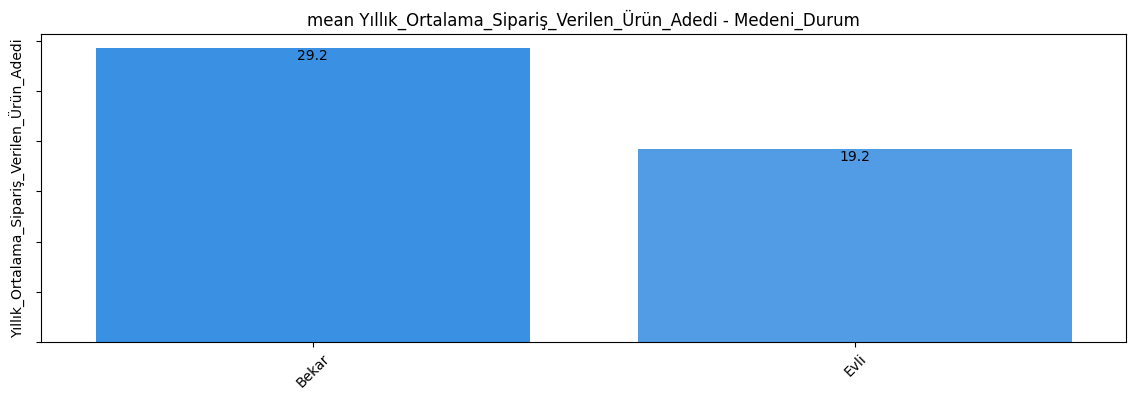

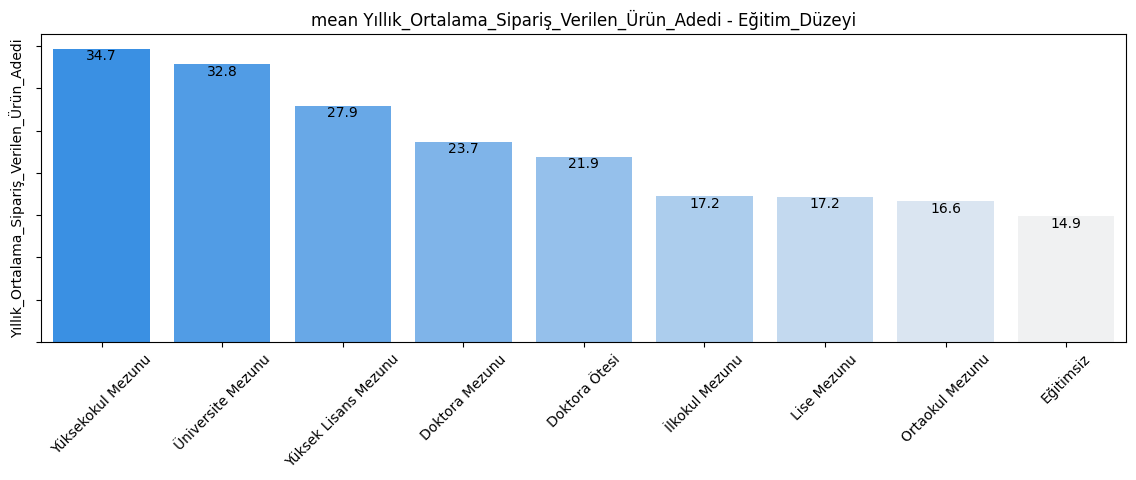

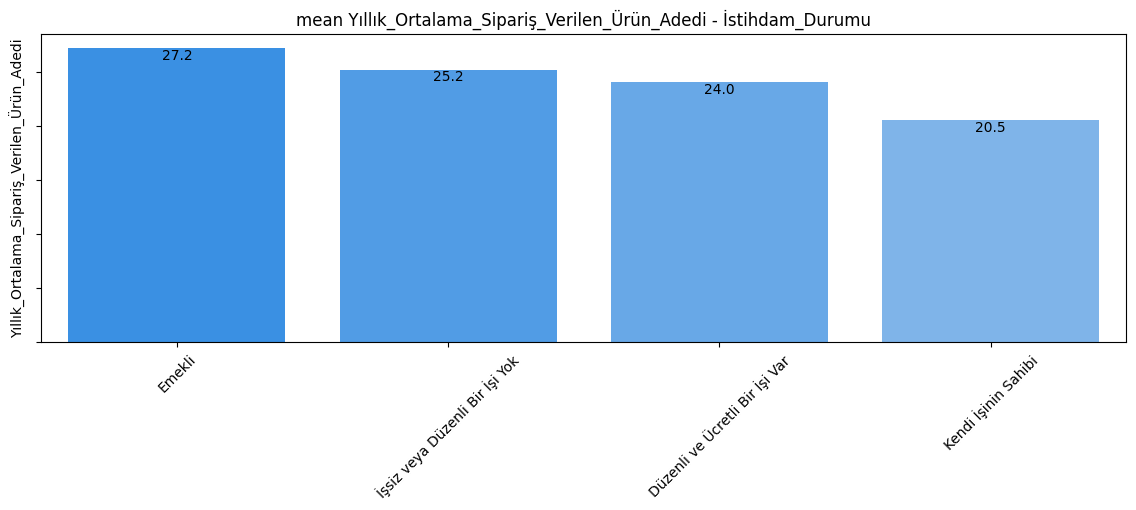

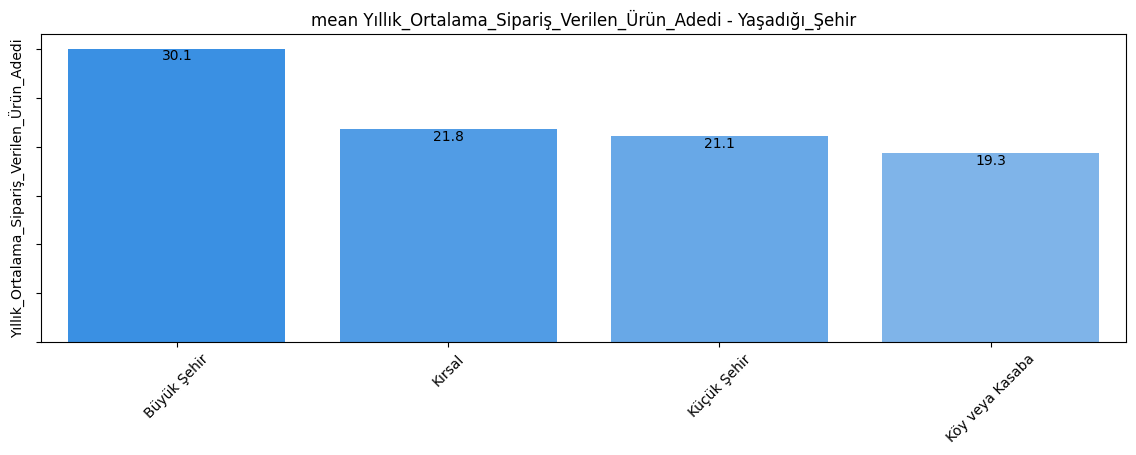

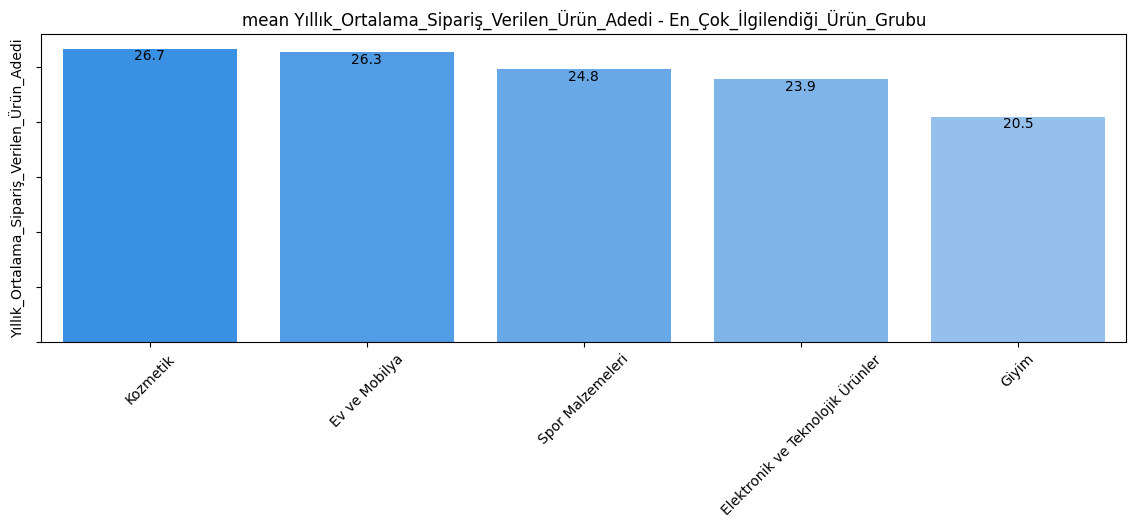

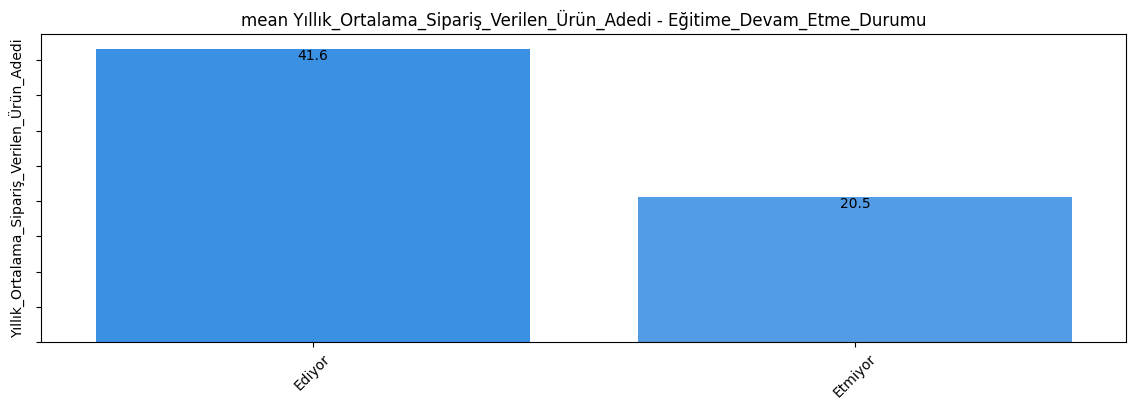

In [29]:
plot_avg_numvars_by_catvars(train,agg='mean', num_col='Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi')

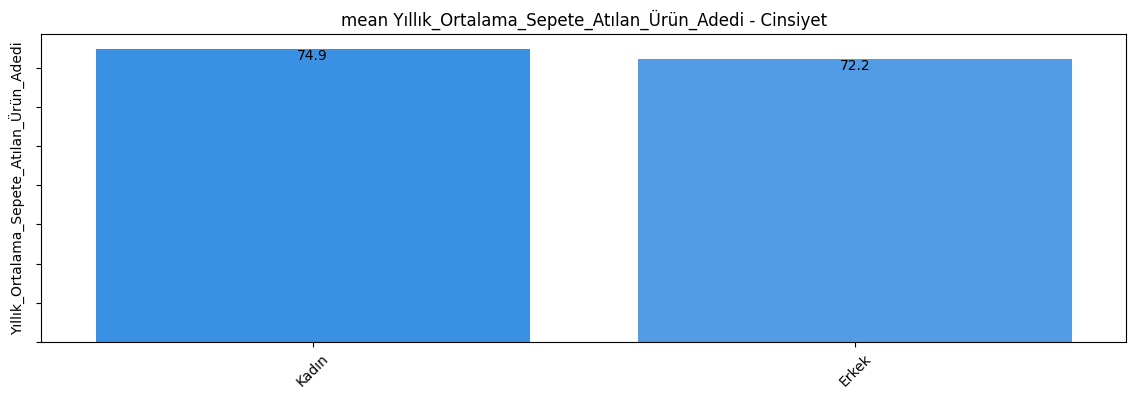

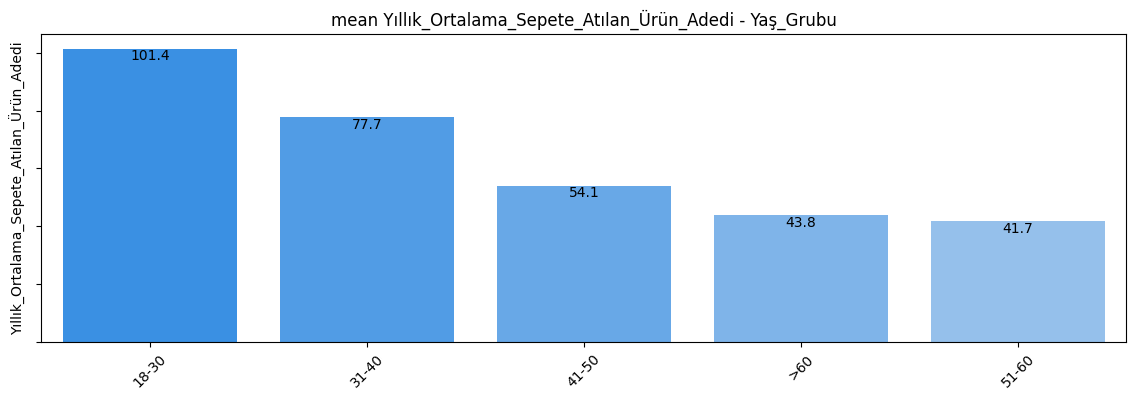

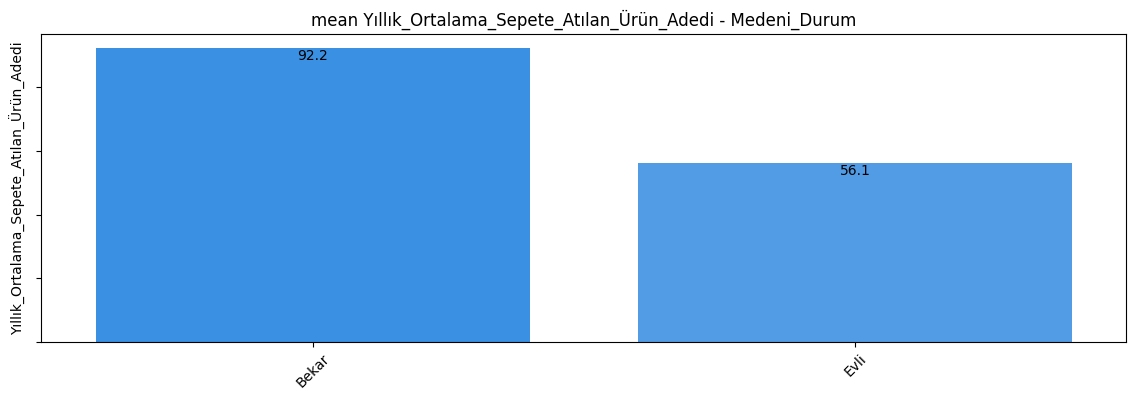

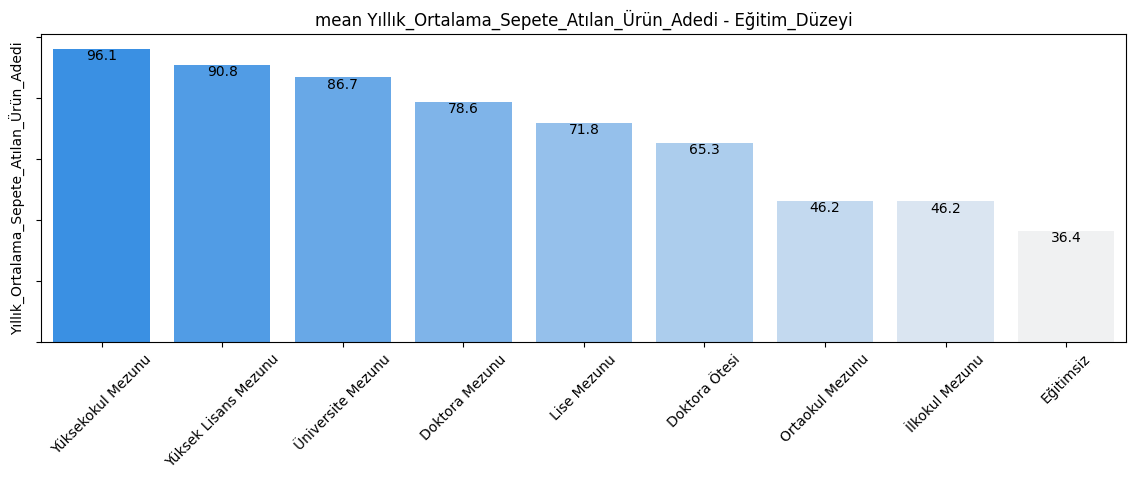

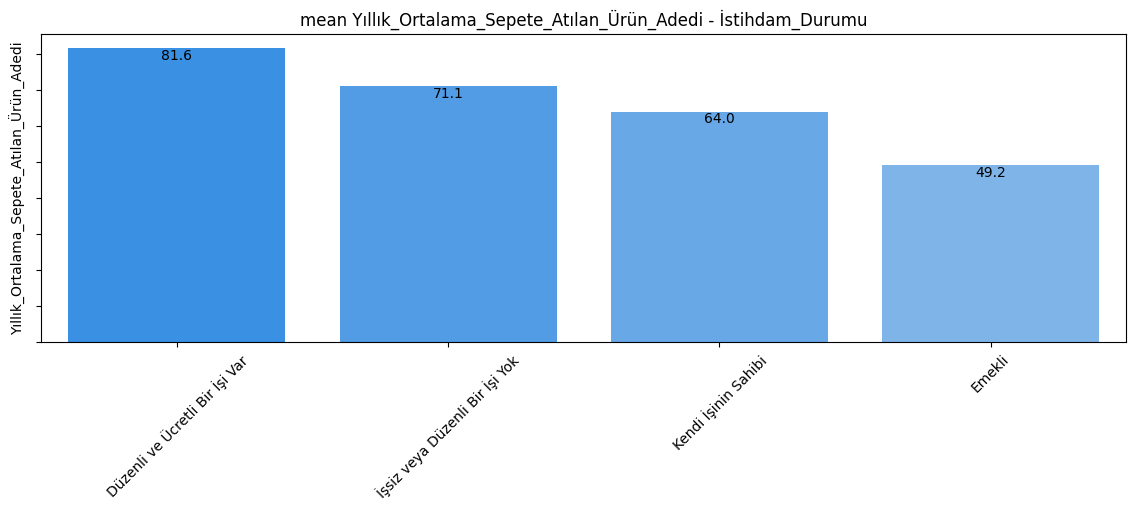

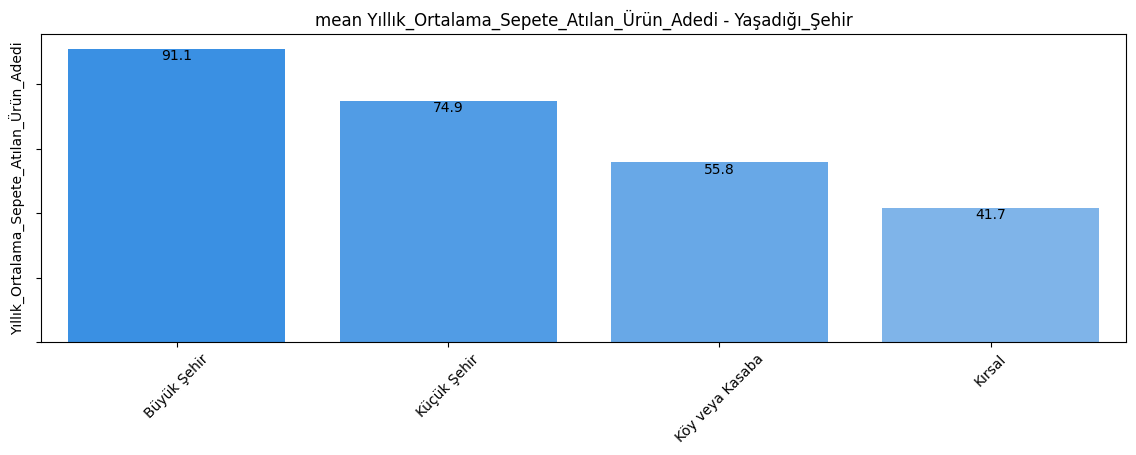

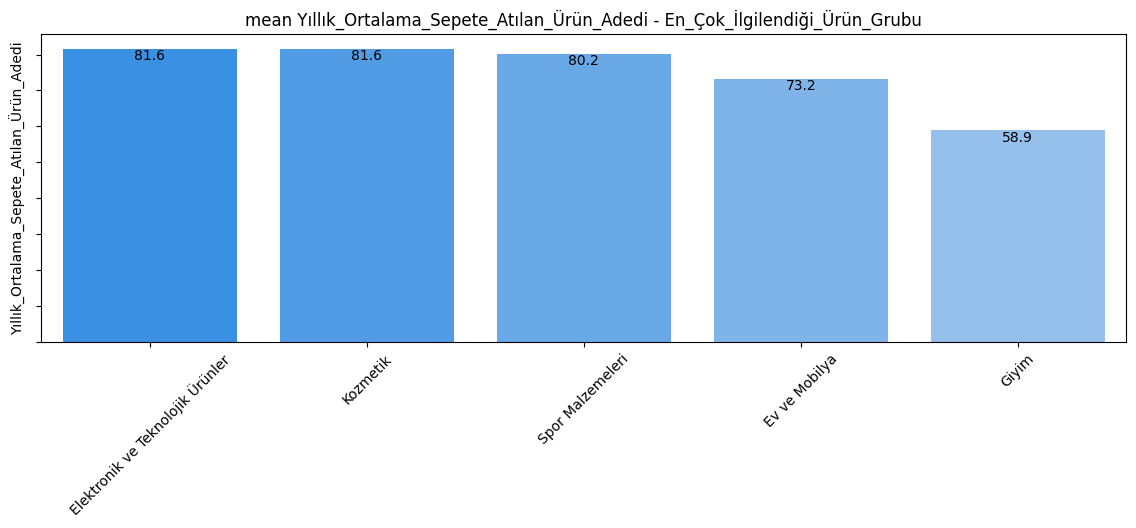

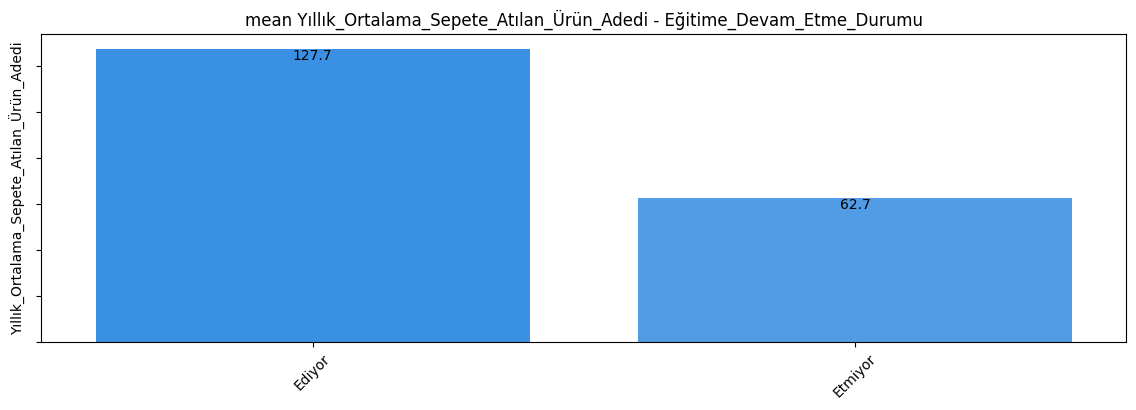

In [30]:
plot_avg_numvars_by_catvars(train,agg='mean', num_col='Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi')

### 2.2.5. Hedefe Göre Kategorik Değişkenlerin İstatistikleri <a id="2.2.5."></a>

__Yazmış olduğum fonksiyondaki `first_n` parametresi ile sıklığı en yüksek olan ilk `n` kategori seçilebiliyor, farklı değerler ile incelemelerimi gerçekleştirdim__

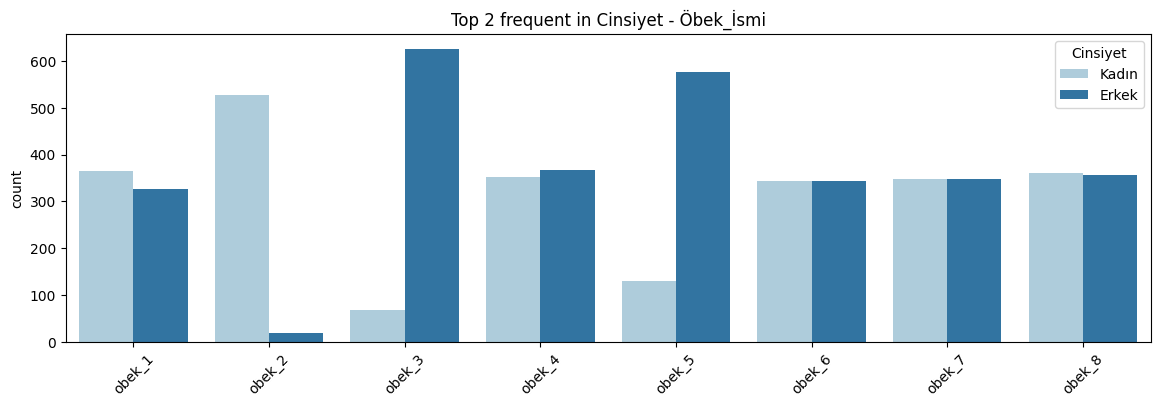

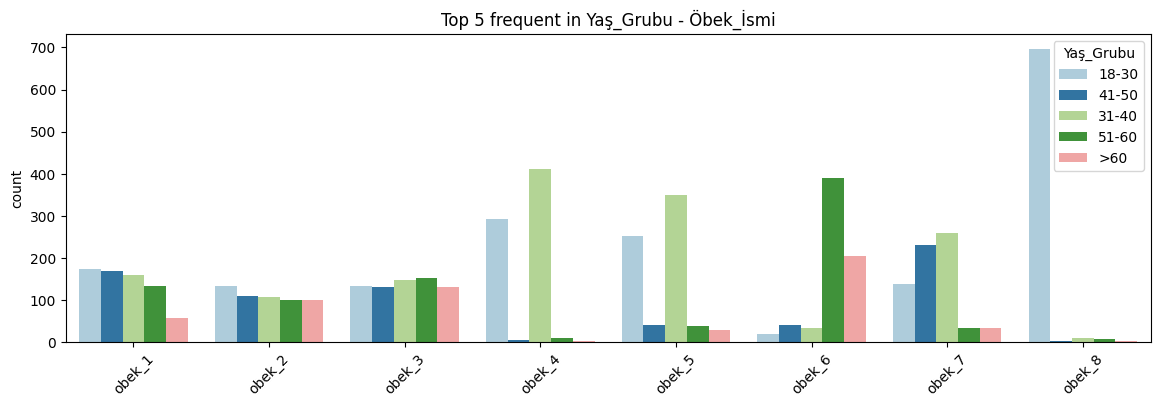

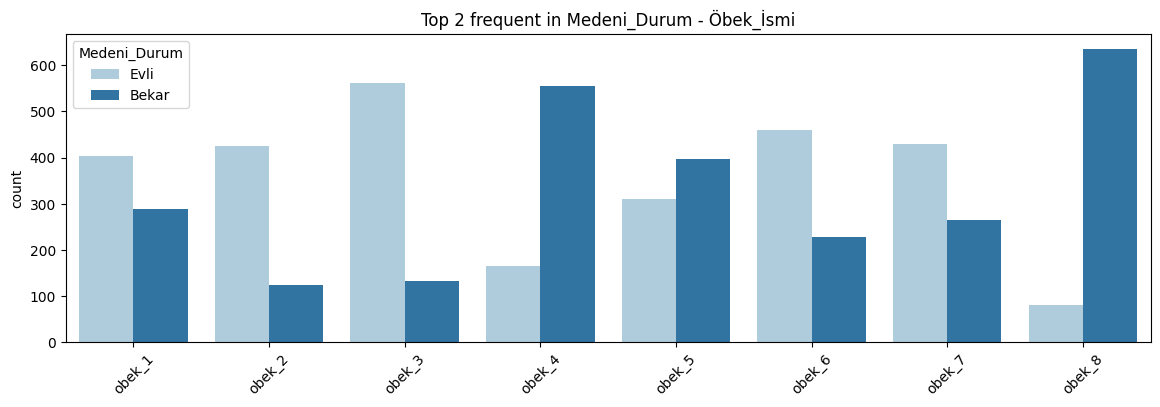

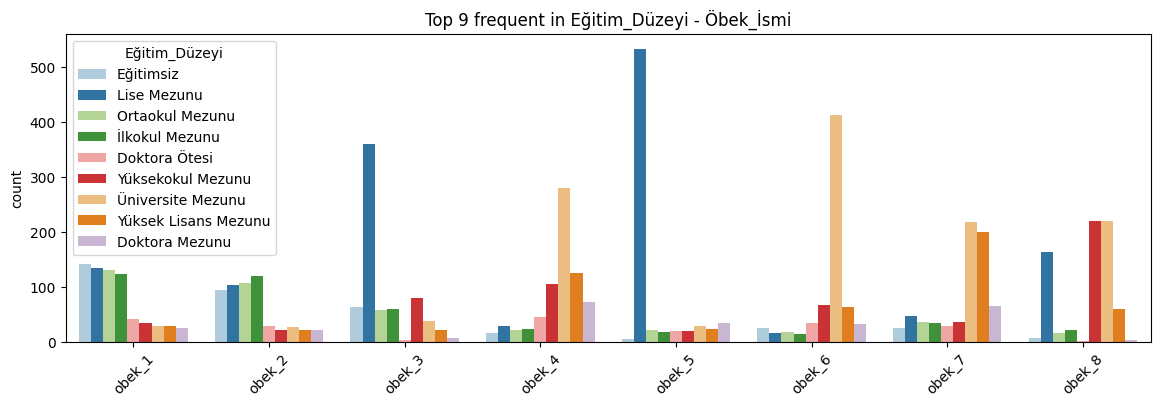

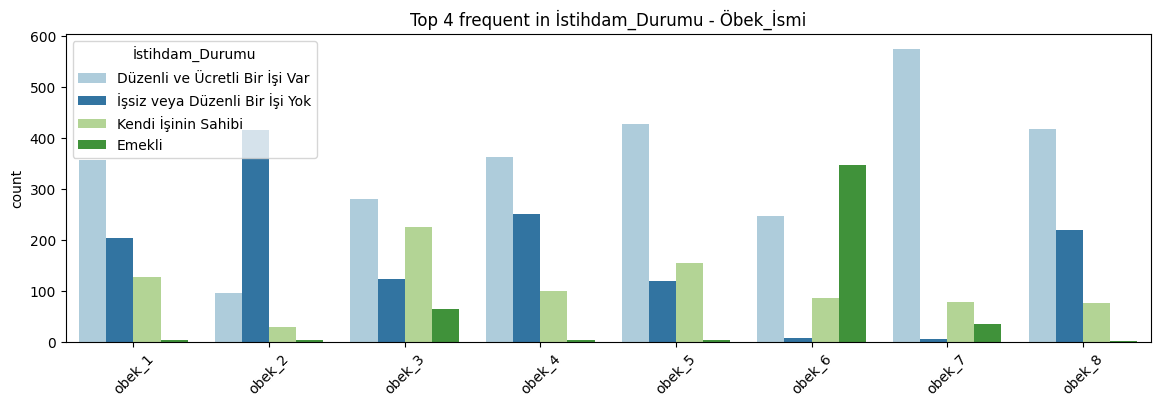

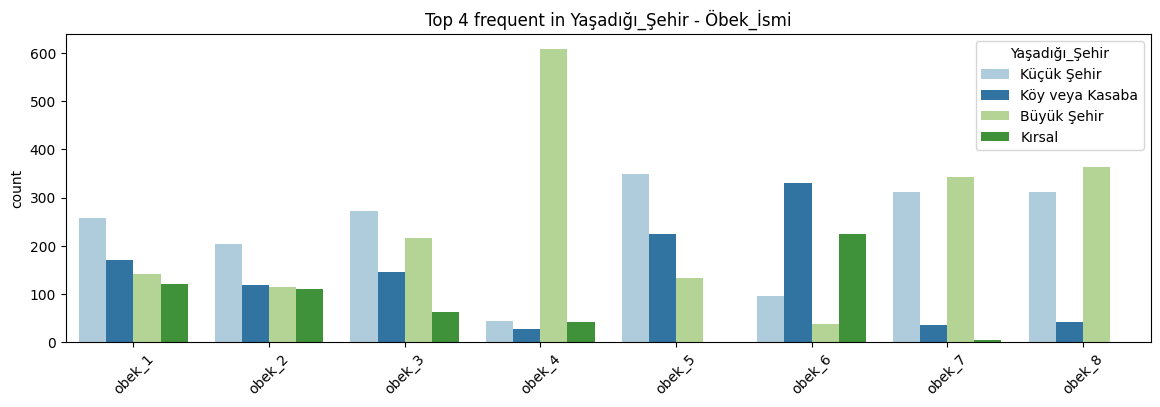

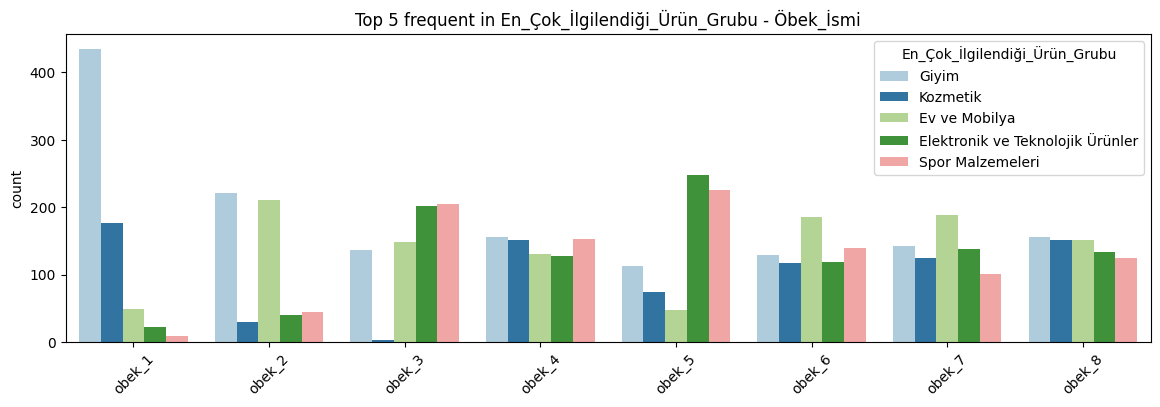

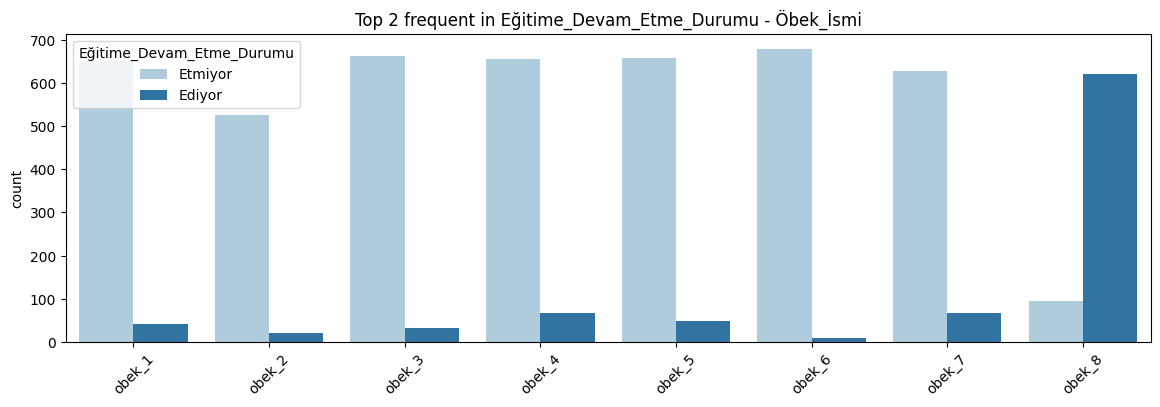

In [116]:
plot_freq_catvars_by_target(train, first_n= None)

### 2.3. Detaylı Pivot Tablolar - Öbekler Hakkında Çıkarımlar (detaylı çıkarımlara Excel dosyasında yer verilmiştir) <a id="2.3."></a>

#### 2.3.1. Tablo 1 <a id="2.3.1."></a>

In [32]:
train.pivot_table(index=target, columns=['Cinsiyet', 'Medeni_Durum', 'Yaş_Grubu'], values=num_cols, fill_value='YOK').T.round(2)

Öbek_İsmi                                                                     obek_1  \
                                           Cinsiyet Medeni_Durum Yaş_Grubu             
Yıllık_Ortalama_Gelir                      Erkek    Bekar        18-30     259315.33   
                                                                 31-40     242954.18   
                                                                 41-50     218286.79   
                                                                 51-60     256820.15   
                                                                 >60       237123.62   
                                                    Evli         18-30     223481.05   
                                                                 31-40     211199.37   
                                                                 41-50     228073.99   
                                                                 51-60     225537.19   
                                                                 >60       266004.36   
                                           Kadın    Bekar        18-30     269330.30   
                                                                 31-40     225122.30   
                                                                 41-50     216907.02   
                                                                 51-60     219276.44   
                                                                 >60       217175.01   
                                                    Evli         18-30     213406.33   
                                                                 31-40     231935.37   
                                                                 41-50     228306.29   
                                                                 51-60     221412.71   
                                                                 >60       217789.87   
Yıllık_Ortalama_Satın_Alım_Miktarı         Erkek    Bekar        18-30       6645.91   
                                                                 31-40       6533.48   
                                                                 41-50       6036.69   
                                                                 51-60       5697.23   
                                                                 >60         5568.07   
                                                    Evli         18-30       5971.15   
                                                                 31-40       5354.90   
                                                                 41-50       5320.08   
                                                                 51-60       5362.67   
                                                                 >60         9374.83   
                                           Kadın    Bekar        18-30       7600.80   
                                                                 31-40       6306.72   
                                                                 41-50       6287.93   
                                                                 51-60       6861.72   
                                                                 >60         5430.37   
                                                    Evli         18-30       5755.47   
                                                                 31-40       5774.36   
                                                                 41-50       5638.06   
                                                                 51-60       5333.14   
                                                                 >60         7961.56   
Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi   Erkek    Bekar        18-30         18.79   
                                                                 31-40         17.48   
                                                                 41-50         12.63   
                                        

#### 2.3.2. Tablo 2 <a id="2.3.2."></a>

In [33]:
train.pivot_table(index=target, columns=['Eğitim_Düzeyi', 'Eğitime_Devam_Etme_Durumu'], values=num_cols, fill_value='YOK').T.round(2)

Öbek_İsmi                                                                                    obek_1  \
                                           Eğitim_Düzeyi        Eğitime_Devam_Etme_Durumu             
Yıllık_Ortalama_Gelir                      Doktora Mezunu       Ediyor                    203333.09   
                                                                Etmiyor                   219202.22   
                                           Doktora Ötesi        Ediyor                    208441.67   
                                                                Etmiyor                   231229.11   
                                           Eğitimsiz            Ediyor                    226998.36   
                                                                Etmiyor                   218155.56   
                                           Lise Mezunu          Ediyor                    242057.43   
                                                                Etmiyor                   220169.12   
                                           Ortaokul Mezunu      Ediyor                    178324.64   
                                                                Etmiyor                   217941.03   
                                           Yüksek Lisans Mezunu Ediyor                    198894.80   
                                                                Etmiyor                   303178.77   
                                           Yüksekokul Mezunu    Ediyor                    207651.11   
                                                                Etmiyor                   269180.17   
                                           Üniversite Mezunu    Ediyor                    245626.50   
                                                                Etmiyor                   307013.85   
                                           İlkokul Mezunu       Ediyor                    198019.42   
                                                                Etmiyor                   224479.11   
Yıllık_Ortalama_Satın_Alım_Miktarı         Doktora Mezunu       Ediyor                      5175.72   
                                                                Etmiyor                     6176.59   
                                           Doktora Ötesi        Ediyor                      5163.53   
                                                                Etmiyor                     6193.49   
                                           Eğitimsiz            Ediyor                      5336.36   
                                                                Etmiyor                     5403.17   
                                           Lise Mezunu          Ediyor                      5728.31   
                                                                Etmiyor                     5341.75   
                                           Ortaokul Mezunu      Ediyor                      5311.67   
                                                                Etmiyor                     5860.52   
                                           Yüksek Lisans Mezunu Ediyor                      5898.40   
                                                                Etmiyor                    10707.75   
                                           Yüksekokul Mezunu    Ediyor                      6857.49   
                                                                Etmiyor                     6497.34   
                                           Üniversite Mezunu    Ediyor                      5000.79   
                                                                Etmiyor                    11485.61   
                                           İlkokul Mezunu       Ediyor                      5417.45   
                                                                Etmiyor                     5351.66   
Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi   Doktora Mezunu       Ediyor                

#### 2.3.3. Tablo 3 <a id="2.3.3."></a>

In [34]:
train.pivot_table(index=target, columns=['İstihdam_Durumu', 'Yaşadığı_Şehir'], values=num_cols, fill_value='YOK').T.round(2)

Öbek_İsmi                                                                                    obek_1  \
                                           İstihdam_Durumu                Yaşadığı_Şehir              
Yıllık_Ortalama_Gelir                      Düzenli ve Ücretli Bir İşi Var Büyük Şehir     252761.30   
                                                                          Köy veya Kasaba 222096.87   
                                                                          Küçük Şehir     221198.75   
                                                                          Kırsal          216897.96   
                                           Emekli                         Büyük Şehir           YOK   
                                                                          Köy veya Kasaba 473267.34   
                                                                          Küçük Şehir           YOK   
                                                                          Kırsal          489074.07   
                                           Kendi İşinin Sahibi            Büyük Şehir     223852.78   
                                                                          Köy veya Kasaba 220515.56   
                                                                          Küçük Şehir     215740.38   
                                                                          Kırsal          248113.06   
                                           İşsiz veya Düzenli Bir İşi Yok Büyük Şehir     282831.07   
                                                                          Köy veya Kasaba 223334.96   
                                                                          Küçük Şehir     212666.35   
                                                                          Kırsal          211753.51   
Yıllık_Ortalama_Satın_Alım_Miktarı         Düzenli ve Ücretli Bir İşi Var Büyük Şehir       7894.07   
                                                                          Köy veya Kasaba   5356.59   
                                                                          Küçük Şehir       5659.59   
                                                                          Kırsal            5390.32   
                                           Emekli                         Büyük Şehir           YOK   
                                                                          Köy veya Kasaba  40531.52   
                                                                          Küçük Şehir           YOK   
                                                                          Kırsal           41682.12   
                                           Kendi İşinin Sahibi            Büyük Şehir       5266.05   
                                                                          Köy veya Kasaba   5361.40   
                                                                          Küçük Şehir       5808.52   
                                                                          Kırsal            6201.07   
                                           İşsiz veya Düzenli Bir İşi Yok Büyük Şehir       7128.55   
                                                                          Köy veya Kasaba   5424.03   
                                                                          Küçük Şehir       5378.40   
                                                                          Kırsal            5373.54   
Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi   Düzenli ve Ücretli Bir İşi Var Büyük Şehir         25.00   
                                                                          Köy veya Kasaba     11.02   
                                                                          Küçük Şehir         11.46   
                                                                          Kırsal              10.30   
                                           Emekli                         Büyük Şehir 

#### 2.3.4. Tablo 4 <a id="2.3.4."></a>

In [35]:
train.pivot_table(index=target, columns=['Cinsiyet', 'Eğitim_Düzeyi','En_Çok_İlgilendiği_Ürün_Grubu'], values=num_cols, fill_value='YOK').T.round(2)

Öbek_İsmi                                                                                                     obek_1  \
                                           Cinsiyet Eğitim_Düzeyi        En_Çok_İlgilendiği_Ürün_Grubu                 
Yıllık_Ortalama_Gelir                      Erkek    Doktora Mezunu       Elektronik ve Teknolojik Ürünler  217802.26   
                                                                         Ev ve Mobilya                           YOK   
                                                                         Giyim                             209476.78   
                                                                         Kozmetik                          204189.44   
                                                                         Spor Malzemeleri                        YOK   
                                                    Doktora Ötesi        Elektronik ve Teknolojik Ürünler        YOK   
                                                                         Ev ve Mobilya                     287429.54   
                                                                         Giyim                             216958.55   
                                                                         Kozmetik                                YOK   
                                                                         Spor Malzemeleri                        YOK   
                                                    Eğitimsiz            Elektronik ve Teknolojik Ürünler  265390.92   
                                                                         Ev ve Mobilya                           YOK   
                                                                         Giyim                             220230.00   
                                                                         Kozmetik                          222358.63   
                                                                         Spor Malzemeleri                        YOK   
                                                    Lise Mezunu          Elektronik ve Teknolojik Ürünler  256839.45   
                                                                         Ev ve Mobilya                     239724.98   
                                                                         Giyim                             229652.23   
                                                                         Kozmetik                          177982.89   
                                                                         Spor Malzemeleri                  210086.04   
                                                    Ortaokul Mezunu      Elektronik ve Teknolojik Ürünler  241553.31   
                                                                         Ev ve Mobilya                     160002.90   
                                                                         Giyim                             223051.76   
                                                                         Kozmetik                          178010.29   
                                                                         Spor Malzemeleri                        YOK   
                                                    Yüksek Lisans Mezunu Elektronik ve Teknolojik Ürünler        YOK   
                                                                         Ev ve Mobilya                     341618.10   
                                                                         Giyim                             233352.06   
                                                                         Kozmetik                                YOK   
                                                                         Spor Malzemeleri                  549198.82   
                                                    Yüksekokul Mezunu    Elektronik ve Teknolojik Ürünler        YOK   
                                        

## 2.3.5. Öbekler Hakkında Çıkarımlar (detaylı çıkarımlar Excel dosyasında görülebilir) <a id="2.3.5."></a>

* Öbek 1 : Asgari ücretle çalışanlar

* Öbek 2 : Ev Hanımları

* Öbek 3 : Aile Babaları ve Bekar Erkekler

* Öbek 4 : Zenginler ve Beyaz Yakalılar

* Öbek 5 : İşçiler

* Öbek 6 : Emekliler

* Öbek 7 : Orta Gelirli Çalışanlar

* Öbek 8 : Yeni Mezunlar ve Öğrenciler

# 3. Kümeleme Algoritmalarını Deneme ve Görselleştirme <a id="3."></a>

* __Zaten çok yüksek olan leaderboard skorlarını nasıl artırabileceğimi araştırırken, sınıflandırma algoritmalarında kümeleme yapıp bunu da bir feature olarak eklemek gibi skoru daha da artıran deneysel bir yönteme denk geldim ve ben de denemek istedim.__``(Kaynak:`` [1](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiXx43v_YOBAxW5Q_EDHU0mC5wQFnoECBcQAQ&url=http%3A%2F%2Fwww.ijcse.net%2Fdocs%2FIJCSE16-05-06-026.pdf&usg=AOvVaw1ZzdgXHlkIximcdvcWLZdi&opi=89978449) ve [2](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjDkMf8_YOBAxU2QvEDHT32DpkQFnoECBEQAQ&url=https%3A%2F%2Fwww.researchgate.net%2Fpublication%2F327546865_Improving_Classification_Accuracy_Using_Clustering_Technique&usg=AOvVaw0jiaQ2eCVNOK4EZ2_Xgr3n&opi=89978449))

* __Sonrasında ise farklı kümeleme algoritmalarının veriseti üzerindeki performansına bakmak ve sahip olduğumuz hedef kümelere en yakın performansı hangisi veriyor diye bakmak istedim.__

In [36]:
train_num

Yıllık_Ortalama_Gelir  Yıllık_Ortalama_Satın_Alım_Miktarı  \
0                 748266.44                            32010.90   
1                 246298.61                             4145.73   
2                 268582.73                             9924.38   
3                 327721.84                             6417.78   
4                 397431.63                             7886.66   
...                     ...                                 ...   
5455              478054.25                            43182.30   
5456              481852.85                            42108.00   
5457              309443.69                             4655.39   
5458              266604.27                             9016.17   
5459              276155.08                             9455.66   

      Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi  \
0                                          37.31   
1                                          11.55   
2                                          55.35   
3                                          15.42   
4                                          14.69   
...                                          ...   
5455                                       31.36   
5456                                       26.29   
5457                                        5.16   
5458                                       39.21   
5459                                       50.55   

      Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi Öbek_İsmi  \
0                                       102.94    obek_4   
1                                        82.18    obek_5   
2                                       141.66    obek_8   
3                                        17.10    obek_3   
4                                        20.47    obek_3   
...                                        ...       ...   
5455                                     51.60    obek_6   
5456                                     49.19    obek_6   
5457                                      9.54    obek_1   
5458                                    143.28    obek_8   
5459                                    127.33    obek_8   

      Ort_Ürün_Başına_Ödenen_Ücret  Ort_Satın_Alma_Oranı  Ort_Harcama_Oranı  
0                           310.97                 36.24               4.28  
1                            50.45                 14.05               1.68  
2                            70.06                 39.07               3.70  
3                           375.31                 90.18               1.96  
4                           385.28                 71.76               1.98  
...                            ...                   ...                ...  
5455                        836.87                 60.78               9.03  
5456                        856.03                 53.45               8.74  
5457                        487.99                 54.09               1.50  
5458                         62.93                 27.37               3.38  
5459                         74.26                 39.70               3.42  

[5460 rows x 8 columns]

### 3.1. Birch <a id="3.1."></a>

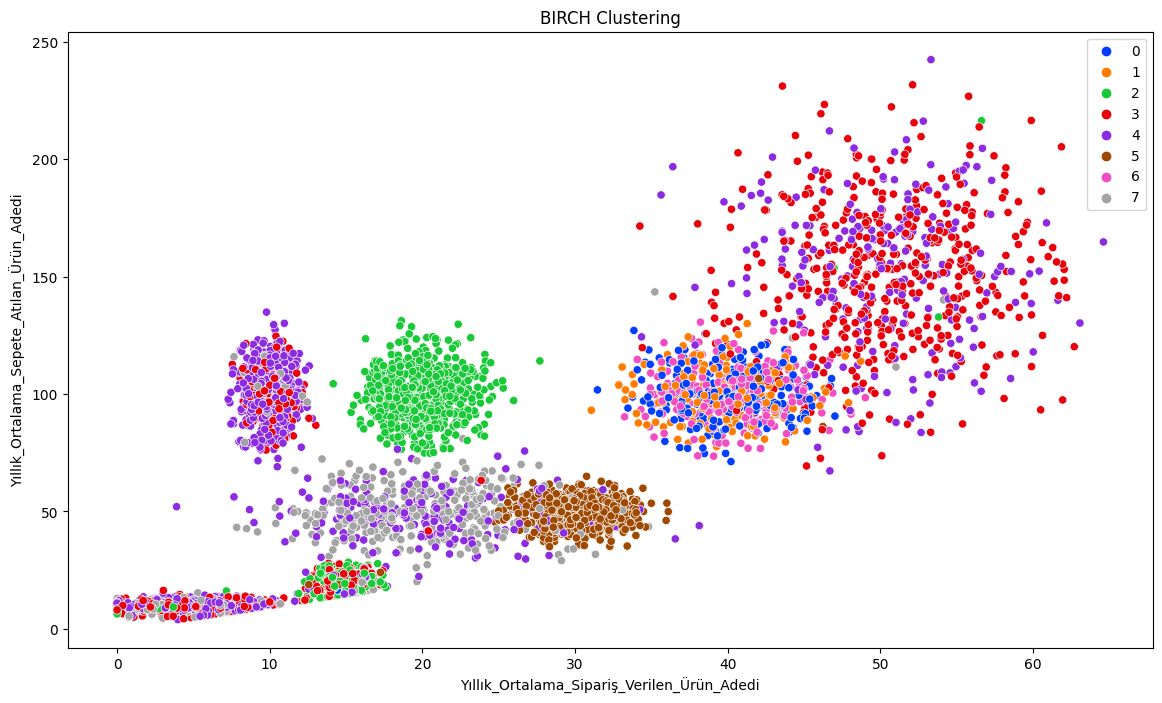

In [37]:
birch = Birch(n_clusters=8)

birch.fit(train_num.drop(['Öbek_İsmi'],axis=1))
birch_labels = birch.predict(train_num.drop(['Öbek_İsmi'],axis=1))

plt.subplots(figsize=(14,8))
sns.scatterplot(x=train_num.Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi, y=train_num.Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi, 
                hue=birch_labels,
                palette=bright_palette)
plt.title("BIRCH Clustering")
plt.xlabel("Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi")
plt.ylabel("Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi")
plt.show()

### 3.2. Gaussian Mixture <a id="3.2."></a>

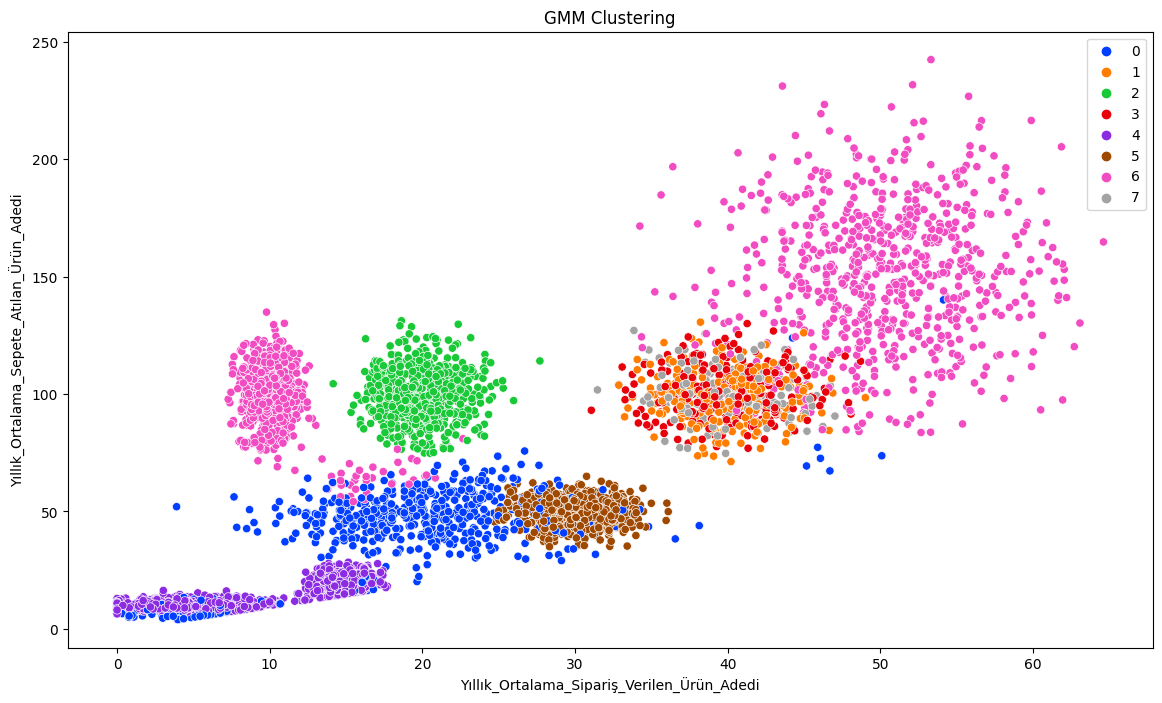

In [38]:
gmm = GaussianMixture(n_components=8,max_iter=1000,random_state=24)

gmm.fit(train_num.drop(['Öbek_İsmi'],axis=1))
gmm_labels = gmm.predict(train_num.drop(['Öbek_İsmi'],axis=1))

plt.subplots(figsize=(14,8))
sns.scatterplot(x=train_num.Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi, y=train_num.Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi, 
                hue=gmm_labels,
                palette=bright_palette)
plt.title("GMM Clustering")
plt.xlabel("Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi")
plt.ylabel("Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi")
plt.show()

### 3.3. Spectral <a id="3.3."></a>

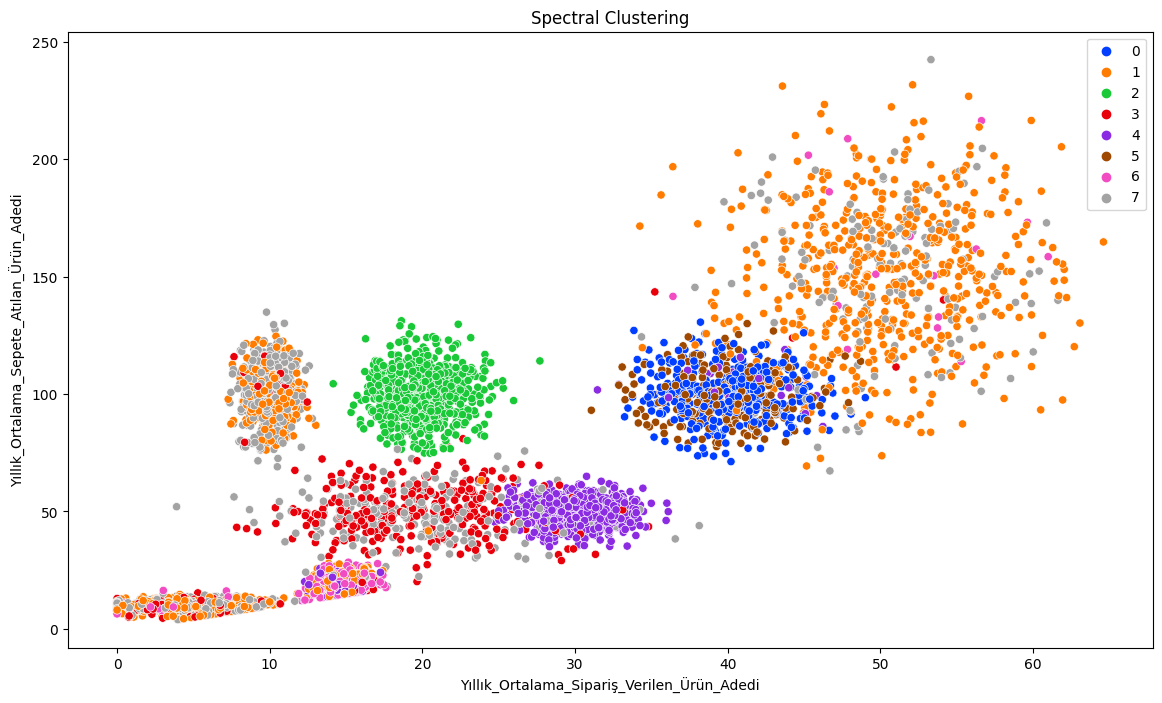

In [39]:
spectral_clustering = SpectralClustering(n_clusters=8, affinity='nearest_neighbors', random_state=24)
spectral_labels = spectral_clustering.fit_predict(train_num.drop(['Öbek_İsmi'],axis=1))

plt.subplots(figsize=(14,8))
sns.scatterplot(x=train_num.Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi, y=train_num.Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi, 
                hue=spectral_labels,
                palette=bright_palette)
plt.title("Spectral Clustering")
plt.xlabel("Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi")
plt.ylabel("Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi")
plt.show()

### 3.4. Agglomerative <a id="3.4."></a>

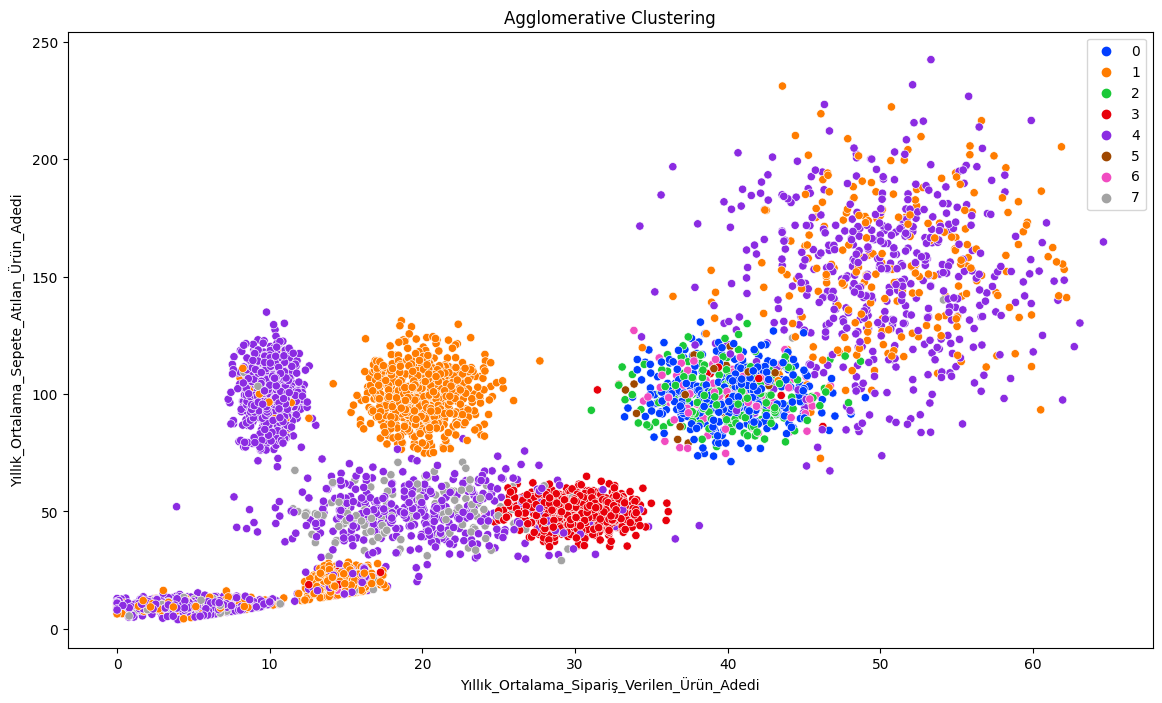

In [40]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=8, linkage='complete', affinity='euclidean')
agglomerative_labels = agglomerative_clustering.fit_predict(train_num.drop(['Öbek_İsmi'],axis=1))


plt.subplots(figsize=(14,8))
sns.scatterplot(x=train_num.Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi, y=train_num.Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi, 
                hue=agglomerative_labels,
                palette=bright_palette)
plt.title("Agglomerative Clustering")
plt.xlabel("Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi")
plt.ylabel("Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi")
plt.show()

### 3.5. KMeans <a id="3.5."></a>

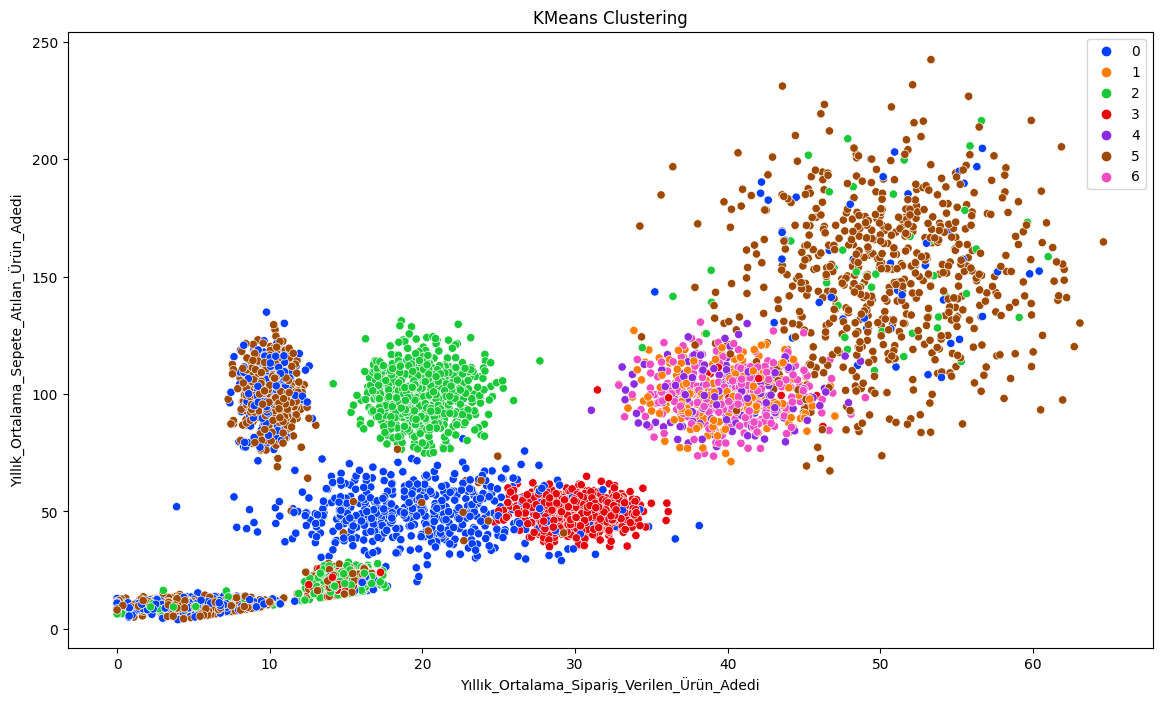

In [41]:
kmeans = KMeans(n_clusters=7, max_iter=1000,random_state=24)
kmeans.fit(train_num.drop(['Öbek_İsmi'],axis=1))
kmeans_labels = kmeans.predict(train_num.drop(['Öbek_İsmi'],axis=1))

plt.subplots(figsize=(14,8))
sns.scatterplot(x=train_num.Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi, y=train_num.Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi, 
                hue=kmeans_labels,
                palette=bright_palette)
plt.title("KMeans Clustering")
plt.xlabel("Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi")
plt.ylabel("Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi")
plt.show()

# 4. Öznitelik Çıkarımı - FE <a id="4."></a>

__Çıkarılacak özellikler:__

* Sayısal özelliklerden çıkacak özellikler
* Kategorik özelliklerin ve hedefin kodlanması
* Farklı cluster algoritmalarından çıkacak özellikler
* Elde edilen clusterlara göre gruplu istatistikler

### Kullanılacak fonksiyonlarım:

In [42]:
def get_num_features(df):
    
    df['Ort_Ürün_Başına_Ödenen_Ücret'] = df.Yıllık_Ortalama_Satın_Alım_Miktarı/df.Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi
    df['Ort_Satın_Alma_Oranı'] = (df.Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi/df.Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi)*100
    df['Ort_Harcama_Oranı'] = (df.Yıllık_Ortalama_Satın_Alım_Miktarı/df.Yıllık_Ortalama_Gelir)*100
    #df['Ort_Ürün_Başına_Harcama_Oranı'] = (df.Ort_Ürün_Başına_Ödenen_Ücret/df.Yıllık_Ortalama_Gelir)*100


def encode_cat_features(df,cat_cols, drop_first=False):
    return pd.get_dummies(df, columns=cat_cols, drop_first=drop_first)

def encode_cat_features_low_dimension(df,cat_cols):
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])
        
def encode_target(df, target):
    df[target] = df[target].apply(lambda x: x.replace( x, str(int(x[-1])-1))).astype('int')
    
def rev_encode_target(df, target):
    df[target] = df[target].apply(lambda x: str(x).replace( str(x), f'obek_{int(x+1)}'))
    

def robust_scale(df, num_cols):
    scaler = RobustScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)
    return scaled_df
    
def cluster_kproto(df, cat_col_dtype=['uint8','int32'], is_train=True):
    
    if is_train == True:
        data = df.drop([target],axis=1)
    else:
        data = df
    
    categorical_indexes = [data.columns.get_loc(col) for col in data.select_dtypes(include=cat_col_dtype).columns]
        
    kproto = KPrototypes(n_clusters=8, init='Cao',verbose=3, n_jobs=-1)
    clusters = kproto.fit_predict(data, categorical=categorical_indexes)
    
    return clusters.reshape(-1,1)

def cluster_kmeans(df_scaled, num_cols):
    
    kmeans = KMeans(n_clusters=8, random_state=24)
    clusters = kmeans.fit_predict(df_scaled)
    
    return clusters.reshape(-1,1)

def cluster_agglomerative(df_scaled, num_cols):
    
    agglo = AgglomerativeClustering(n_clusters=8)
    clusters = agglo.fit_predict(df_scaled)
    
    return clusters.reshape(-1,1)

def get_grouped_features(df, cluster_column):
    
    if cluster_column == 'kproto':
        
        temp = df.groupby(cluster_column).agg({'Yıllık_Ortalama_Gelir' : ['mean','min','max','std','sum','median'],
                                   'Yıllık_Ortalama_Satın_Alım_Miktarı' : ['mean','min','max','std','sum','median'],
                                    'Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi' : ['mean','min','max','std','sum','median'],
                                    'Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi' : ['mean','min','max','std','sum','median']})
    else:
        temp = df.groupby(cluster_column).agg({'Yıllık_Ortalama_Gelir' : ['mean','min','max','std','sum','median'],
                                   'Yıllık_Ortalama_Satın_Alım_Miktarı' : ['mean','min','max','std','sum','median'],
                                    'Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi' : ['mean','min','max','std','sum','median'],
                                    'Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi' : ['mean','min','max','std','sum','median'],
                                    'Cinsiyet' : [lambda x: x.mode()[0]],
                                    'Yaş_Grubu' : [lambda x: x.mode()[0]],
                                    'Medeni_Durum' : [lambda x: x.mode()[0]],
                                    'Eğitim_Düzeyi' : [lambda x: x.mode()[0]],
                                    'İstihdam_Durumu' : [lambda x: x.mode()[0]],
                                    'Yaşadığı_Şehir' : [lambda x: x.mode()[0]],
                                    'En_Çok_İlgilendiği_Ürün_Grubu' : [lambda x: x.mode()[0]],
                                    'Eğitime_Devam_Etme_Durumu' : [lambda x: x.mode()[0]]
                                   })
    
    

    temp.columns = ['_'.join(col) for col in temp.columns]
    temp.columns = [col.replace('<lambda>','mode') for col in temp.columns]
    temp.reset_index(inplace=True)
    cats_grouped = [col for col in temp.columns if temp[col].dtype == 'O']
    #cats_grouped.remove(target)
    
    return df.merge(temp,on=cluster_column,how='left'), cats_grouped

def encode_grouped_cat_features(df,cats_grouped):
    for col in cats_grouped:
        df[col] = le.fit_transform(df[col])

In [43]:
train2 = train.copy()

get_num_features(train2)

train2['kmeans'] = cluster_kmeans(robust_scale(train2[num_cols], num_cols), num_cols)
train2['agglo'] = cluster_agglomerative(robust_scale(train2[num_cols], num_cols), num_cols)

train2 = encode_cat_features(train2,cat_cols)
train2['kproto'] = cluster_kproto(train2.drop(['agglo','kmeans'],axis=1))

encode_target(train2,target)

train2, cats_grouped = get_grouped_features(train2,'kproto')
encode_grouped_cat_features(train2, cats_grouped)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 6


In [44]:
train2

Yıllık_Ortalama_Gelir  Yıllık_Ortalama_Satın_Alım_Miktarı  \
0                 748266.44                            32010.90   
1                 246298.61                             4145.73   
2                 268582.73                             9924.38   
3                 327721.84                             6417.78   
4                 397431.63                             7886.66   
...                     ...                                 ...   
5455              478054.25                            43182.30   
5456              481852.85                            42108.00   
5457              309443.69                             4655.39   
5458              266604.27                             9016.17   
5459              276155.08                             9455.66   

      Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi  Öbek_İsmi  \
0                                          37.31          3   
1                                          11.55          4   
2                                          55.35          7   
3                                          15.42          2   
4                                          14.69          2   
...                                          ...        ...   
5455                                       31.36          5   
5456                                       26.29          5   
5457                                        5.16          0   
5458                                       39.21          7   
5459                                       50.55          7   

      Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi  Ort_Ürün_Başına_Ödenen_Ücret  \
0                                       102.94                        310.97   
1                                        82.18                         50.45   
2                                       141.66                         70.06   
3                                        17.10                        375.31   
4                                        20.47                        385.28   
...                                        ...                           ...   
5455                                     51.60                        836.87   
5456                                     49.19                        856.03   
5457                                      9.54                        487.99   
5458                                    143.28                         62.93   
5459                                    127.33                         74.26   

      Ort_Satın_Alma_Oranı  Ort_Harcama_Oranı  kmeans  agglo  Cinsiyet_Erkek  \
0                    36.24               4.28       1      0               0   
1                    14.05               1.68       6      6               1   
2                    39.07               3.70       3      1               1   
3                    90.18               1.96       7      2               1   
4                    71.76               1.98       7      2               1   
...                    ...                ...     ...    ...             ...   
5455                 60.78               9.03       5      5               0   
5456                 53.45               8.74       5      5               1   
5457                 54.09               1.50       4      7               0   
5458                 27.37               3.38       3      1               0   
5459                 39.70               3.42       3      1               1   

      Cinsiyet_Kadın  Yaş_Grubu_18-30  Yaş_Grubu_31-40  Yaş_Grubu_41-50  \
0                  1                0                1                0   
1                  0                0                0                0   
2                  0                1                0                0   
3                  0                0                0                0   
4                  0                0                1                0   
...              ...              ...              ...              ... 

# 5. Öznitelik Seçimi - FS <a id="5."></a>


In [45]:
y_fs = train2[target]
x_fs = train2.drop([target],axis=1)

fs_model = LGBMClassifier(random_state=24)

## 5.1. Recursive Feature Elimination - RFECV <a id="5.1."></a>

In [46]:
rfecv = RFECV(fs_model, step=1, cv=skf5, scoring='accuracy', n_jobs=-1, verbose=24)
rfecv = rfecv.fit(x_fs, y_fs)
rfecv_picks = rfecv.get_feature_names_out()

Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.


In [47]:
rfecv_picks

array(['Yıllık_Ortalama_Gelir', 'Yıllık_Ortalama_Satın_Alım_Miktarı',
       'Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi',
       'Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi',
       'Ort_Ürün_Başına_Ödenen_Ücret', 'Ort_Satın_Alma_Oranı',
       'Ort_Harcama_Oranı', 'kmeans', 'agglo', 'Cinsiyet_Erkek',
       'Cinsiyet_Kadın', 'Yaş_Grubu_18-30', 'Yaş_Grubu_31-40',
       'Yaş_Grubu_41-50', 'Yaş_Grubu_51-60', 'Yaş_Grubu_>60',
       'Medeni_Durum_Bekar', 'Medeni_Durum_Evli',
       'Eğitim_Düzeyi_Doktora Mezunu', 'Eğitim_Düzeyi_Doktora Ötesi',
       'Eğitim_Düzeyi_Eğitimsiz', 'Eğitim_Düzeyi_Lise Mezunu',
       'Eğitim_Düzeyi_Ortaokul Mezunu',
       'Eğitim_Düzeyi_Yüksek Lisans Mezunu',
       'Eğitim_Düzeyi_Yüksekokul Mezunu',
       'Eğitim_Düzeyi_Üniversite Mezunu', 'Eğitim_Düzeyi_İlkokul Mezunu',
       'İstihdam_Durumu_Düzenli ve Ücretli Bir İşi Var',
       'İstihdam_Durumu_Emekli', 'İstihdam_Durumu_Kendi İşinin Sahibi',
       'İstihdam_Durumu_İşsiz veya Düzenli Bir İşi Yok',
   

## 5.2. Sequential Feature Selection - SFS <a id="5.2."></a>

In [48]:
sfs = SFS(fs_model, 
           k_features='best', 
           forward=True, 
           floating=False, 
           verbose=1,
           scoring='accuracy',
           n_jobs=-1,
           cv=skf5)


sfs = sfs.fit(x_fs, y_fs)
sfs_picks = sfs.k_feature_names_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   12.5s finished
Features: 1/67[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:   23.5s finished
Features: 2/67[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   29.2s finished
Features: 3/67[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   28.1s finished
Features: 4/67[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   19.5s finished
Features: 44/67[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:   19.0s finished
Features: 45/67[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   18.8s finished
Features: 46/67[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   18.1s finished
Features: 47/67[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   17.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   17.3s finished
Features: 48/67[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: 

In [49]:
sfs_picks

('Yıllık_Ortalama_Gelir',
 'Yıllık_Ortalama_Satın_Alım_Miktarı',
 'Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi',
 'Ort_Satın_Alma_Oranı',
 'kmeans',
 'agglo',
 'Cinsiyet_Erkek',
 'Cinsiyet_Kadın',
 'Yaş_Grubu_18-30',
 'Yaş_Grubu_31-40',
 'Yaş_Grubu_41-50',
 'Yaş_Grubu_51-60',
 'Yaş_Grubu_>60',
 'Eğitim_Düzeyi_Doktora Mezunu',
 'Eğitim_Düzeyi_Doktora Ötesi',
 'Eğitim_Düzeyi_Eğitimsiz',
 'Eğitim_Düzeyi_Lise Mezunu',
 'Eğitim_Düzeyi_Ortaokul Mezunu',
 'Eğitim_Düzeyi_Yüksek Lisans Mezunu',
 'Eğitim_Düzeyi_Yüksekokul Mezunu',
 'Eğitim_Düzeyi_Üniversite Mezunu',
 'Eğitim_Düzeyi_İlkokul Mezunu',
 'İstihdam_Durumu_Emekli',
 'Yaşadığı_Şehir_Büyük Şehir',
 'Yaşadığı_Şehir_Küçük Şehir',
 'En_Çok_İlgilendiği_Ürün_Grubu_Ev ve Mobilya',
 'En_Çok_İlgilendiği_Ürün_Grubu_Kozmetik',
 'En_Çok_İlgilendiği_Ürün_Grubu_Spor Malzemeleri',
 'Eğitime_Devam_Etme_Durumu_Ediyor',
 'Eğitime_Devam_Etme_Durumu_Etmiyor')

In [50]:
rfecv_discard = [col for col in x_fs.columns if col not in rfecv_picks]
sfs_discard = [col for col in x_fs.columns if col not in sfs_picks]

In [51]:
rfecv_discard

['Yıllık_Ortalama_Gelir_mean',
 'Yıllık_Ortalama_Gelir_min',
 'Yıllık_Ortalama_Gelir_max',
 'Yıllık_Ortalama_Gelir_median',
 'Yıllık_Ortalama_Satın_Alım_Miktarı_mean',
 'Yıllık_Ortalama_Satın_Alım_Miktarı_min',
 'Yıllık_Ortalama_Satın_Alım_Miktarı_max',
 'Yıllık_Ortalama_Satın_Alım_Miktarı_std',
 'Yıllık_Ortalama_Satın_Alım_Miktarı_sum',
 'Yıllık_Ortalama_Satın_Alım_Miktarı_median',
 'Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi_mean',
 'Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi_min',
 'Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi_median',
 'Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi_mean',
 'Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi_min',
 'Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi_max',
 'Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi_std',
 'Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi_sum',
 'Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi_median']

In [52]:
sfs_discard

['Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi',
 'Ort_Ürün_Başına_Ödenen_Ücret',
 'Ort_Harcama_Oranı',
 'Medeni_Durum_Bekar',
 'Medeni_Durum_Evli',
 'İstihdam_Durumu_Düzenli ve Ücretli Bir İşi Var',
 'İstihdam_Durumu_Kendi İşinin Sahibi',
 'İstihdam_Durumu_İşsiz veya Düzenli Bir İşi Yok',
 'Yaşadığı_Şehir_Köy veya Kasaba',
 'Yaşadığı_Şehir_Kırsal',
 'En_Çok_İlgilendiği_Ürün_Grubu_Elektronik ve Teknolojik Ürünler',
 'En_Çok_İlgilendiği_Ürün_Grubu_Giyim',
 'kproto',
 'Yıllık_Ortalama_Gelir_mean',
 'Yıllık_Ortalama_Gelir_min',
 'Yıllık_Ortalama_Gelir_max',
 'Yıllık_Ortalama_Gelir_std',
 'Yıllık_Ortalama_Gelir_sum',
 'Yıllık_Ortalama_Gelir_median',
 'Yıllık_Ortalama_Satın_Alım_Miktarı_mean',
 'Yıllık_Ortalama_Satın_Alım_Miktarı_min',
 'Yıllık_Ortalama_Satın_Alım_Miktarı_max',
 'Yıllık_Ortalama_Satın_Alım_Miktarı_std',
 'Yıllık_Ortalama_Satın_Alım_Miktarı_sum',
 'Yıllık_Ortalama_Satın_Alım_Miktarı_median',
 'Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi_mean',
 'Yıllık_Ortalama_Sipariş_Verilen_

In [53]:
drop_cols = set(rfecv_discard).union(sfs_discard)

x_fs.drop(columns=drop_cols,inplace=True)

# 6. Model Seçimi <a id="6."></a>

### Kullanılacak fonksiyonlarım:

In [54]:
def stratifiedKFold_on_acc(model,x,y,cv):
    start_time = time.time()
    scores = cross_val_score(model, x, y, cv=cv, n_jobs=-1, scoring="accuracy",verbose=1,error_score='raise')
    print("Model : {}".format(model))
    print("scores",scores)
    print(f"scores mean: {np.mean(scores)} ,scores std :{np.std(scores)}" )
    print("\n\n")
    end_time = time.time()
    total_time = end_time - start_time
    print("Total time taken: {} seconds".format(total_time))

def lazy_classify(x,y,n_splits=10, verbose=0):
    
    models_df = []
    
    skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state= 24)
    
    cv_splits = list(skf.split(x, y))

    for split_train, split_val in tqdm(cv_splits):
        
        split_train = x.index[split_train]
        split_val = x.index[split_val]

        x_train, y_train = x.loc[split_train], y.loc[split_train]
        x_val, y_val = x.loc[split_val], y.loc[split_val]
        
        
        clf = LazyClassifier(verbose=verbose,ignore_warnings=True)
        
        models,predictions = clf.fit(x_train, x_val, y_train, y_val)
    
        models_df.append(models)
     
    
    results_df = pd.concat(models_df).groupby('Model')['Accuracy'
                                                      ].mean().reset_index(
                                                      ).sort_values(by='Accuracy', 
                                                                    ascending=False)
    return results_df

In [55]:
models_df = lazy_classify(x= x_fs,y= y_fs,n_splits= 10)

  0%|          | 0/10 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:14<00:00,  2.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:14<00:00,  1.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:15<00:00,  1.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:15<00:00,  1.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:14<00:00,  1.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:14<00:00,  2.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:14<00:00,  2.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:14<00:00,  2.07it/s]

 14%|███████████▍              

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:14<00:00,  2.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:14<00:00,  2.05it/s]


In [56]:
models_df.head(5)

Model  Accuracy
21  RandomForestClassifier      0.95
26           XGBClassifier      0.95
25                     SVC      0.95
24           SGDClassifier      0.95
10          LGBMClassifier      0.95

In [57]:
rf = RandomForestClassifier(n_estimators=200, random_state=24)
xgb = XGBClassifier(random_state= 24)
lgbm = LGBMClassifier(random_state= 24)
cat = CatBoostClassifier(random_seed= 24, allow_writing_files= False)

In [58]:
stratifiedKFold_on_acc(rf, x_fs, y_fs, skf10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96336996 0.95787546 0.96153846 0.95054945 0.94505495 0.94871795
 0.97252747 0.94688645 0.94871795 0.95054945]
scores mean: 0.9545787545787545 ,scores std :0.008424908424908444



Total time taken: 1.9975152015686035 seconds


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished


In [59]:
stratifiedKFold_on_acc(xgb, x_fs, y_fs, skf10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=24, ...)
scores [0.96336996 0.95787546 0.96153846 0.94871795 0.94505495 0.94505495
 0.97252747 0.94688645 0.94871795 0.94871795]
scores mean: 0.9538461538461538 ,scores std :0.008927514730369205



Total time taken: 9.794769763946533 seconds


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.7s finished


In [60]:
stratifiedKFold_on_acc(lgbm, x_fs, y_fs, skf10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : LGBMClassifier(random_state=24)
scores [0.96153846 0.95787546 0.95970696 0.94871795 0.94505495 0.94505495
 0.97069597 0.94688645 0.94688645 0.95054945]
scores mean: 0.9532967032967032 ,scores std :0.008241758241758263



Total time taken: 1.4835784435272217 seconds


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished


In [61]:
stratifiedKFold_on_acc(cat, x_fs, y_fs, skf10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : <catboost.core.CatBoostClassifier object at 0x0000018FE1084100>
scores [0.96153846 0.95787546 0.96153846 0.95054945 0.94505495 0.94688645
 0.97252747 0.94688645 0.94688645 0.95054945]
scores mean: 0.954029304029304 ,scores std :0.008529766316626405



Total time taken: 40.780115842819214 seconds


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   40.7s finished


## Bunların sonucunda:

* Random Forest ve CatBoost ile yapmış olduğum submissionlarda yarışmanın en başında yaptığım standart veri seti ve standart RF modeli ile elde ettiğim skoru geçemedim.

* Özellikleri elle CV kontrol ederek seçmek ve sonra tekrar deneme yapmak istedim. 

* Bunun sonucunda CV skorumu artırsam da yine de leaderboard'da bu durumu yansıtamadım.

# 7. Model/Submission Değerlendirmesi ve Yeni Setlerin Oluşturulması <a id="7."></a>

__Çıkarılmasına karar verilen özellikler:__

In [62]:
train3 = train.copy()

#get_num_features(train3)

#train3['kmeans'] = cluster_kmeans(robust_scale(train3[num_cols], num_cols), num_cols)
#train3['agglo'] = cluster_agglomerative(robust_scale(train3[num_cols], num_cols), num_cols)

train3 = encode_cat_features(train3,cat_cols)
train3['kproto'] = cluster_kproto(train3)

encode_target(train3,target)

#train3, cats_grouped = get_grouped_features(train3,'kproto')
#encode_grouped_cat_features(train3, cats_grouped)

x3 = train3.drop([target],axis=1)
y3 = train3[target]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 8


__Kprototype algoritmasının deterministik olduğu belirtilse de her run edişimde farklı cluster atamaları ile küçük oynamalar oluyor ve farklı CV skorları elde etmeme sebep oluyor, yine bu sebepten aynı submission'ı tekrar elde etmek zor olabiliyor. Kproto clusterını feature olarak eklediğim setlerde elde ettiğim en yüksek CV skoru 0.9549 idi.__

In [63]:
stratifiedKFold_on_acc(rf,x3,y3,skf10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96336996 0.95787546 0.96153846 0.95054945 0.94688645 0.94871795
 0.97252747 0.94688645 0.94871795 0.95238095]
scores mean: 0.9549450549450549 ,scores std :0.008157896502315071



Total time taken: 1.9752459526062012 seconds


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished


# 8. Hiç Bir Sınıflandırma ve Kümeleme Algoritması Tarafından Doğru Tahmin Edilemeyen Örneklemin Tespiti ve İncelenmesi <a id="8."></a>

__Skorlarımı hiç bir şekilde artıramadıktan sonra Cross Validation splitlerinde yanlış sınıflanan gözlem değerlerini bulmak ve kontrol etmek istedim, bunlar aynı zamanda Kümeleme algoritmalarının da yanlış sınıfladığı değerler idi fakat buraya dahil etmedim.__


## 8.1. Tespit <a id="8.1."></a>

In [64]:
def get_misclassified_indexes(x,y, n_splits=10):
    
    temp = train.copy()
    
    accuracy = []
    
    misclassified_indexes = []

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)

    cv_splits = list(skf.split(x, y))

    for split_train, split_val in tqdm(cv_splits):
        split_train = x.index[split_train]
        split_val = x.index[split_val]

        x_train, y_train = x.loc[split_train], y.loc[split_train]
        x_val, y_val = x.loc[split_val], y.loc[split_val]

        print("Train shape:", x_train.shape, "|", "Val Shape:", x_val.shape)
        print("Label value counts in Val Split:\n", y_val.value_counts())

        model = RandomForestClassifier(**{'n_estimators': 200, 'random_state': 24})

        model.fit(x_train, y_train)

        preds = model.predict(x_val)

        acc = accuracy_score(y_val, preds)
        print("Fold Accuracy: ", acc)
        accuracy.append(acc)

        misclassified_indexes.append(y_val.loc[y_val != preds].index)

        print("\n", "*-"*50, "\n")
    
    print(f'\n Mean Accuracy: {np.mean(accuracy)}, std: {np.std(accuracy)} \n')
    
    temp['is_misclassified'] = 0
    for index in misclassified_indexes:
        temp.loc[index, 'is_misclassified'] = 1
        
    misclassed_df = temp.loc[temp.is_misclassified == 1]
    
    return misclassed_df.index

In [65]:
misclassified_indexes = get_misclassified_indexes(x3, y3, n_splits=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train shape: (4914, 38) | Val Shape: (546, 38)
Label value counts in Val Split:
 7    72
3    72
4    71
6    70
5    69
0    69
2    69
1    54
Name: Öbek_İsmi, dtype: int64
Fold Accuracy:  0.9633699633699634

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*- 

Train shape: (4914, 38) | Val Shape: (546, 38)
Label value counts in Val Split:
 7    72
3    72
4    71
6    70
5    69
2    69
0    69
1    54
Name: Öbek_İsmi, dtype: int64
Fold Accuracy:  0.9578754578754579

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*- 

Train shape: (4914, 38) | Val Shape: (546, 38)
Label value counts in Val Split:
 3    72
7    72
4    71
6    70
2    69
5    69
0    69
1    54
Name: Öbek_İsmi, dtype: int64
Fold Accuracy:  0.9615384615384616

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*- 

Train shape: (4914, 38) | Val Shape: (546, 38)
Label va

In [66]:
len(misclassified_indexes)

246

In [67]:
miss = train.loc[misclassified_indexes]
miss.head(5)

Cinsiyet Yaş_Grubu Medeni_Durum      Eğitim_Düzeyi  \
8     Erkek     51-60        Bekar  Üniversite Mezunu   
24    Erkek     31-40        Bekar  Üniversite Mezunu   
27    Erkek     41-50         Evli        Lise Mezunu   
51    Erkek     18-30        Bekar      Doktora Ötesi   
73    Erkek     31-40        Bekar     İlkokul Mezunu   

                   İstihdam_Durumu  Yıllık_Ortalama_Gelir   Yaşadığı_Şehir  \
8   Düzenli ve Ücretli Bir İşi Var              479593.47  Köy veya Kasaba   
24             Kendi İşinin Sahibi              141995.91  Köy veya Kasaba   
27             Kendi İşinin Sahibi              309105.54      Küçük Şehir   
51  Düzenli ve Ücretli Bir İşi Var              842848.37      Büyük Şehir   
73  Düzenli ve Ücretli Bir İşi Var              328094.11  Köy veya Kasaba   

       En_Çok_İlgilendiği_Ürün_Grubu  Yıllık_Ortalama_Satın_Alım_Miktarı  \
8   Elektronik ve Teknolojik Ürünler                            39574.60   
24  Elektronik ve Teknolojik Ürünler                             6679.54   
27                     Ev ve Mobilya                             7394.35   
51                          Kozmetik                            35190.74   
73  Elektronik ve Teknolojik Ürünler                            25355.45   

    Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi Eğitime_Devam_Etme_Durumu  \
8                                        25.69                   Etmiyor   
24                                        1.23                   Etmiyor   
27                                       15.29                    Ediyor   
51                                       38.46                   Etmiyor   
73                                       20.08                   Etmiyor   

   Öbek_İsmi  Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi  
8     obek_3                                     56.32  
24    obek_4                                      9.91  
27    obek_6                                     17.55  
51    obek_6                                     92.84  
73    obek_4                                    107.96

## 8.2. İnceleme <a id="8.2."></a>

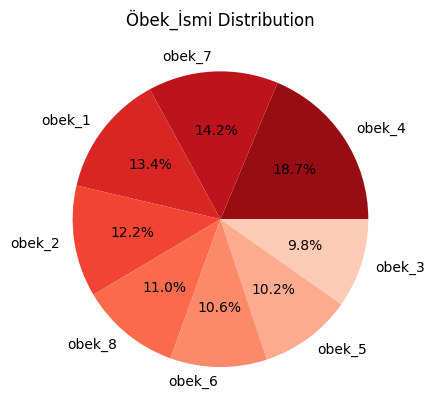

In [68]:
plot_distributions(miss, target, target_pie=True, alert=True)

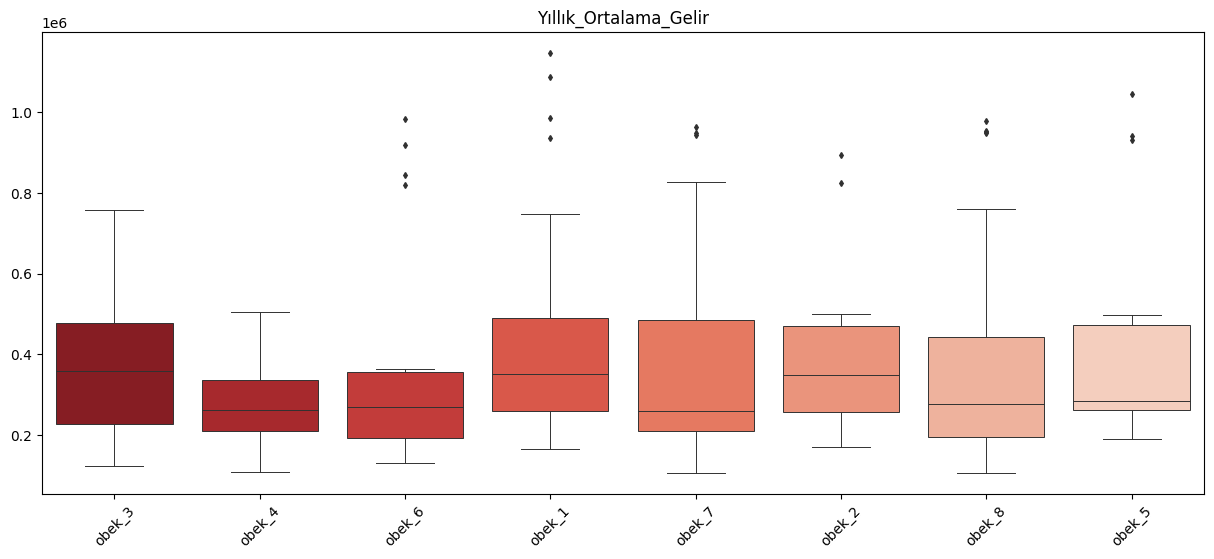

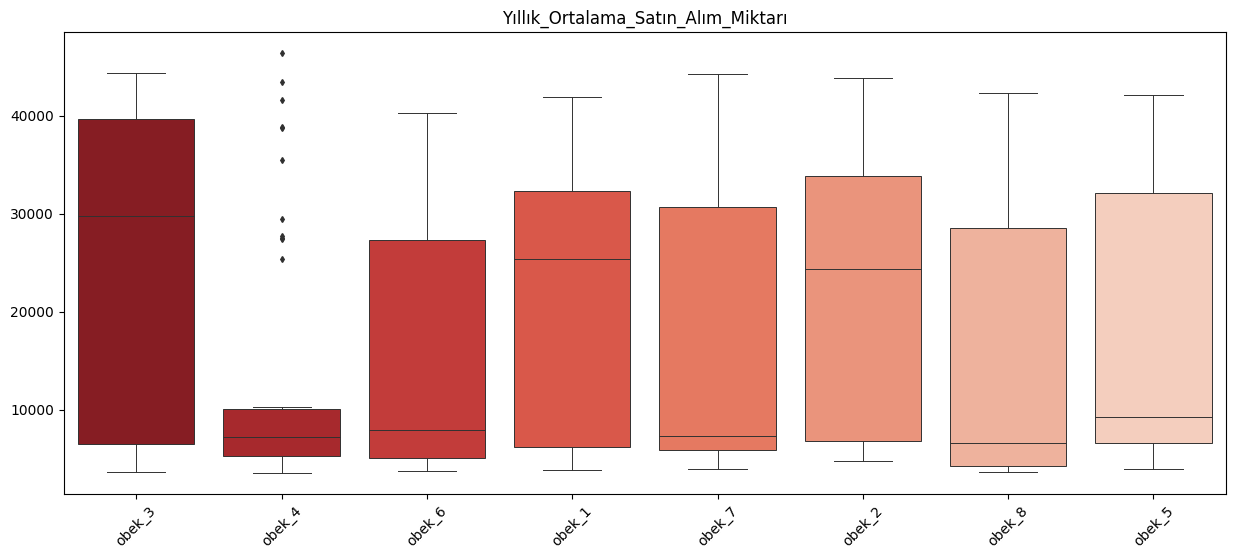

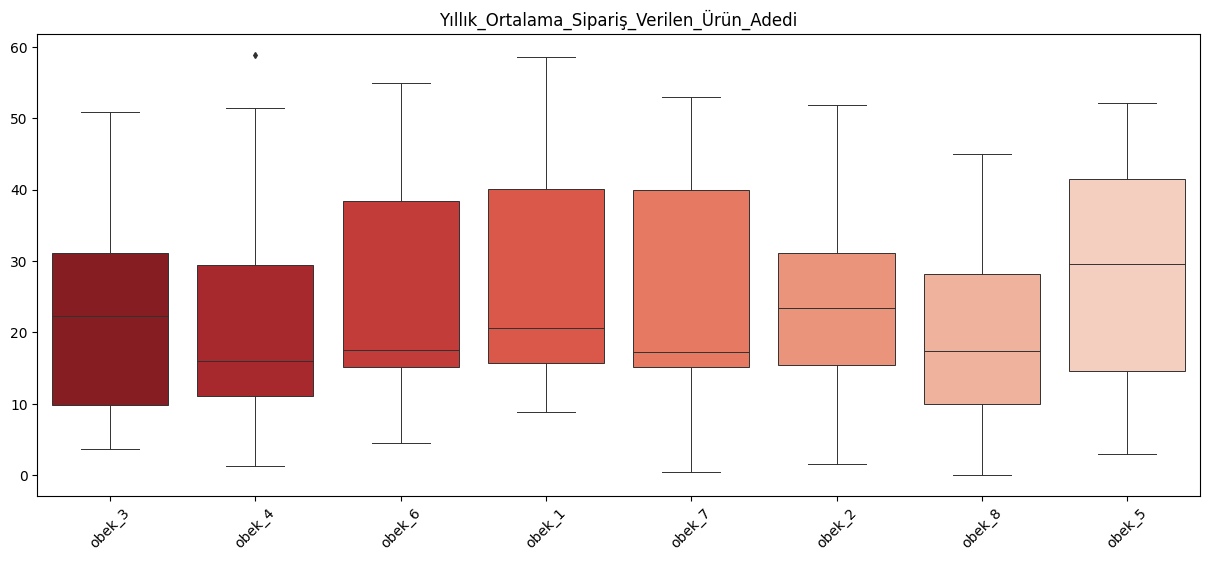

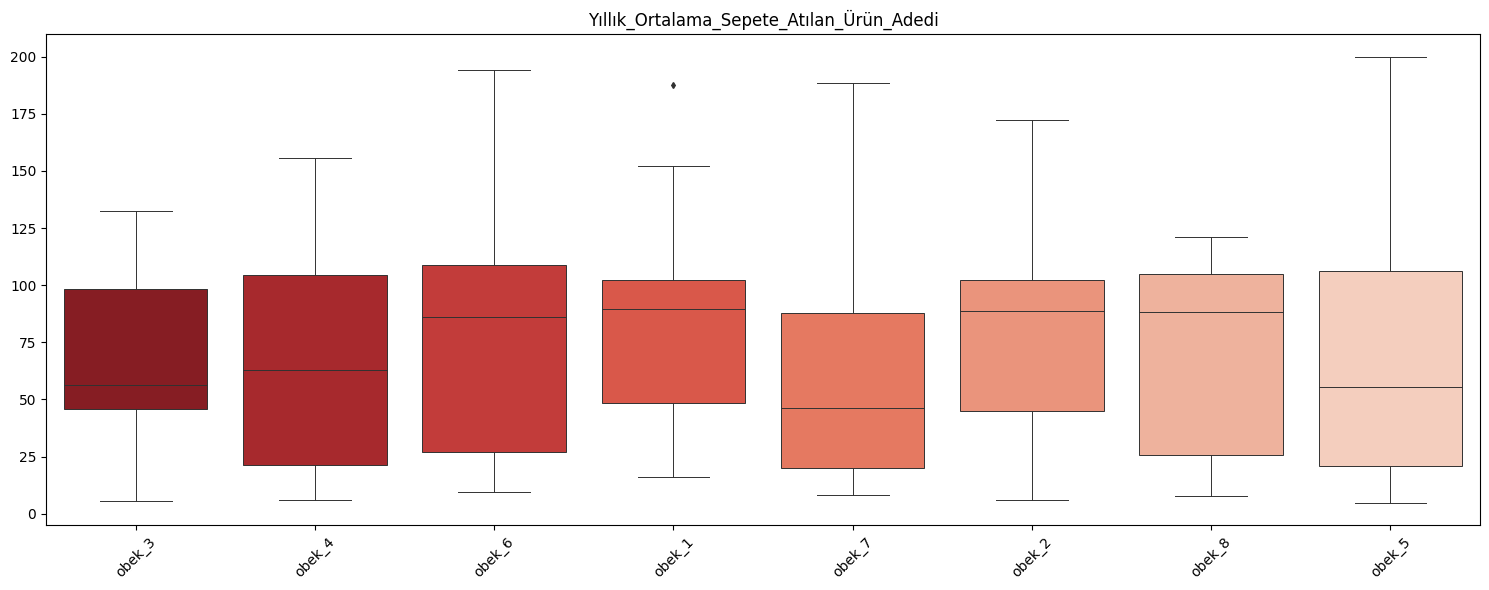

In [69]:
numeric_variables_boxplot(miss, num_cols, target=target, alert=True)

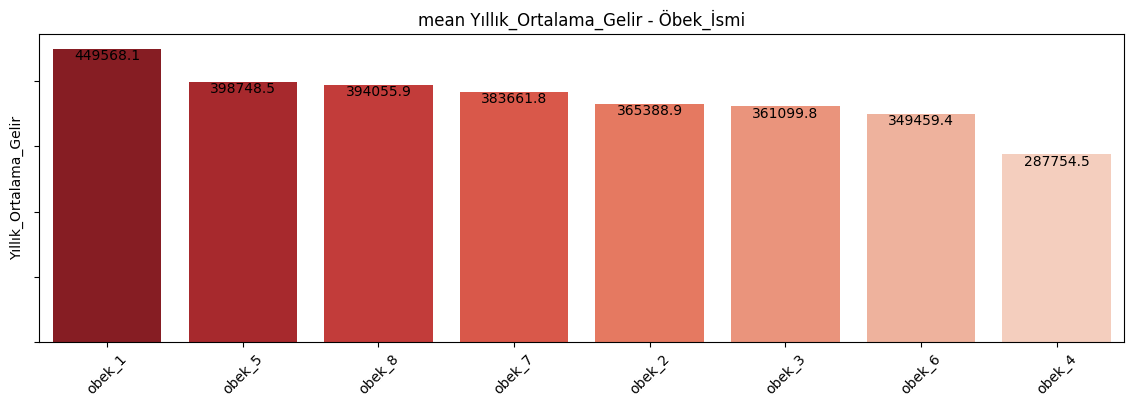

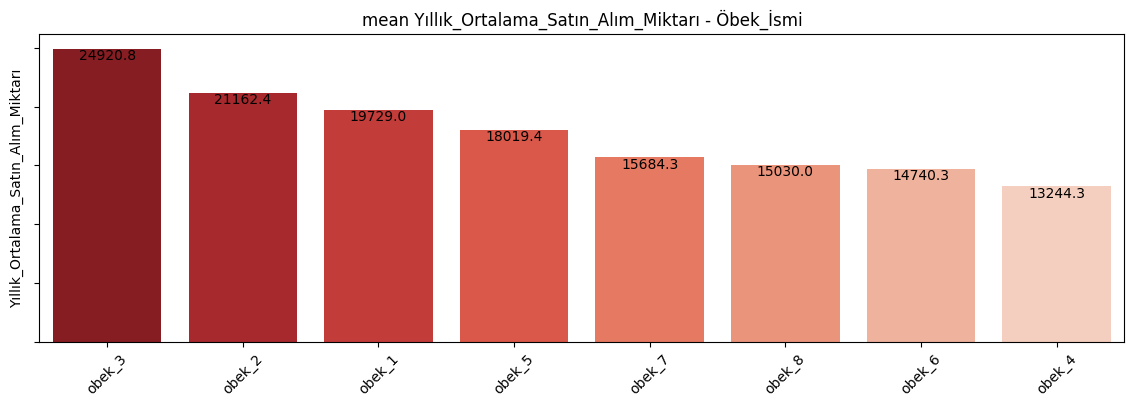

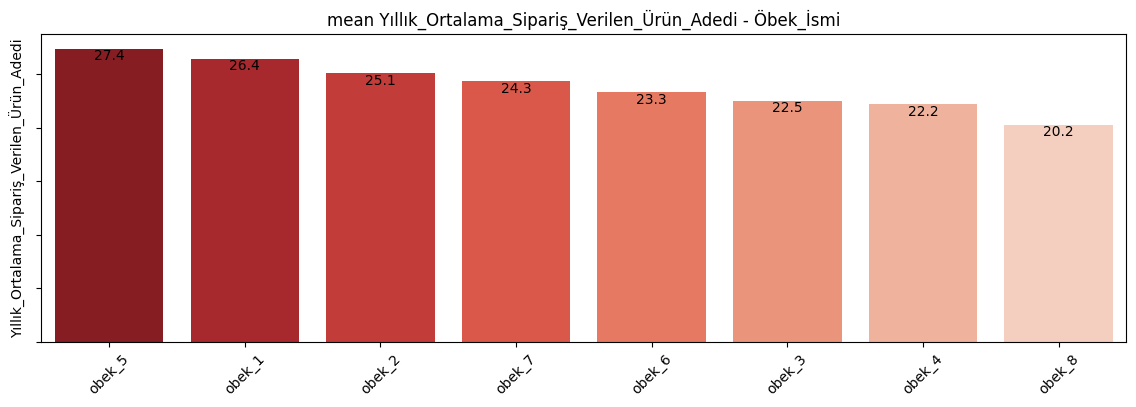

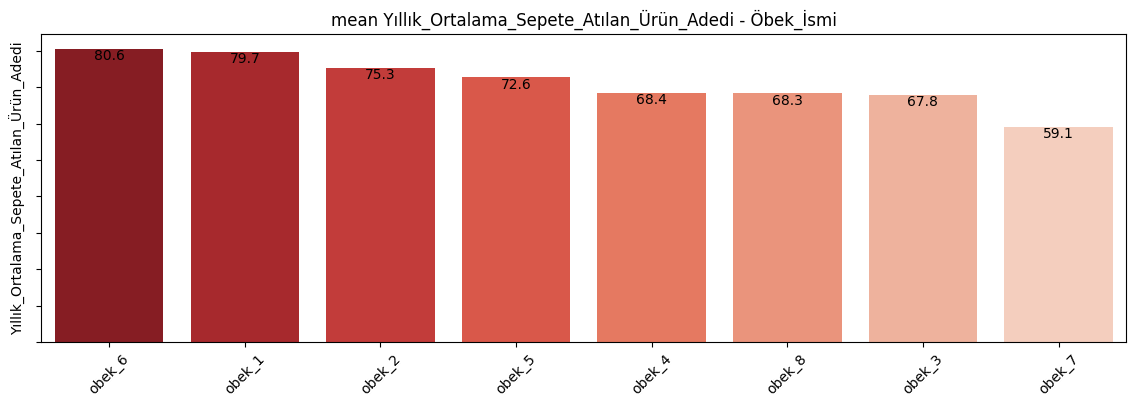

In [70]:
plot_avg_numvars_by_target(miss, num_cols, 'mean', alert = True)

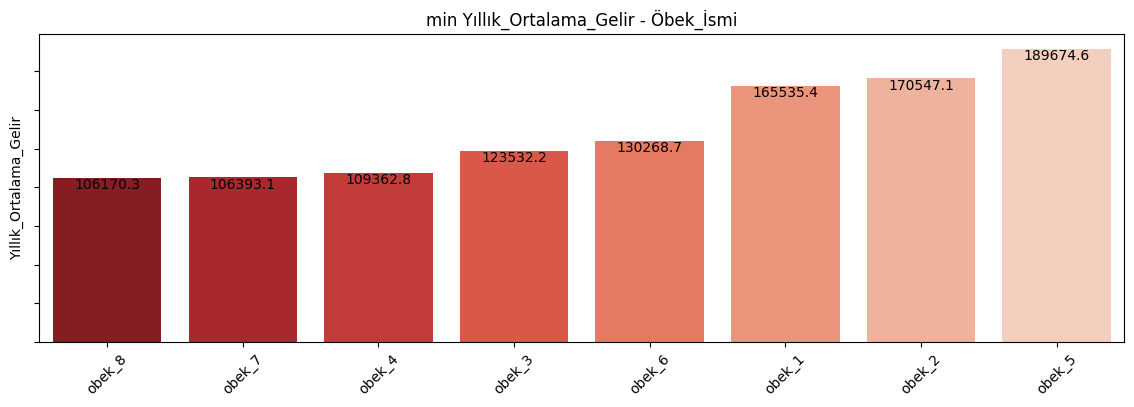

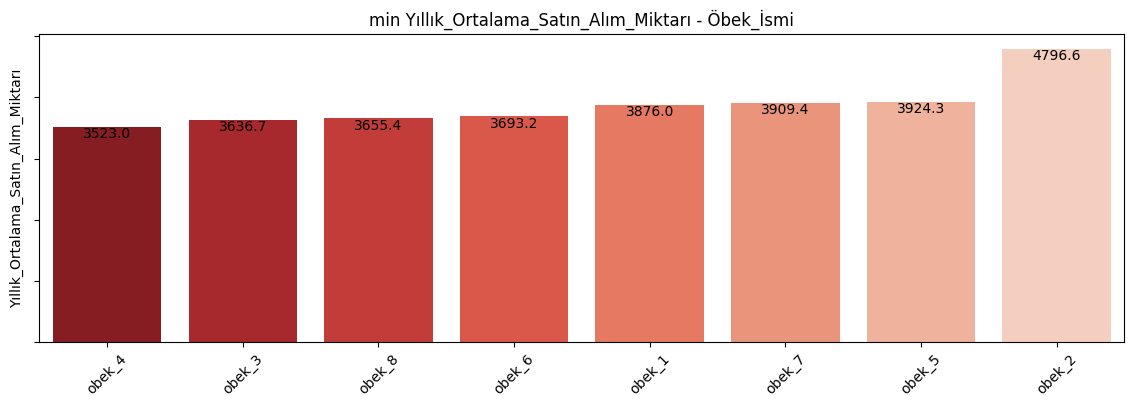

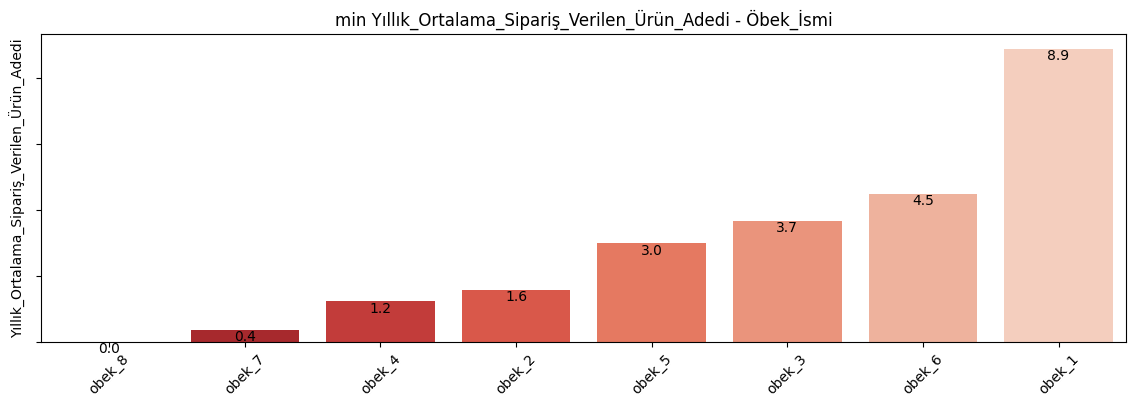

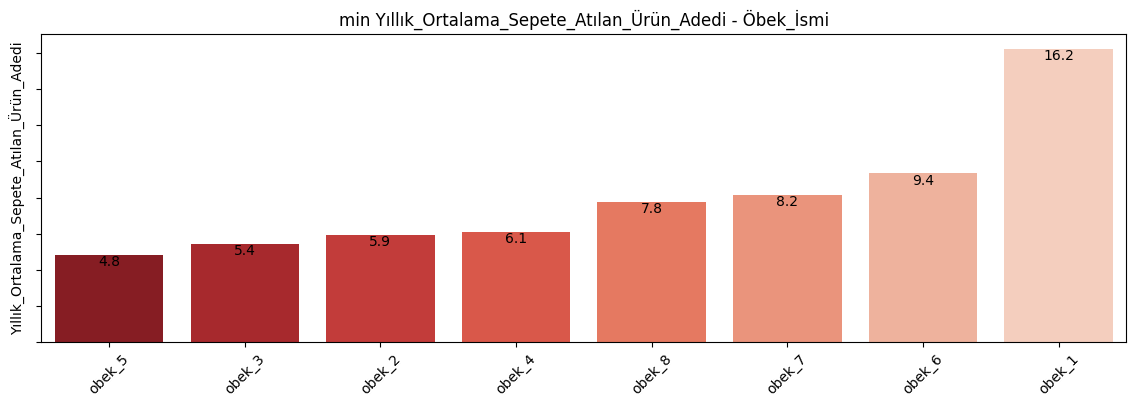

In [71]:
plot_avg_numvars_by_target(miss, num_cols, 'min', alert = True)

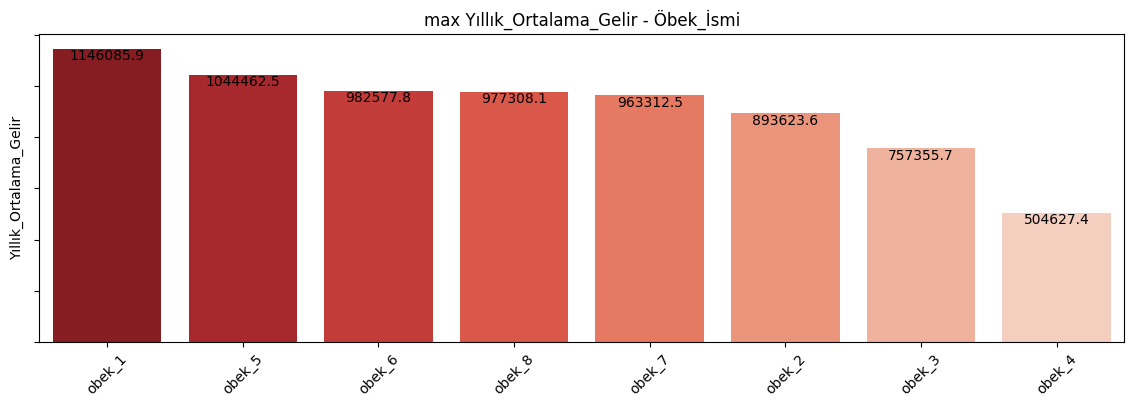

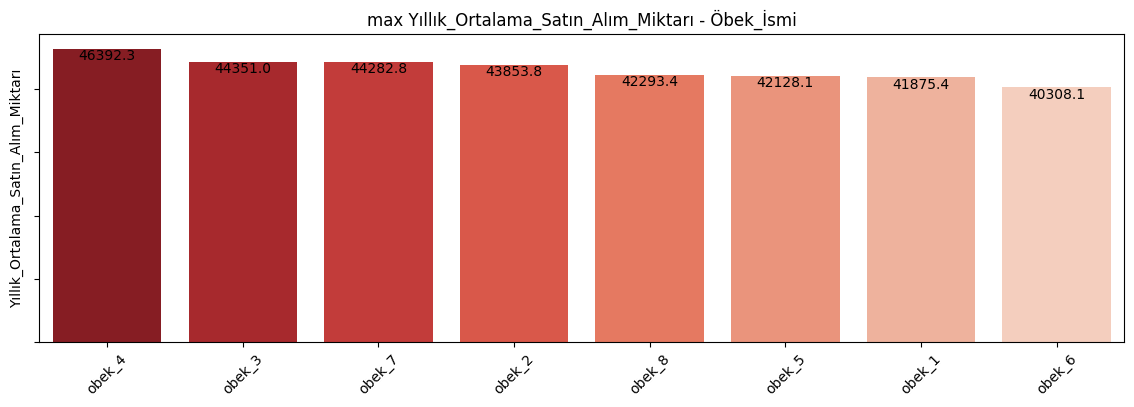

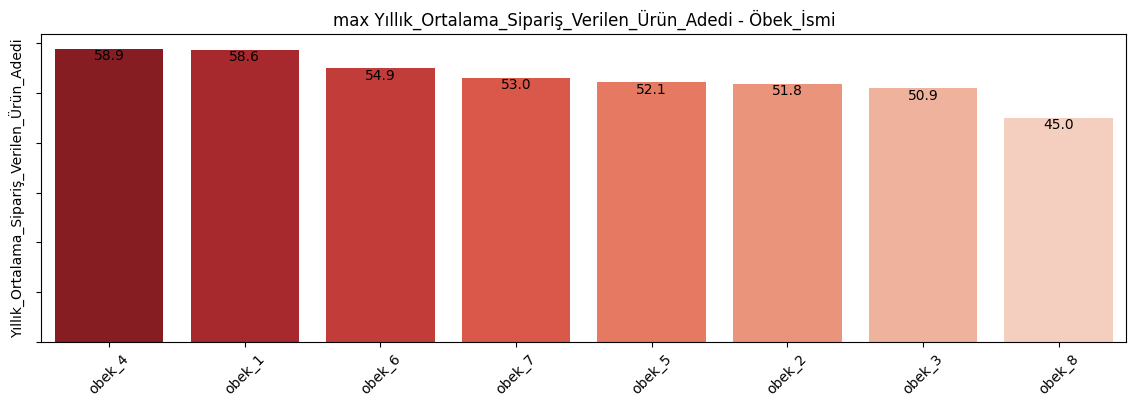

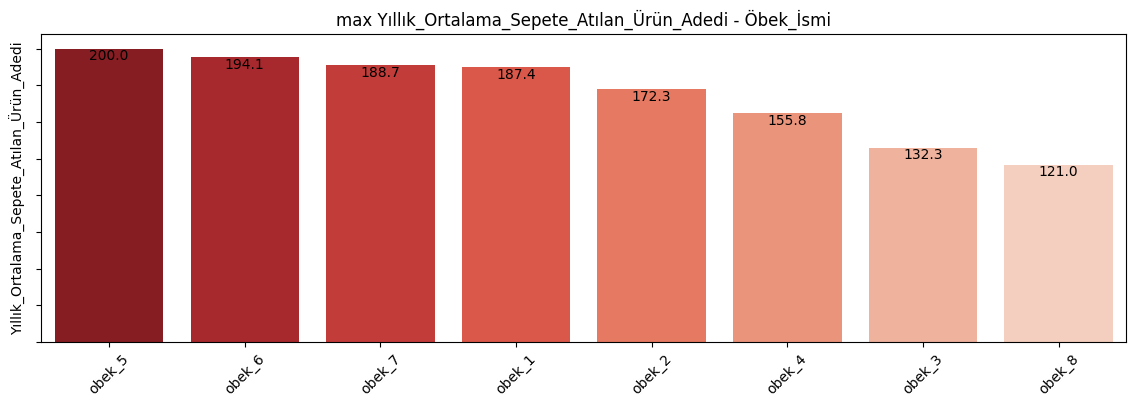

In [72]:
plot_avg_numvars_by_target(miss, num_cols, 'max', alert = True)

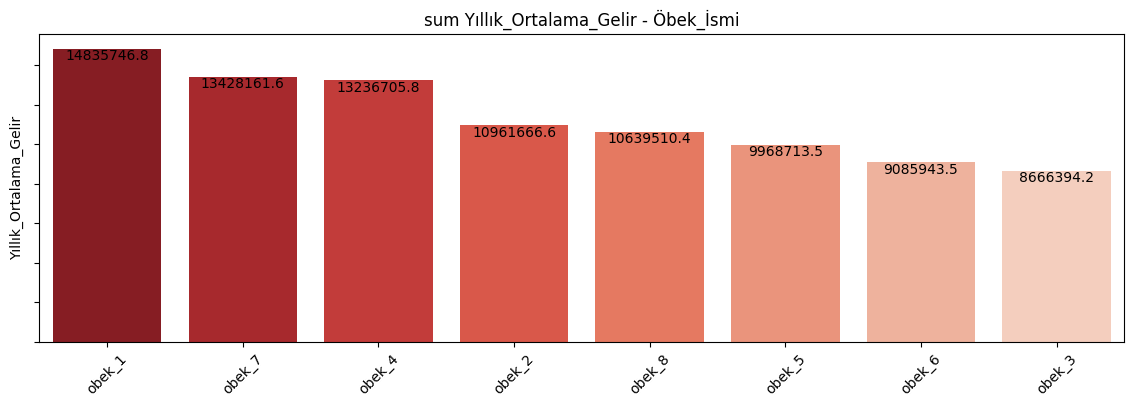

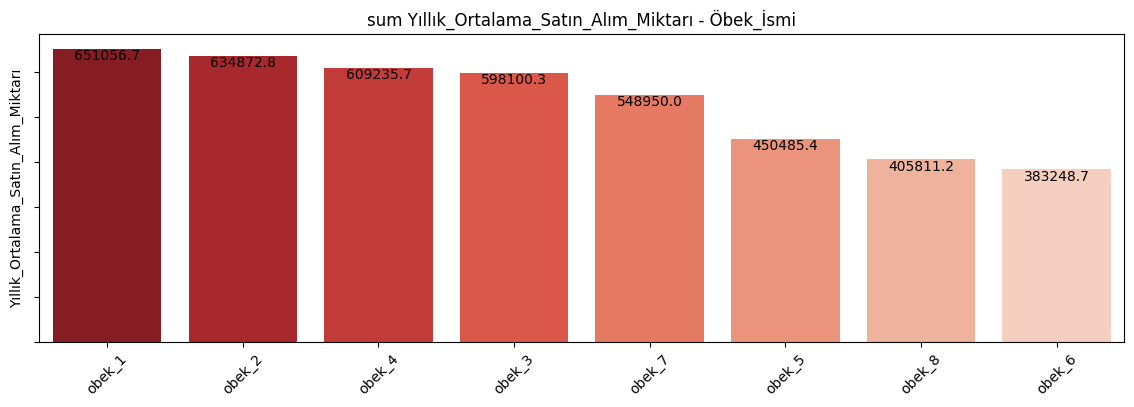

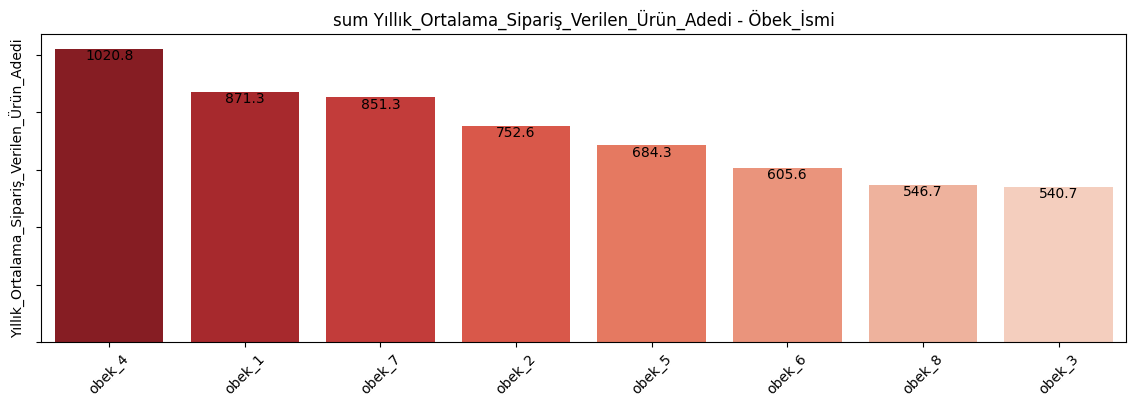

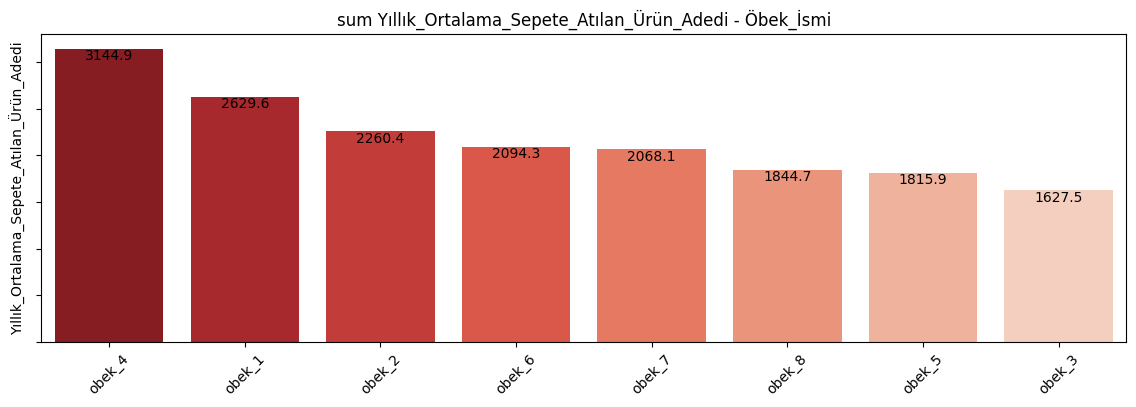

In [73]:
plot_avg_numvars_by_target(miss, num_cols, 'sum', alert = True)

## 8.3. Soruna Yönelik Çözümler <a id="8.3."></a>

### 8.3.1. Bu Örneklemi Eğitim Setinden Çıkartma <a id="8.3.1."></a>

__CV skorları gerçek dışı bir şekilde artsa da bu test skoruna ve leaderboard'a yansımadı.__

In [74]:
x3.drop(misclassified_indexes,inplace=True)
y3.drop(misclassified_indexes,inplace=True)

In [75]:
stratifiedKFold_on_acc(rf,x3,y3,skf10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
scores mean: 1.0 ,scores std :0.0



Total time taken: 1.3630774021148682 seconds


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


### 8.3.2. Bu Örneklemdeki Aykırı Değerleri Ele Alma <a id="8.3.2."></a>

__Bu durumu hala düzeltebileceğimi düşünerek, sorun yaratan örneklemde aykırı değerleri düzeltmek işe yarıyor mu diye kontrol ettim.__

In [76]:
def cap_outliers_iqr(df, col, threshold=1.5):
    
    q1 = np.percentile(df[col].values, 25)
    q3 = np.percentile(df[col].values, 75)
    
    iqr = q3 - q1
    
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    
    capped_col = np.where(df[col].values < lower_bound, lower_bound, df[col].values)
    capped_col = np.where(df[col].values > upper_bound, upper_bound, capped_col)
    
    return capped_col

def cv_with_outlier_handling(df, model, cv, threshold=1.5, num_cols=num_cols):
 
    print(f'Threshold: {threshold}\n\n')
    temp = df.copy()
    for col in num_cols:
        temp[col] = cap_outliers_iqr(temp, col, threshold)

    x = temp.drop([target],axis=1)
    y = temp[target]

    stratifiedKFold_on_acc(model,x,y,cv)
    
    
def cap_misclassified_outliers_iqr(df, misclassed_index, col, threshold=1.5):
    
    q1 = np.percentile(df.loc[misclassed_index,col].values, 25)
    q3 = np.percentile(df.loc[misclassed_index,col].values, 75)
    
    iqr = q3 - q1
    
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    
    capped_col = np.where(df.loc[misclassed_index,col].values < lower_bound, lower_bound, df.loc[misclassed_index,col].values)
    capped_col = np.where(df.loc[misclassed_index,col].values > upper_bound, upper_bound, capped_col)
    
    return capped_col

def cv_with_misclassified_outlier_handling(df, model, cv, misclassed_index, threshold=1.5, num_cols=num_cols):
 
    print(f'Threshold: {threshold}\n\n')
    temp = df.copy()
    for col in num_cols:
        temp.loc[misclassed_index, col] = cap_misclassified_outliers_iqr(temp, misclassed_index,col, threshold)

    x = temp.drop([target],axis=1)
    y = temp[target]

    stratifiedKFold_on_acc(model,x,y,cv)

__Tüm veri setinde outlier capping yapılırsa ne oluyor diye farklı thresholdlar ile deneme:__

In [77]:
for threshold in np.arange(0,3.5,0.5):
    cv_with_outlier_handling(df=train3, model=rf,cv=skf10,threshold=threshold,num_cols=num_cols)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Threshold: 0.0




[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96336996 0.95604396 0.95970696 0.94871795 0.94505495 0.94871795
 0.96886447 0.94505495 0.94871795 0.95054945]
scores mean: 0.9534798534798534 ,scores std :0.007735791971407668



Total time taken: 1.7598333358764648 seconds
Threshold: 0.5




[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96336996 0.95787546 0.96153846 0.95054945 0.94688645 0.94871795
 0.97252747 0.94688645 0.94871795 0.95238095]
scores mean: 0.9549450549450549 ,scores std :0.008157896502315071



Total time taken: 1.9271879196166992 seconds
Threshold: 1.0




[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96336996 0.95787546 0.96153846 0.95054945 0.94688645 0.94871795
 0.97252747 0.94688645 0.94871795 0.95054945]
scores mean: 0.9547619047619047 ,scores std :0.008233614209886109



Total time taken: 1.9381296634674072 seconds
Threshold: 1.5




[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96336996 0.95787546 0.96153846 0.95054945 0.94688645 0.94871795
 0.97252747 0.94688645 0.94871795 0.95238095]
scores mean: 0.9549450549450549 ,scores std :0.008157896502315071



Total time taken: 1.9017829895019531 seconds
Threshold: 2.0




[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96336996 0.95787546 0.96153846 0.95054945 0.94688645 0.94871795
 0.97252747 0.94688645 0.94871795 0.95238095]
scores mean: 0.9549450549450549 ,scores std :0.008157896502315071



Total time taken: 2.018864631652832 seconds
Threshold: 2.5




[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96336996 0.95787546 0.96153846 0.95054945 0.94688645 0.94871795
 0.97252747 0.94688645 0.94871795 0.95238095]
scores mean: 0.9549450549450549 ,scores std :0.008157896502315071



Total time taken: 2.0017361640930176 seconds
Threshold: 3.0


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96336996 0.95787546 0.96153846 0.95054945 0.94688645 0.94871795
 0.97252747 0.94688645 0.94871795 0.95238095]
scores mean: 0.9549450549450549 ,scores std :0.008157896502315071



Total time taken: 1.880155086517334 seconds


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


__Sadece sınıflandırılamayan örneklemde outlier capping yapılırsa ne oluyor diye yine farklı thresholdlar ile deneme:__

In [78]:
for threshold in np.arange(0,3.5,0.5):
    cv_with_misclassified_outlier_handling(train3, model=rf, cv=skf10, misclassed_index=misclassified_indexes, threshold=threshold)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Threshold: 0.0




[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96520147 0.96336996 0.96520147 0.95054945 0.94688645 0.95238095
 0.97435897 0.95238095 0.95054945 0.95421245]
scores mean: 0.9575091575091574 ,scores std :0.008424908424908442



Total time taken: 1.5482370853424072 seconds
Threshold: 0.5




[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96336996 0.95787546 0.96153846 0.95054945 0.94688645 0.94871795
 0.97252747 0.94688645 0.94871795 0.95054945]
scores mean: 0.9547619047619047 ,scores std :0.008233614209886109



Total time taken: 1.6968281269073486 seconds
Threshold: 1.0




[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96336996 0.95787546 0.96153846 0.95054945 0.94688645 0.94871795
 0.97252747 0.94688645 0.94871795 0.95054945]
scores mean: 0.9547619047619047 ,scores std :0.008233614209886109



Total time taken: 1.7423889636993408 seconds
Threshold: 1.5




[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96336996 0.95787546 0.96153846 0.95054945 0.94688645 0.94871795
 0.97252747 0.94688645 0.94871795 0.95238095]
scores mean: 0.9549450549450549 ,scores std :0.008157896502315071



Total time taken: 1.7881050109863281 seconds
Threshold: 2.0




[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96336996 0.95787546 0.96153846 0.95054945 0.94688645 0.94871795
 0.97252747 0.94688645 0.94871795 0.95238095]
scores mean: 0.9549450549450549 ,scores std :0.008157896502315071



Total time taken: 1.7996068000793457 seconds
Threshold: 2.5




[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96336996 0.95787546 0.96153846 0.95054945 0.94688645 0.94871795
 0.97252747 0.94688645 0.94871795 0.95238095]
scores mean: 0.9549450549450549 ,scores std :0.008157896502315071



Total time taken: 1.9541170597076416 seconds
Threshold: 3.0


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96336996 0.95787546 0.96153846 0.95054945 0.94688645 0.94871795
 0.97252747 0.94688645 0.94871795 0.95238095]
scores mean: 0.9549450549450549 ,scores std :0.008157896502315071



Total time taken: 1.8615338802337646 seconds


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


__Genel olarak outlier düzeltmektense, sorunlu örneklemi düzeltmek daha etkiliydi.__

In [79]:
for col in num_cols:
    train3.loc[misclassified_indexes, col] = cap_misclassified_outliers_iqr(df= train3, 
                                                                       misclassed_index= misclassified_indexes, 
                                                                       col= col, 
                                                                       threshold= 0)

In [80]:
x3 = train3.drop([target],axis=1)
y3 = train3[target]

In [81]:
stratifiedKFold_on_acc(rf, x3, y3, skf10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.96520147 0.96336996 0.96520147 0.95054945 0.94688645 0.95238095
 0.97435897 0.95238095 0.95054945 0.95421245]
scores mean: 0.9575091575091574 ,scores std :0.008424908424908442



Total time taken: 1.585813045501709 seconds


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.5s finished


# 9. Oluşturulan Yeni Veri Seti ile Hiperparametre Optimizasyonu <a id="9."></a>

__Bu işlem çok vakit aldığı için buraya dahil etmedim fakat örnek kodlarını aşağıda görebilirsiniz.__

## 9.1. Random Forest için <a id="9.1."></a>

```python

def objective(trial):
    
    params = {
    'n_estimators': 200,
    #'criterion' : trial.suggest_categorical('criterion', ['gini', 'entropy']),
    #'max_depth': trial.suggest_categorical("max_depth", [2,3,4,5,6,7,8,None]), #None
    #'min_samples_split' : trial.suggest_int("min_samples_split", 2, 50),
    #'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 50),
    #'max_features' : trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    #'max_leaf_nodes' : trial.suggest_categorical("max_leaf_nodes", [2,3,4,5,6,7,8,None]), #None
    'max_samples' : 0.9996615986275127,
    #'min_weight_fraction_leaf' : trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.51),
    'min_impurity_decrease' : trial.suggest_float('min_impurity_decrease', 0.01, 1.0),
    #'class_weight' : trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
    'random_state' : 24,
    'n_jobs' : -1
    }
    
    scores = []
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)
    
    for train_index, test_index in skf.split(x1,y1):
        
        X_train, X_test = x1.iloc[train_index], x1.iloc[test_index]
        y_train, y_test = y1.iloc[train_index], y1.iloc[test_index]
        
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
        
    print('\n')
    return sum(scores)/len(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

```

## 9.2. XGBoost için <a id="9.2."></a>

```python

def objective(trial):
    
    params = {
        'objective': 'multi:softmax',  
        'eval_metric': 'mlogloss',     
        'booster': 'gbtree',
        'num_class': 8,      
        'eta': 0.03640505575366477,
        'max_depth': 5,
        'min_child_weight': 4,
        'subsample': 0.7374882086206219,
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        #'gamma': trial.suggest_float('gamma', 0, 5),
        #'alpha': trial.suggest_float('alpha', 0, 5),
        #'lambda': trial.suggest_float('lambda', 0, 5),
        'n_estimators': 102,
        'random_state': 24,  
        'n_jobs': -1
    }
    
    scores = []
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)
    
    for train_index, test_index in skf.split(x1,y1):
        
        X_train, X_test = x1.iloc[train_index], x1.iloc[test_index]
        y_train, y_test = y1.iloc[train_index], y1.iloc[test_index]
        
        model = XGBClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
        
    print('\n')
    return sum(scores)/len(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

```

## 9.3. Elde Edilen Maksimum Cross-Validation Skorları <a id="9.3."></a>

__Bu işlemler sonucunda:__

* Random Forest CV : 0.9587
* XGBoost CV : 0.96003

__skorlarını elde ettim.__

## 9.4. Her İki Model ile Cross-Validation Stack Oluşturma ve Tahmin Yapma <a id="9.4."></a>

__Her iki model ile aşağıda örneğini verdiğim şekilde stackler oluşturup submission yaptım fakat yine hiç bir gelişme kaydedemedim. Bunun sonucunda artık veri setinde bilinçli bir yanlış etiketleme olduğuna kesin kanaat getirdim ve en son oluşturacağım veri seti ve modellere karar verdim.__

```python
params_xgb = {
        'objective': 'multi:softmax',  
        'eval_metric': 'mlogloss',     
        'booster': 'gbtree',
        'num_class': 8,      
        'eta': 0.03640505575366477,
        'max_depth': 5,
        'min_child_weight': 4,
        'subsample': 0.7374882086206219,
        'n_estimators': 102,
        'random_state': 24,  
        'n_jobs': -1}


accuracy = []

models = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)

cv_splits = list(skf.split(x1, y1))

for split_train, split_val in tqdm(cv_splits):
    split_train = x1.index[split_train]
    split_val = x1.index[split_val]
    
    x_train, y_train = x1.loc[split_train], y1.loc[split_train]
    x_val, y_val = x1.loc[split_val], y1.loc[split_val]
    
    print("Train shape:", x_train.shape, "|", "Val Shape:", x_val.shape)
    print("Label value counts in Val Split:", y_val.value_counts())
    
    
    model = XGBClassifier(**params_xgb)
    
    model.fit(x_train, y_train)
    
    preds = model.predict(x_val)
    
    acc = accuracy_score(y_val, preds)
    print("Fold Accuracy: ", acc)
    accuracy.append(acc)
        
    models.append(model)
    
    print("\n", "*-"*50, "\n")
    
print(f'\n Mean Accuracy: {np.mean(accuracy)}, std: {np.std(accuracy)} \n')

```

## 10. Son Kararlar - Final Olarak Elde Edilen Veri Setiyle CV Stack Kurma ve Tahmin Yapma <a id="10."></a>

__Sonuç olarak, sadece kategorik değişkenleri kodladığım ve modellere en çok bilgi sağlayan cluster özelliği olduğunu farkettiğim KPrototype algoritmasıyla oluşturduğum özellikten oluşan, basit veri setini oluşturdum.__

In [94]:
train_final = train.copy()

train_final = encode_cat_features(train_final,cat_cols)
encode_target(train_final,target)

test_final = test.copy()
test_final = encode_cat_features(test_final,cat_cols)

train_final['is_test'] = 0
test_final['is_test'] = 1

tt = pd.concat([train_final, test_final], ignore_index=True)

tt['kproto'] = cluster_kproto(tt)

x = tt.drop([target,'is_test'],axis=1).loc[tt.is_test == 0]
y = tt.loc[tt.is_test == 0, target]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 10


In [107]:
rf_params = {
    'n_estimators': 200,
    'random_state' : 24,
    'n_jobs' : -1
    }

rf_final = RandomForestClassifier(**rf_params)

stratifiedKFold_on_acc(rf_final,x,y,skf10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Model : RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=24)
scores [0.96336996 0.95787546 0.96153846 0.95054945 0.94688645 0.94871795
 0.97252747 0.94688645 0.94871795 0.95238095]
scores mean: 0.9549450549450549 ,scores std :0.008157896502315071



Total time taken: 2.495692014694214 seconds


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished


In [108]:
test_clustered = tt.loc[tt.is_test == 1]

test_clustered.drop(['is_test',target],axis=1,inplace=True)

test_clustered

Yıllık_Ortalama_Gelir  Yıllık_Ortalama_Satın_Alım_Miktarı  \
5460              365331.93                             5566.59   
5461              414899.24                             6756.77   
5462              152825.87                             4493.92   
5463              489052.91                            42670.65   
5464              323635.71                             5959.27   
...                     ...                                 ...   
7795              259190.08                             9559.16   
7796              194580.56                             4070.23   
7797              357730.52                            22589.20   
7798              213179.64                             4205.39   
7799              519013.57                            42675.35   

      Yıllık_Ortalama_Sipariş_Verilen_Ürün_Adedi  \
5460                                       15.44   
5461                                       14.96   
5462                                       10.91   
5463                                       32.33   
5464                                        4.52   
...                                          ...   
7795                                       41.88   
7796                                       20.08   
7797                                       18.92   
7798                                       10.76   
7799                                       30.83   

      Yıllık_Ortalama_Sepete_Atılan_Ürün_Adedi  Cinsiyet_Erkek  \
5460                                     19.65               1   
5461                                     19.68               1   
5462                                     46.90               0   
5463                                     48.08               0   
5464                                     12.75               1   
...                                        ...             ...   
7795                                    117.63               0   
7796                                     45.66               0   
7797                                    100.69               1   
7798                                     97.78               1   
7799                                     39.66               1   

      Cinsiyet_Kadın  Yaş_Grubu_18-30  Yaş_Grubu_31-40  Yaş_Grubu_41-50  \
5460               0                0                0                0   
5461               0                0                0                1   
5462               1                0                0                0   
5463               1                0                0                0   
5464               0                1                0                0   
...              ...              ...              ...              ...   
7795               1                1                0                0   
7796               1                0                1                0   
7797               0                0                0                0   
7798               0                1                0                0   
7799               0                0                0                0   

      Yaş_Grubu_51-60  Yaş_Grubu_>60  Medeni_Durum_Bekar  Medeni_Durum_Evli  \
5460                1              0                   0                  1   
5461                0              0                   1                  0   
5462                0              1                   0                  1   
5463                1              0                   0                  1   
5464                0              0                   0                  1   
...               ...            ...                 ...                ...   
7795                0              0                   1                  0   
7796                0              0                   0                  1   
7797                0              1                   0                  1   
7798                0              0                   0                  1   
7799         

__Son olarak Random Forest ile benzer şekilde stack kurdum ve 10 adet model elde ettim.__

In [109]:
def stack_models_with_cv(x, y, model, n_splits=10):

    accuracy = []

    models = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=24)

    cv_splits = list(skf.split(x, y))

    for split_train, split_val in tqdm(cv_splits):
        split_train = x.index[split_train]
        split_val = x.index[split_val]

        x_train, y_train = x.loc[split_train], y.loc[split_train]
        x_val, y_val = x.loc[split_val], y.loc[split_val]

        print("Train shape:", x_train.shape, "|", "Val Shape:", x_val.shape)
        print("Label value counts in Val Split:", y_val.value_counts())


        model = rf_final

        model.fit(x_train, y_train)

        preds = model.predict(x_val)

        acc = accuracy_score(y_val, preds)
        print("Fold Accuracy: ", acc)
        accuracy.append(acc)

        models.append(model)

        print("\n", "*-"*50, "\n")

    print(f'\n Mean Accuracy: {np.mean(accuracy)}, std: {np.std(accuracy)} \n')
    
    return models

In [110]:
models = stack_models_with_cv(x, y, model= rf_final,n_splits=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train shape: (4914, 38) | Val Shape: (546, 38)
Label value counts in Val Split: 7.00    72
3.00    72
4.00    71
6.00    70
5.00    69
0.00    69
2.00    69
1.00    54
Name: Öbek_İsmi, dtype: int64
Fold Accuracy:  0.9633699633699634

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*- 

Train shape: (4914, 38) | Val Shape: (546, 38)
Label value counts in Val Split: 7.00    72
3.00    72
4.00    71
6.00    70
5.00    69
2.00    69
0.00    69
1.00    54
Name: Öbek_İsmi, dtype: int64
Fold Accuracy:  0.9578754578754579

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*- 

Train shape: (4914, 38) | Val Shape: (546, 38)
Label value counts in Val Split: 3.00    72
7.00    72
4.00    71
6.00    70
2.00    69
5.00    69
0.00    69
1.00    54
Name: Öbek_İsmi, dtype: int64
Fold Accuracy:  0.9615384615384616

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

In [111]:
model_preds = [model.predict(test_clustered) for model in models]

final, _ = (mode(model_preds,axis=0))

sub['Öbek İsmi'] = final[0]

rev_encode_target(sub,'Öbek İsmi')

In [112]:
sub

id Öbek İsmi
0        0    obek_3
1        1    obek_3
2        2    obek_2
3        3    obek_6
4        4    obek_1
...    ...       ...
2335  2335    obek_8
2336  2336    obek_2
2337  2337    obek_7
2338  2338    obek_5
2339  2339    obek_6

[2340 rows x 2 columns]

In [113]:
sub['Öbek İsmi'].value_counts()

obek_1    314
obek_7    306
obek_6    303
obek_4    296
obek_5    293
obek_3    285
obek_8    277
obek_2    266
Name: Öbek İsmi, dtype: int64

In [114]:
#sub.to_csv('sub.csv',index=False)